# Data Preprocessing

An accelerometer is a device that measures acceleration. The typical accelerometer acts like a damped mass that has been mounted on a spring. When exposed to acceleration, this mass moves. This displacement is measured and converted to useful units.
tem.

<img style="max-width: 400px;min-width: 150px;"  src="https://www.datocms-assets.com/53444/1661265289-3-axis-accelerometer-from-dytran.png?auto=format&w=1024&dpr=2"></img>

**Vibration**: an object is said to vibrate when it executes an oscillatory motion about a position of the equilibrium position. Vibration is found in the transportation and aerospace environments or as simulated by a shaker system.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

In [2]:
dt = pd.read_csv("accelerometer.csv")
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153000 entries, 0 to 152999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   wconfid  153000 non-null  int64  
 1   pctid    153000 non-null  int64  
 2   x        153000 non-null  float64
 3   y        153000 non-null  float64
 4   z        153000 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 5.8 MB


In [3]:
dt.head()

wconfid  pctid      x      y      z
0        1     20  1.004  0.090 -0.125
1        1     20  1.004 -0.043 -0.125
2        1     20  0.969  0.090 -0.121
3        1     20  0.973 -0.012 -0.137
4        1     20  1.000 -0.016 -0.121

In [4]:
dt[(dt["pctid"] == 100)]["z"].mean()

-0.12563566666666667

- The vibration measurements of each of these speeds was collected by the accelerometer at a frequency of 20 ms for 1 min, generating 3000 records per speed. Thus, in total, 153,000 vibration records ( 1s -> 50 * 20ms => 50 of 20ms * 60 ( 60s in 1min ) = 3000 )  
- 17 rotation speeds were set up, ranging from 20% to 100% of the cooler maximum speed at 5% intervals. (pctid)
- Once 1 min of data was collected for each motor speed of the cooler, represented by 3000 observations, a set of 50 observations of the dataset were defined as the measuring window, which represent 1 s of signal.
- x,y and z represent the vibrations, if x,y or z != 0 then the device is vibrating by moving towards that direction.

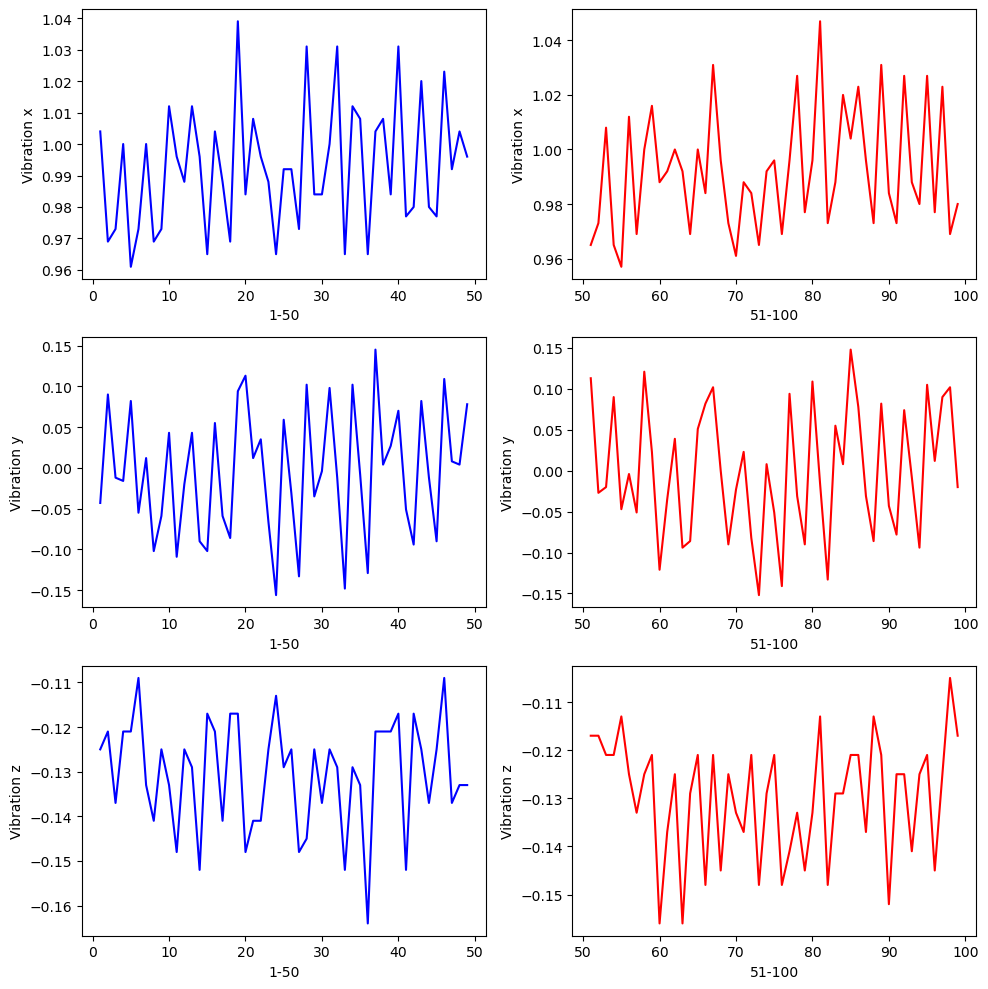

In [5]:
portion = dt[(dt['wconfid'] == 1) & (dt['pctid'] == 20)]

fig,axes = plt.subplots(3, 2, figsize=(10, 10))

axes[0, 0].plot(portion['x'][1:50], color='blue')
axes[0, 0].set_xlabel('1-50')
axes[0, 0].set_ylabel('Vibration x')

axes[0, 1].plot(portion['x'][51:100], color='red')
axes[0, 1].set_xlabel('51-100')
axes[0, 1].set_ylabel('Vibration x')

axes[1, 0].plot(portion['y'][1:50], color='blue')
axes[1, 0].set_xlabel('1-50')
axes[1, 0].set_ylabel('Vibration y')

axes[1, 1].plot(portion['y'][51:100], color='red')
axes[1, 1].set_xlabel('51-100')
axes[1, 1].set_ylabel('Vibration y')

axes[2, 0].plot(portion['z'][1:50], color='blue')
axes[2, 0].set_xlabel('1-50')
axes[2, 0].set_ylabel('Vibration z')

axes[2, 1].plot(portion['z'][51:100], color='red')
axes[2, 1].set_xlabel('51-100')
axes[2, 1].set_ylabel('Vibration z')

plt.tight_layout()
plt.show()

### **Target Generation**



Fourier Transform is a mathematical model which helps to transform the signals between two different domains, such as transforming signal from frequency domain to time domain or vice versa

<div style="display: flex;">
    <img style="max-width: 400px; min-width: 150px;" src="https://content.cdntwrk.com/files/aHViPTg1NDMzJmNtZD1pdGVtZWRpdG9yaW1hZ2UmZmlsZW5hbWU9aXRlbWVkaXRvcmltYWdlXzY1MmNlYmQ5MzJhNzAuanBnJnZlcnNpb249MDAwMCZzaWc9NWQ2MDRhYTA0NWExNmUzNmIzYWFiZTE0NDFjYzkzMTU%253D">
    <img style="max-width: 400px; min-width: 150px;" src='https://miro.medium.com/v2/resize:fit:1358/1*w1mcpi8gCgQI4FrqWFJ2GA.png'>
</div>

to map the various frequencies and amplitudes of the signal we are going to use Fast Fourier Transform function from **scipy**, so we are goin to generate a pair of amplitude and frequency for each measurement window ( 50 record ) resulting in 3060(=153000/50) pair.

<!DOCTYPE html>
<html>
<head>
    <script src="https://polyfill.io/v3/polyfill.min.js?features=es6"></script>
    <script id="MathJax-script" async src="https://cdn.jsdelivr.net/npm/mathjax@3/es5/tex-mml-chtml.js"></script>
</head>
<body>
    <p>To generate a unique value, for each window, the Root Mean Square (RMS) value of the signal, or effective value, for the amplitude and frequency sets, was calculated by the following equation:</p>
    <ul>
        <li>𝑥𝑟𝑚𝑠 : the effective value of the amplitude or frequency.</li>
        <li>𝑥𝑖 : each amplitude or frequency that composes the signal.</li>
        <li>n : the total number of amplitudes or frequencies that compose the signal.</li>
    </ul>
    <p>$$ x_{\text{rms}} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} x_i^2} $$</p>    
</body>
</html>

In [6]:
duration_minutes = 1
duration_seconds = duration_minutes * 60
sampling_interval_ms = 20
sampling_freq_hz = 1000 / sampling_interval_ms
total_samples = int((duration_seconds * 1000) / sampling_interval_ms)

print("Sampling frequency:", sampling_freq_hz, "Hz")
print("Total number of samples:", total_samples)

Sampling frequency: 50.0 Hz
Total number of samples: 3000


In [7]:
def rms(xi,n):
    result = np.array([])
    for i in range(0,len(xi),50):
        result = np.append(result, np.sqrt( (1/n) * sum( xi[i:i+50]**2 )) )
    return result

- To get the actual amplitudes of the spectrum, we have to normalize the output of (fft) by N/2 the number of samples.
- To get the frequency components (x-axis), you can use (fftfreq) from the scipy package.

In [8]:
#for chaque configuration,
#for chaque speed do this :

In [9]:
dt.head()

wconfid  pctid      x      y      z
0        1     20  1.004  0.090 -0.125
1        1     20  1.004 -0.043 -0.125
2        1     20  0.969  0.090 -0.121
3        1     20  0.973 -0.012 -0.137
4        1     20  1.000 -0.016 -0.121

In [10]:
1000/20

50.0

In [11]:
#https://stackoverflow.com/questions/28066036/fourier-transform-and-filtering-frequencies-with-negative-fft-values   https://stackoverflow.com/questions/60812290/scipy-and-numpy-inverse-fft-returns-complex-numbers-not-floats-cant-save-as-wa    

freq_dict = {'x': [], 'y': [], 'z': []}
amp_dict = {'x': [], 'y': [], 'z': []}
ftt_dict = {'x': [], 'y': [], 'z': []}
ff = {'x': [], 'y': [], 'z': []}
for k in dt["wconfid"].unique(): # itterate throught diffrent configuratinos
    for j in dt["pctid"].unique():# itterate throught diffrent speeds
        temp = dt[(dt["wconfid"] == k) &  (dt["pctid"] == j) ]
        num_points = len(temp)
        num_points_window = 50
        sampling_freq = 1000/20  # 50 Hz (sampling frequency (Hz) i.e the number 
                                 # of samples obtained per second when recording a signal), i.e one recored each 20ms 
        time = np.arange(num_points_window) * (1 / sampling_freq) # generate the time array for the measurement window
     
        for i in ['x','y','z']:
            # Fourier transform
            fft_result = np.fft.fft(temp[i].values).real
            # calculate the frequency values
            freq = np.abs(np.fft.fftfreq(num_points, 1 / sampling_freq) )
            # calculate the amplitude (magnitude) of the Fourier transform (normalized)
            amplitude =  np.abs(fft_result) / (num_points/2) 
            amp_dict[i].extend(amplitude)
            freq_dict[i].extend(freq)
            ftt_dict[i].extend(fft_result)
            ff[i].extend(np.fft.fftfreq(num_points, 1 / sampling_freq))
        
processed = pd.DataFrame({
    'ftt_x': ftt_dict['x'],
    'ftt_y': ftt_dict['y'],
    'ftt_z': ftt_dict['z'],
    'freq_x':freq_dict['x'],
    'amp_x': amp_dict['x'],
    'freq_y': freq_dict['y'],
    'amp_y': amp_dict['y'],
    'freq_z': freq_dict['z'],
    'amp_z': amp_dict['z']
})

In [12]:
#notice :

unique_values, counts = np.unique(dt['pctid'], return_counts=True)
print("Unique values:", unique_values)
print("Counts:", counts)

unique_values, counts = np.unique(dt['wconfid'], return_counts=True)
print("Unique values:", unique_values)
print("Counts:", counts)


Unique values: [ 20  25  30  35  40  45  50  55  60  65  70  75  80  85  90  95 100]
Counts: [9000 9000 9000 9000 9000 9000 9000 9000 9000 9000 9000 9000 9000 9000
 9000 9000 9000]
Unique values: [1 2 3]
Counts: [51000 51000 51000]


In [13]:
data =  pd.DataFrame({
    'ftt_x':  rms(processed['ftt_x'],num_points_window),
    'ftt_y':  rms(processed['ftt_y'],num_points_window),
    'ftt_z':  rms(processed['ftt_z'],num_points_window),
    'freq_x':  rms(processed['freq_x'],num_points_window),
    'amp_x': rms(processed['amp_x'],num_points_window),
    'freq_y': rms(processed['freq_y'],num_points_window),
    'amp_y': rms(processed['amp_y'],num_points_window),
    'freq_z': rms(processed['freq_z'],num_points_window),
    'amp_z': rms(processed['amp_z'],num_points_window),
    'wconfid': np.array( [dt['wconfid'][(2*i+50)//2] for i in range(0,len(dt),50)]),
    'pctid': np.array( [dt['pctid'][(2*i+50)//2] for i in range(0,len(dt),50)] )
})

In [14]:
data.head()

ftt_x     ftt_y      ftt_z    freq_x     amp_x    freq_y     amp_y  \
0  422.079235  2.303057  55.601713  0.473902  0.281386  0.473902  0.001535   
1    0.737836  2.951814   0.499630  1.264746  0.000492  1.264746  0.001968   
2    0.921166  2.515945   0.386033  2.088893  0.000614  2.088893  0.001677   
3    0.789576  3.817060   0.398700  2.918261  0.000526  2.918261  0.002545   
4    0.828890  3.009804   0.343958  3.749389  0.000553  3.749389  0.002007   

     freq_z     amp_z  wconfid  pctid  
0  0.473902  0.037068        1     20  
1  1.264746  0.000333        1     20  
2  2.088893  0.000257        1     20  
3  2.918261  0.000266        1     20  
4  3.749389  0.000229        1     20

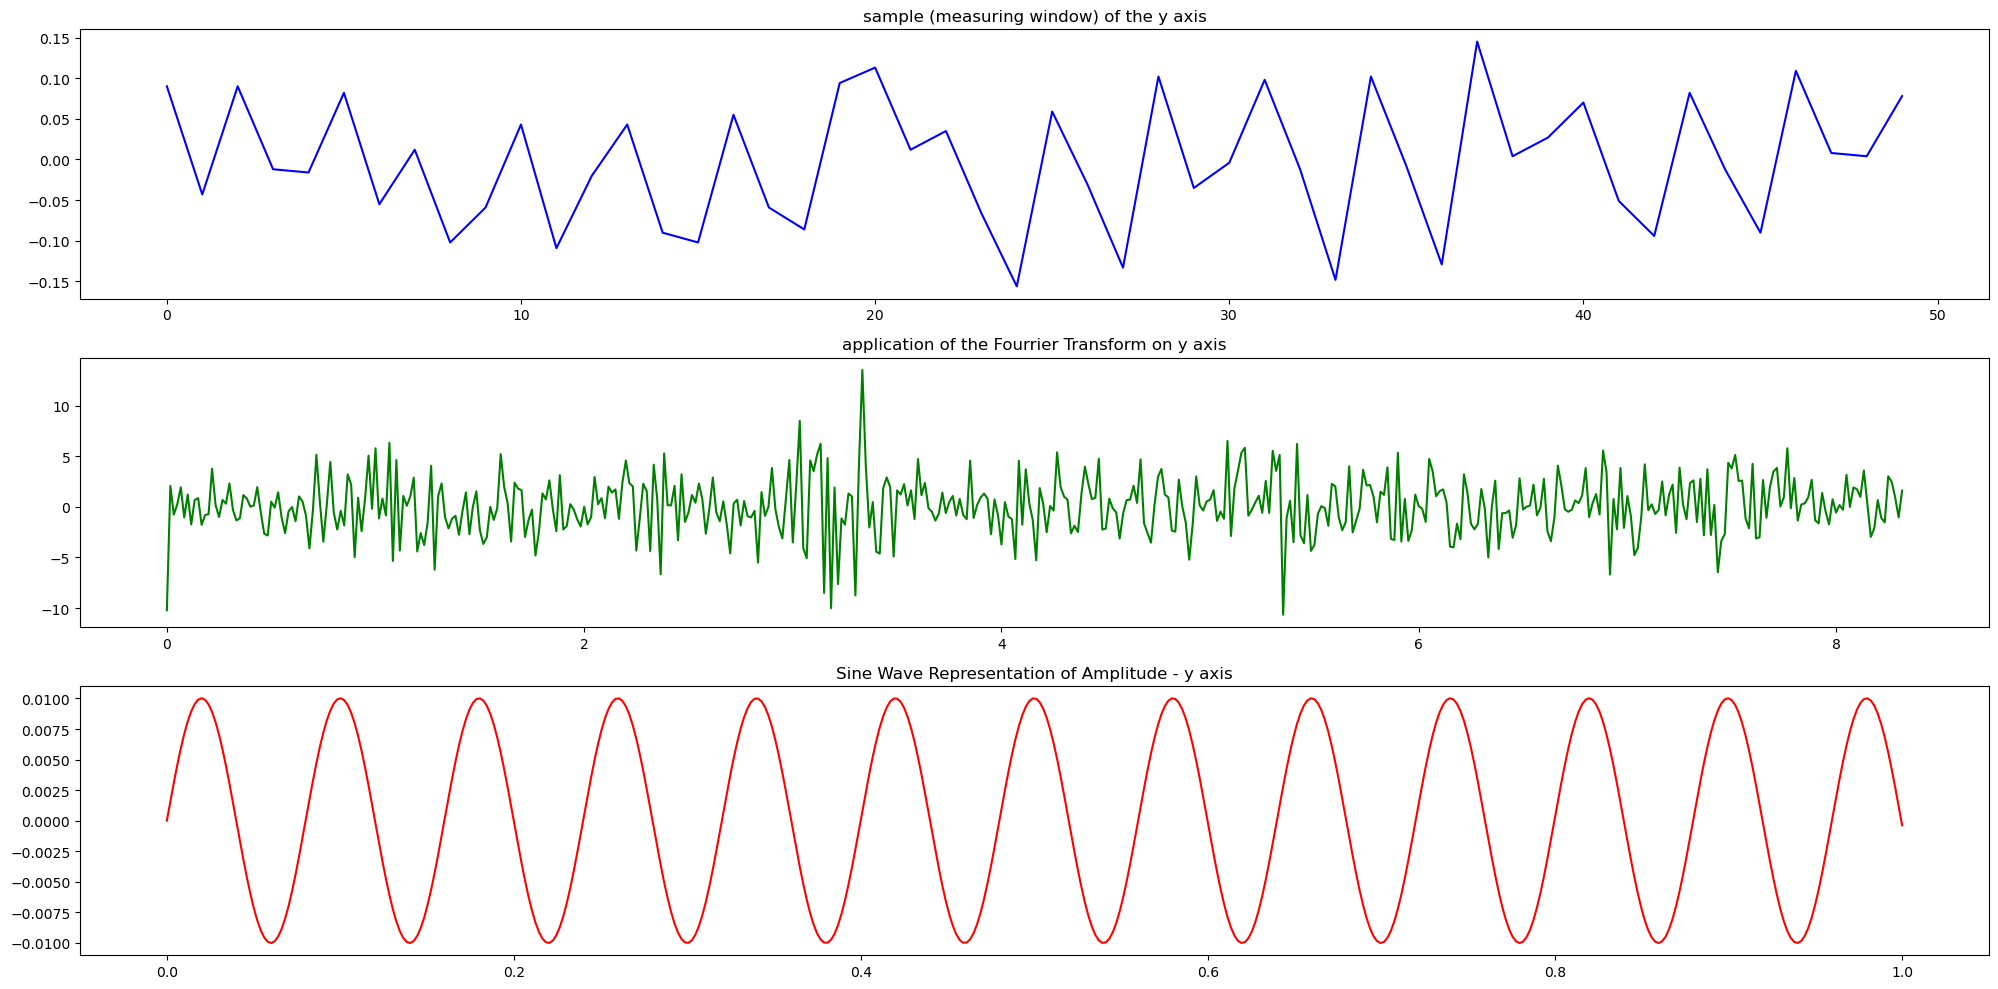

In [15]:
fig, axes = plt.subplots(3, 1, figsize=(20, 10))

axes[0].plot(dt['y'][:50], color='blue')
axes[0].set_title("sample (measuring window) of the y axis")

axes[1].plot(processed['freq_y'][0:500],processed['ftt_y'][0:500],color='green') # plot with normalization
axes[1].set_title("application of the Fourrier Transform on y axis")



t = np.linspace(0, 1, 500)

frequency = data['freq_y'].mean()
amplitude = data['amp_y'].mean()
y = amplitude * np.sin(2 * np.pi * frequency * t)
axes[2].plot(t, y, color='red')
axes[2].set_title("Sine Wave Representation of Amplitude - y axis")



plt.tight_layout()
plt.show()

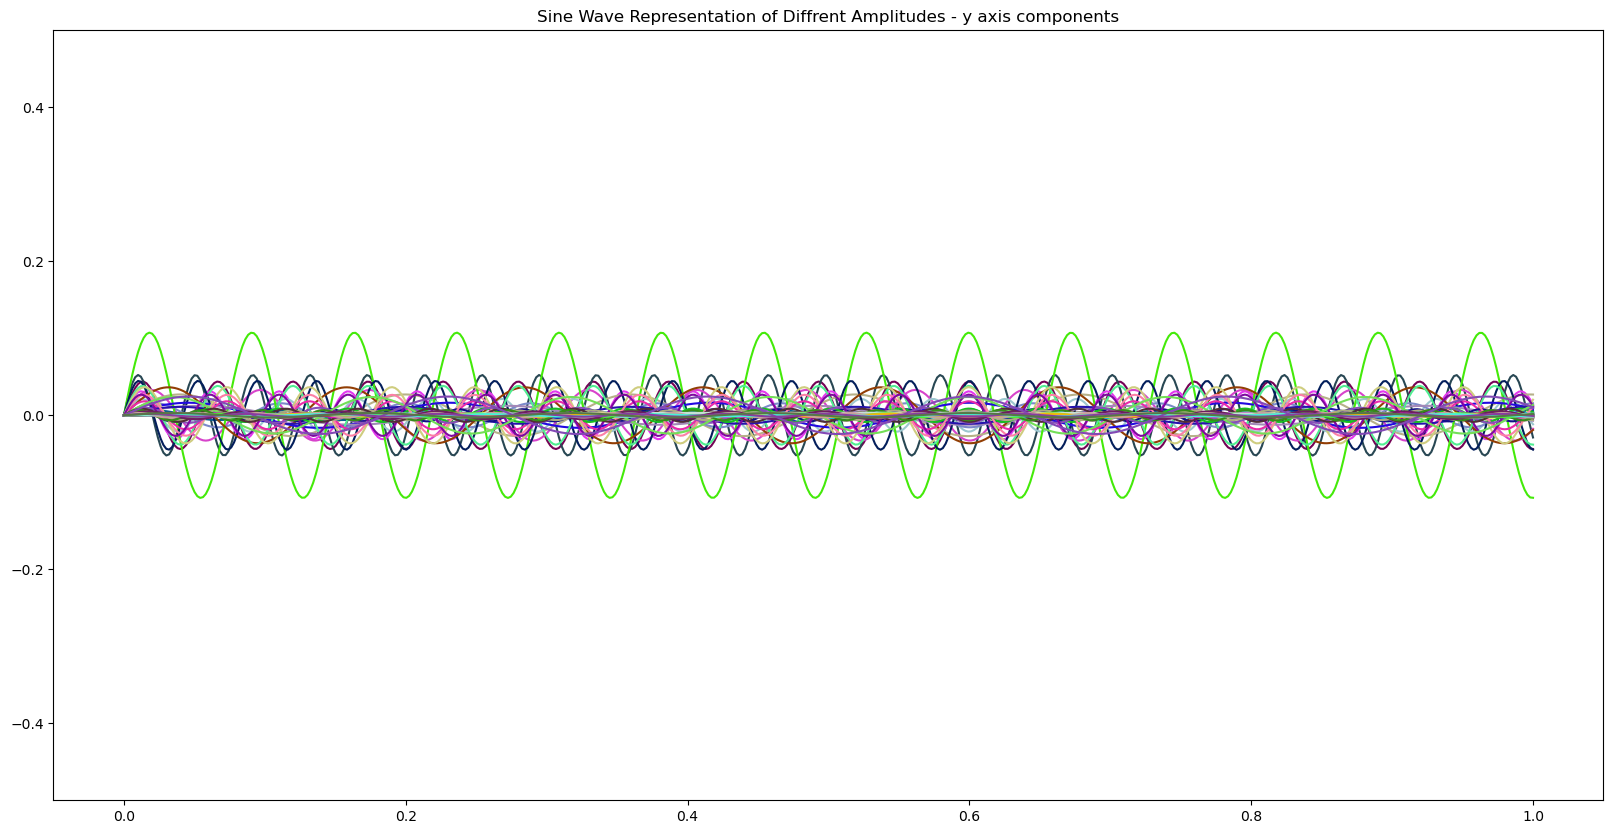

In [16]:
import random

t = np.linspace(0, 1, 500)
frequencies = data['freq_y'].values
amplitudes = data['amp_y'].values

# Select 100 random frequencies
random_indices = random.sample(range(len(frequencies)), 100)
random_frequencies = frequencies[random_indices]
random_amplitudes = amplitudes[random_indices]
random_colors = np.random.rand(100, 3)

fig, axes = plt.subplots(1, 1, figsize=(20, 10)) 
axes.set_title("Sine Wave Representation of Diffrent Amplitudes - y axis components")

for i in range(100):
    frequency = random_frequencies[i]
    amplitude = random_amplitudes[i]
    y = amplitude * np.sin(2 * np.pi * frequency * t)
    axes.plot(t, y, color=random_colors[i], label=f'Amplitude {amplitude:.2f}')

axes.set_ylim(-0.5, 0.5)
#axes.legend()
plt.show()


The limit values, i.e., the maximum possible amplitude or frequency values before equipment failure, were defined by means of the analysis of the measurements made with the cooler rotating at the maximum speed. Thus, the highest values of each amplitude and frequency pair were found for each axis. The maximum amplitudes on the accelerometer measurement scale ([−8𝑔,8𝑔]
) were 0.25 for the x axis and 0.7 for the y and z axes with a frequency of 18 Hz for all the 3 axes.

In [17]:
x_lim = 0.25
y_lim = 0.7
z_lim = 0.7

for the regression dataset, we will remove the amplitude and frequency of the x axis, since the way the accelerometer was installed did not generate vibrations on that axis because it is the axis of height. The frequency attributes of the y and z axes were then removed. Although they generated values, the interval between the measured frequencies and the threshold was small and almost unchanged. Thus, only the amplitudes of the y and z axes were used for the training dataset.

In [18]:
data.head()

ftt_x     ftt_y      ftt_z    freq_x     amp_x    freq_y     amp_y  \
0  422.079235  2.303057  55.601713  0.473902  0.281386  0.473902  0.001535   
1    0.737836  2.951814   0.499630  1.264746  0.000492  1.264746  0.001968   
2    0.921166  2.515945   0.386033  2.088893  0.000614  2.088893  0.001677   
3    0.789576  3.817060   0.398700  2.918261  0.000526  2.918261  0.002545   
4    0.828890  3.009804   0.343958  3.749389  0.000553  3.749389  0.002007   

     freq_z     amp_z  wconfid  pctid  
0  0.473902  0.037068        1     20  
1  1.264746  0.000333        1     20  
2  2.088893  0.000257        1     20  
3  2.918261  0.000266        1     20  
4  3.749389  0.000229        1     20

In [19]:
growth_rate_a = 0.02
growth_rate_b = 0.05
growth_rate_c = 0.01
growth_rate_d = 0.015
growth_rate_e = 0.03
growth_rate_f = 0.04

<!DOCTYPE html>
<html>
<head>
    <script src="https://polyfill.io/v3/polyfill.min.js?features=es6"></script>
    <script id="MathJax-script" async src="https://cdn.jsdelivr.net/npm/mathjax@3/es5/tex-mml-chtml.js"></script>
    <title>Calculating the Expected Failure Time :</title>
</head>
<body>
    <p>
     $$ FT_x = \frac{x_{\text{lim}} - x}{x \cdot g_r} $$</p>
    <p>$$ FT_e = \frac{\sum_{n=1}^{n} \frac{x_{\text{ilim}} - x_i}{x_i \cdot g_r}} {n} $$</p>
</body>
</html>


In [20]:
import copy


copy1 = copy.copy(data)
fty = [(y_lim - i) / (i * growth_rate_a + 10e-5) for i in copy1['amp_y']]
ftz = [(z_lim - i) / (i * growth_rate_a + 10e-5) for i in copy1['amp_z']]
copy1['fte'] = [(fy + fz) / 2 for fy, fz in zip(fty, ftz)]
copy1["signal_growth_rate_y"] = copy1["amp_y"] * growth_rate_a 
copy1["signal_growth_rate_z"] = copy1["amp_z"] * growth_rate_a

final_data = pd.concat([copy1], axis=0)

final_data.reset_index(drop=True, inplace=True)

copy1 = copy.copy(data)
fty = [(y_lim - i) / (i * growth_rate_b + 10e-5) for i in copy1['amp_y']]
ftz = [(z_lim - i) / (i * growth_rate_b + 10e-5) for i in copy1['amp_z']]
copy1['fte'] = [(fy + fz) / 2 for fy, fz in zip(fty, ftz)]
copy1["signal_growth_rate_y"] = copy1["amp_y"] * growth_rate_b 
copy1["signal_growth_rate_z"] = copy1["amp_z"] * growth_rate_b

final_data = pd.concat([final_data, copy1], axis=0)
final_data.reset_index(drop=True, inplace=True)

copy1 = copy.copy(data)
fty = [(y_lim - i) / (i * growth_rate_c + 10e-5) for i in copy1['amp_y']]
ftz = [(z_lim - i) / (i * growth_rate_c + 10e-5) for i in copy1['amp_z']]
copy1['fte'] = [(fy + fz) / 2 for fy, fz in zip(fty, ftz)]
copy1["signal_growth_rate_y"] = copy1["amp_y"] * growth_rate_c 
copy1["signal_growth_rate_z"] = copy1["amp_z"] * growth_rate_c

final_data = pd.concat([final_data, copy1], axis=0)
final_data.reset_index(drop=True, inplace=True)




test_data = copy.copy(data)
fty = [(y_lim - i) / (i * growth_rate_d + 10e-5) for i in test_data['amp_y']]
ftz = [(z_lim - i) / (i * growth_rate_d + 10e-5) for i in test_data['amp_z']]
test_data['fte'] = [(fy + fz) / 2 for fy, fz in zip(fty, ftz)]
test_data["signal_growth_rate_y"] = test_data["amp_y"] * growth_rate_d
test_data["signal_growth_rate_z"] = test_data["amp_z"] * growth_rate_d


final_test_data = pd.concat([test_data], axis=0)

final_test_data.reset_index(drop=True, inplace=True)

fty = [(y_lim - i) / (i * growth_rate_e + 10e-5) for i in test_data['amp_y']]
ftz = [(z_lim - i) / (i * growth_rate_e + 10e-5) for i in test_data['amp_z']]
test_data['fte'] = [(fy + fz) / 2 for fy, fz in zip(fty, ftz)]
test_data["signal_growth_rate_y"] = test_data["amp_y"] * growth_rate_e
test_data["signal_growth_rate_z"] = test_data["amp_z"] * growth_rate_e



final_test_data = pd.concat([test_data,final_test_data], axis=0)

final_test_data.reset_index(drop=True, inplace=True)



fty = [(y_lim - i) / (i * growth_rate_f + 10e-5) for i in test_data['amp_y']]
ftz = [(z_lim - i) / (i * growth_rate_f + 10e-5) for i in test_data['amp_z']]
test_data['fte'] = [(fy + fz) / 2 for fy, fz in zip(fty, ftz)]
test_data["signal_growth_rate_y"] = test_data["amp_y"] * growth_rate_f
test_data["signal_growth_rate_z"] = test_data["amp_z"] * growth_rate_f


final_test_data = pd.concat([test_data,final_test_data], axis=0)

final_test_data.reset_index(drop=True, inplace=True)
test_data = final_test_data

In [21]:
final_data.head()

ftt_x     ftt_y      ftt_z    freq_x     amp_x    freq_y     amp_y  \
0  422.079235  2.303057  55.601713  0.473902  0.281386  0.473902  0.001535   
1    0.737836  2.951814   0.499630  1.264746  0.000492  1.264746  0.001968   
2    0.921166  2.515945   0.386033  2.088893  0.000614  2.088893  0.001677   
3    0.789576  3.817060   0.398700  2.918261  0.000526  2.918261  0.002545   
4    0.828890  3.009804   0.343958  3.749389  0.000553  3.749389  0.002007   

     freq_z     amp_z  wconfid  pctid          fte  signal_growth_rate_y  \
0  0.473902  0.037068        1     20  3065.829373              0.000031   
1  1.264746  0.000333        1     20  5784.305434              0.000039   
2  2.088893  0.000257        1     20  5941.987219              0.000034   
3  2.918261  0.000266        1     20  5633.144780              0.000051   
4  3.749389  0.000229        1     20  5835.937044              0.000040   

   signal_growth_rate_z  
0              0.000741  
1              0.000007  
2              0.000005  
3              0.000005  
4              0.000005

In [22]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9180 entries, 0 to 9179
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ftt_x                 9180 non-null   float64
 1   ftt_y                 9180 non-null   float64
 2   ftt_z                 9180 non-null   float64
 3   freq_x                9180 non-null   float64
 4   amp_x                 9180 non-null   float64
 5   freq_y                9180 non-null   float64
 6   amp_y                 9180 non-null   float64
 7   freq_z                9180 non-null   float64
 8   amp_z                 9180 non-null   float64
 9   wconfid               9180 non-null   int64  
 10  pctid                 9180 non-null   int64  
 11  fte                   9180 non-null   float64
 12  signal_growth_rate_y  9180 non-null   float64
 13  signal_growth_rate_z  9180 non-null   float64
dtypes: float64(12), int64(2)
memory usage: 1004.2 KB


In [23]:
final_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9180 entries, 0 to 9179
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ftt_x                 9180 non-null   float64
 1   ftt_y                 9180 non-null   float64
 2   ftt_z                 9180 non-null   float64
 3   freq_x                9180 non-null   float64
 4   amp_x                 9180 non-null   float64
 5   freq_y                9180 non-null   float64
 6   amp_y                 9180 non-null   float64
 7   freq_z                9180 non-null   float64
 8   amp_z                 9180 non-null   float64
 9   wconfid               9180 non-null   int64  
 10  pctid                 9180 non-null   int64  
 11  fte                   9180 non-null   float64
 12  signal_growth_rate_y  9180 non-null   float64
 13  signal_growth_rate_z  9180 non-null   float64
dtypes: float64(12), int64(2)
memory usage: 1004.2 KB


### EDA & feature selection

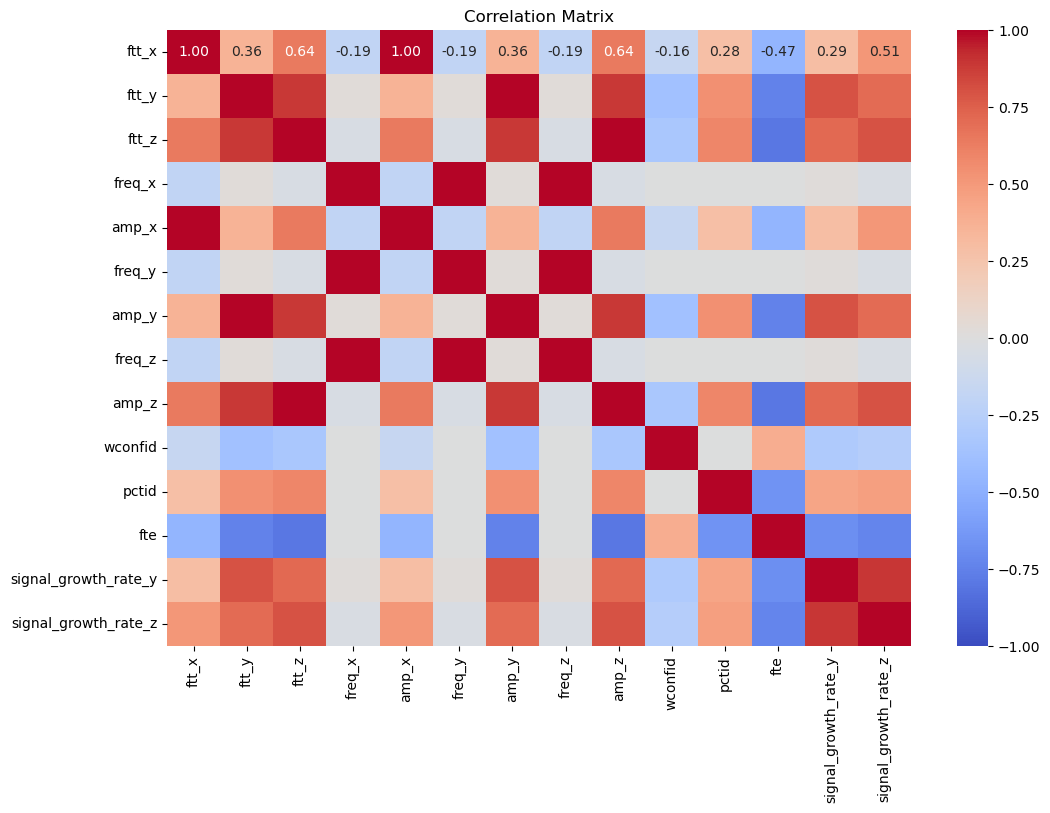

In [24]:
import seaborn as sns

correlation_matrix = final_data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()


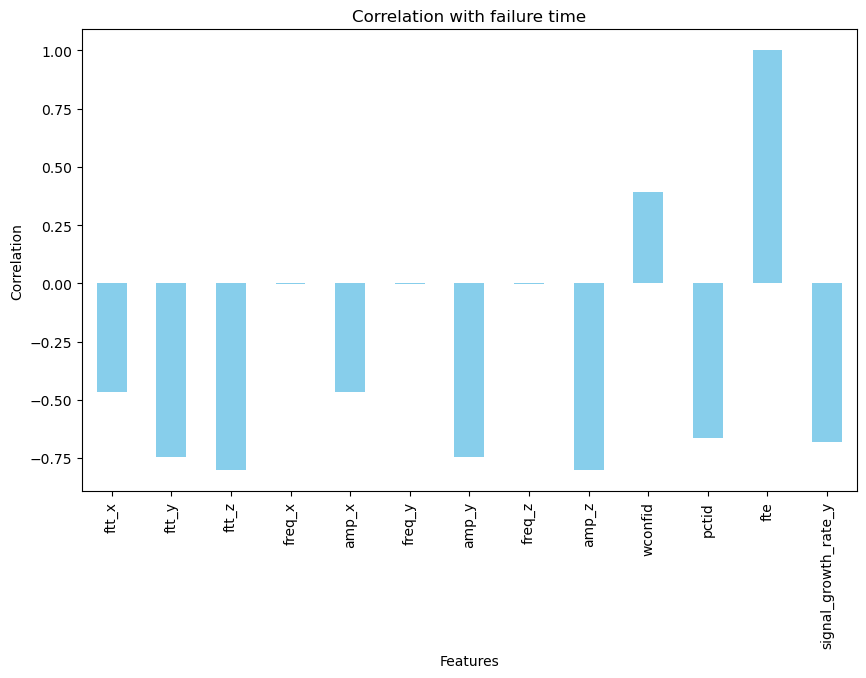

In [25]:
plt.figure(figsize=(10, 6))
final_data.corr()['fte'][:-1].plot(kind='bar', color='skyblue')
plt.title('Correlation with failure time')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.show()


<Figure size 1200x800 with 0 Axes>

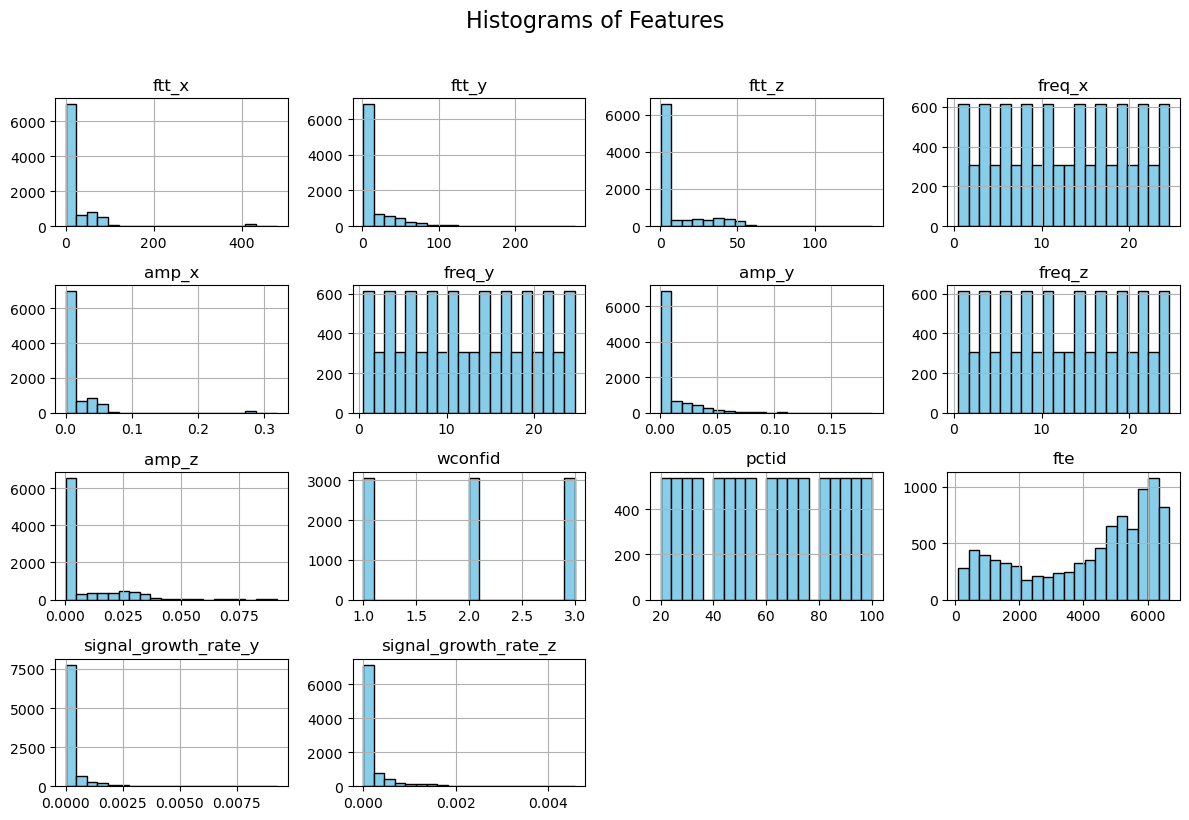

<Figure size 1200x800 with 0 Axes>

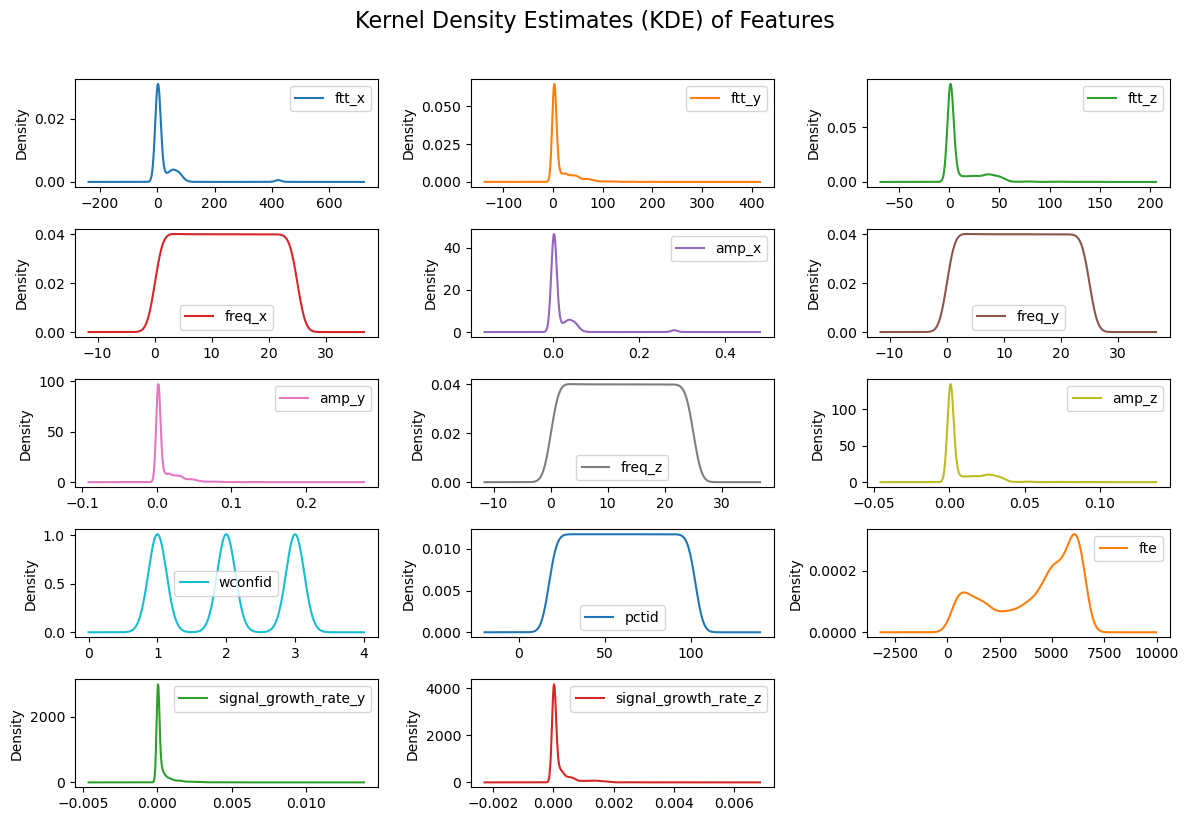

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histograms
plt.figure(figsize=(12, 8))
final_data.hist(figsize=(12, 8), bins=20, color='skyblue', edgecolor='black')
plt.suptitle('Histograms of Features', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# KDEs
num_features = len(final_data.columns)
num_rows = (num_features + 2) // 3  # Calculate the number of rows required for subplots
plt.figure(figsize=(12, 8))
final_data.plot(kind='kde', subplots=True, layout=(num_rows, 3), figsize=(12, 8), sharex=False, sharey=False)
plt.suptitle('Kernel Density Estimates (KDE) of Features', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


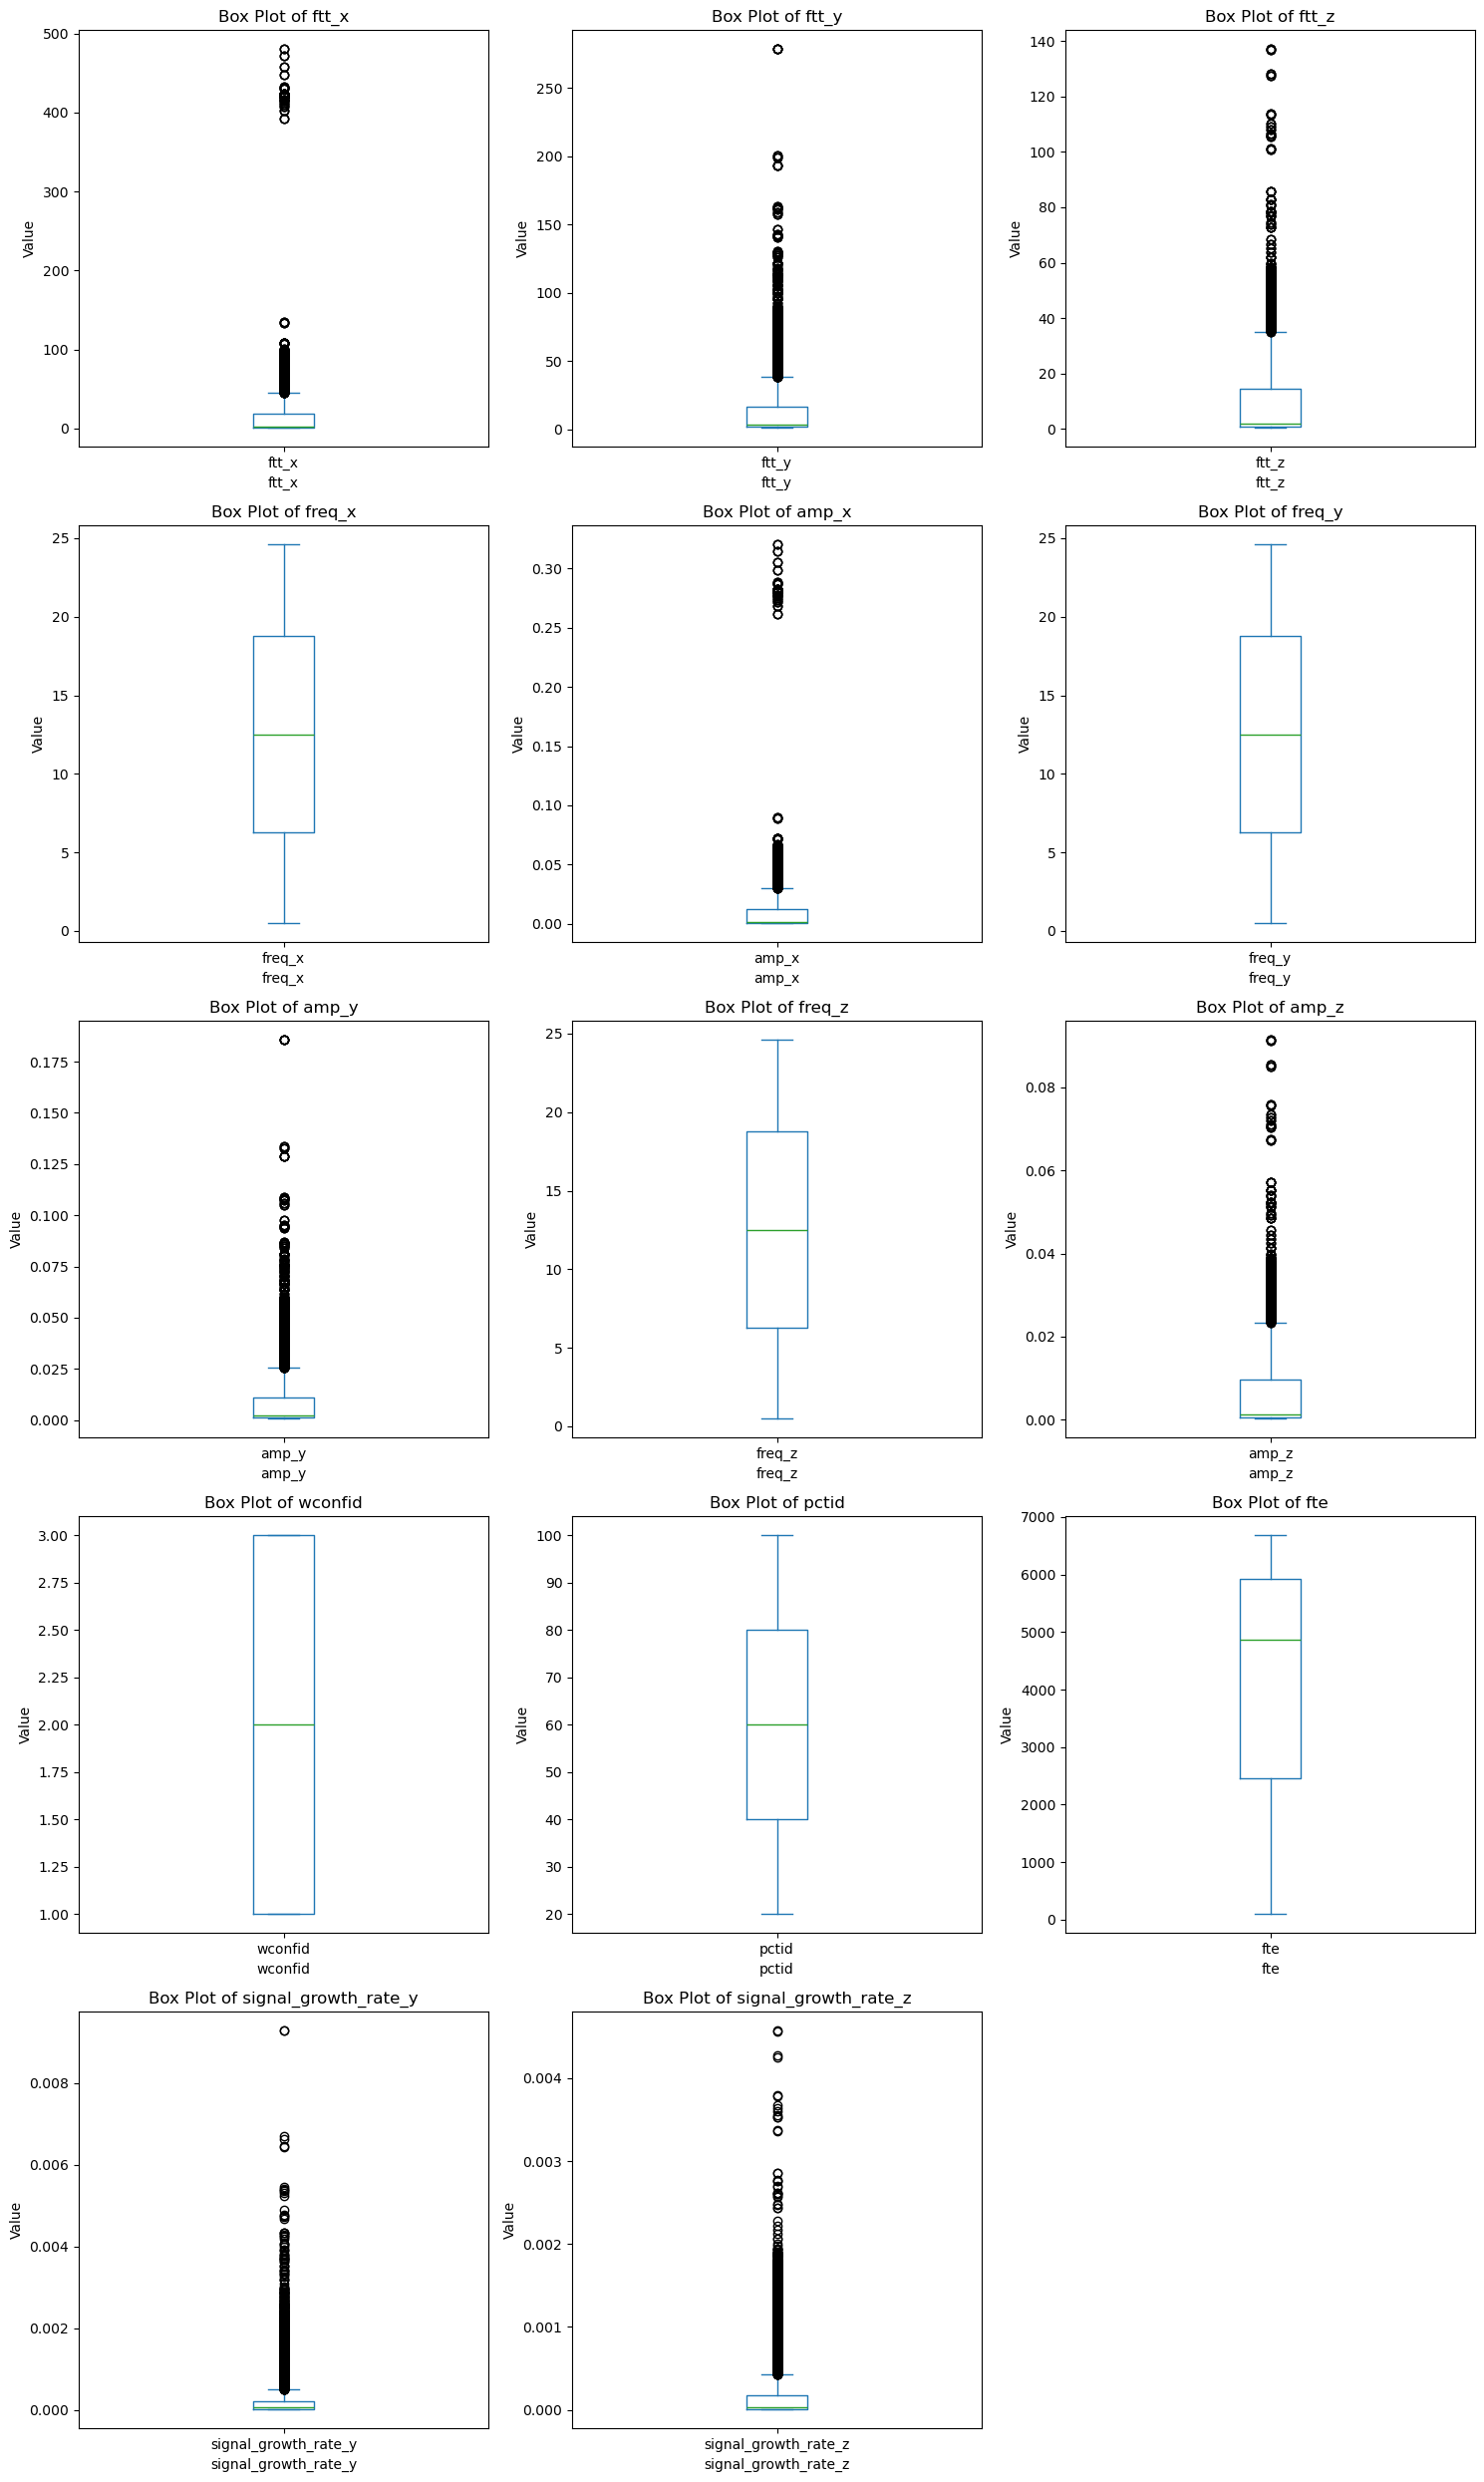

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Determine the number of features and calculate the layout for subplots
num_features = len(final_data.columns)
num_cols = 3
num_rows = (num_features + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate through each feature and plot its box plot
for i, feature in enumerate(final_data.columns):
    final_data[feature].plot(kind='box', ax=axes[i])
    axes[i].set_title(f'Box Plot of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Value')

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

# Adjust layout and display
plt.tight_layout()
plt.show()


D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


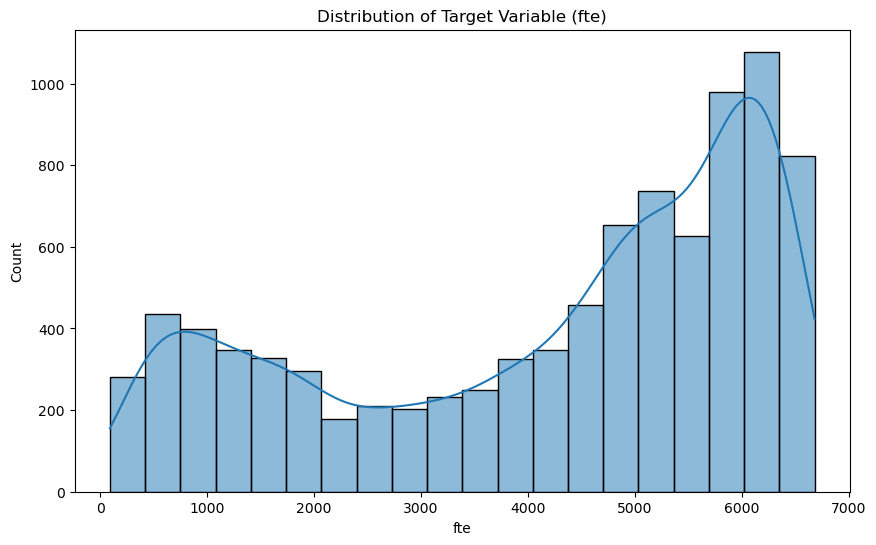

In [28]:
plt.figure(figsize=(10, 6))
sns.histplot(final_data['fte'], kde=True)
plt.title('Distribution of Target Variable (fte)')
plt.xlabel('fte')
plt.show()


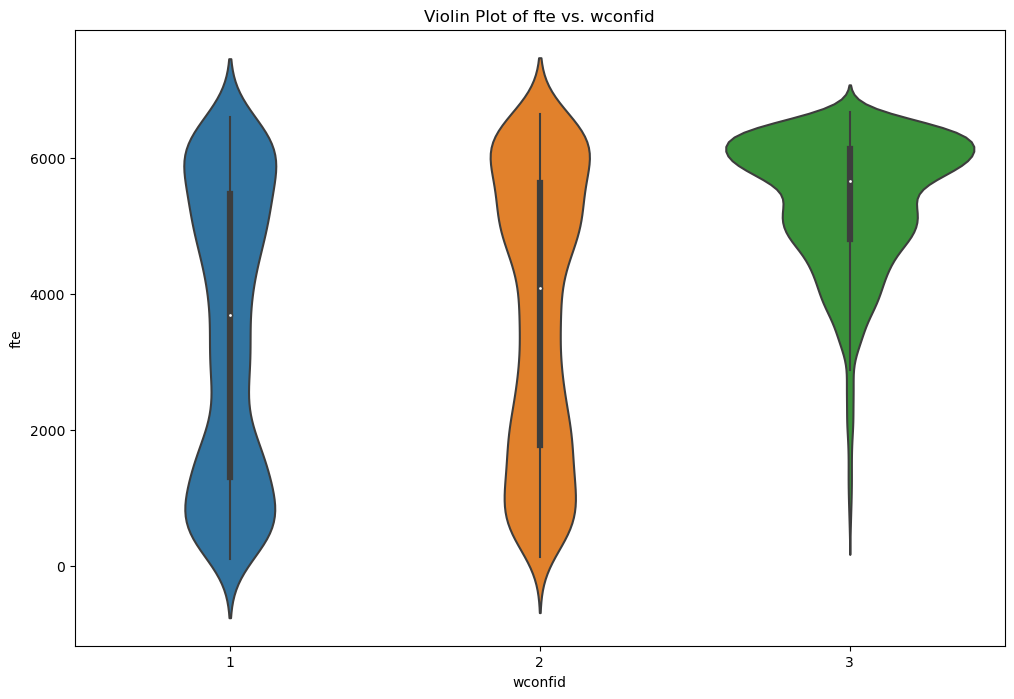

In [29]:
plt.figure(figsize=(12, 8))
sns.violinplot(x='wconfid', y='fte', data=final_data)
plt.title('Violin Plot of fte vs. wconfid')
plt.show()


In [30]:
from sklearn.cross_decomposition import PLSRegression

pls = PLSRegression(n_components=4)  # For example, reduce to 2 dimensions

pls.fit(final_data.drop('fte', axis=1), final_data['fte'])

abs_loadings = np.abs(pls.x_loadings_[:, 0])

best_attribute_indices = abs_loadings.argsort()[-4:][::-1]

best_attributes_names = final_data.drop('fte', axis=1).columns[best_attribute_indices]

print("Best attributes names from PLS Regression:")
print(best_attributes_names)


Best attributes names from PLS Regression:
Index(['ftt_z', 'amp_z', 'amp_y', 'ftt_y'], dtype='object')


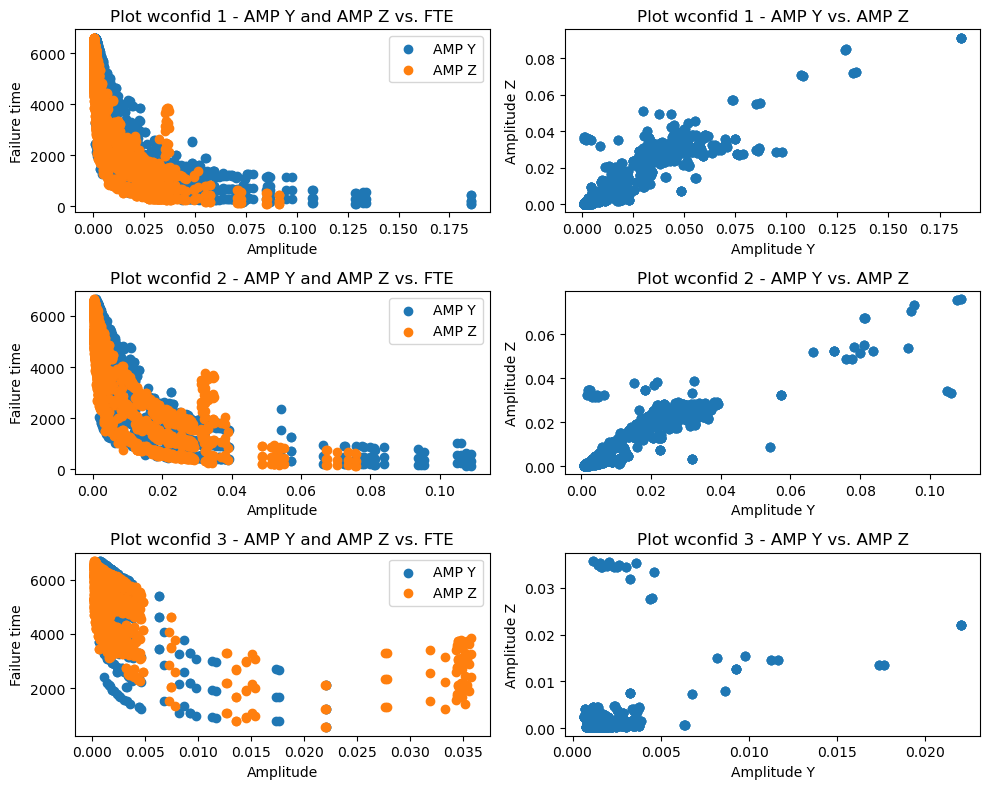

In [31]:
fig, axs = plt.subplots(3, 2, figsize=(10, 8))

for i, wconfid in enumerate(np.unique(final_data['wconfid'])):
    portion = final_data[final_data['wconfid'] == wconfid]

    axs[i, 0].scatter(portion["amp_y"], portion["fte"], label="AMP Y")
    axs[i, 0].scatter(portion["amp_z"], portion["fte"], label="AMP Z")
    axs[i, 0].set_xlabel("Amplitude")
    axs[i, 0].set_ylabel("Failure time")
    axs[i, 0].legend(loc="upper right")
    axs[i, 0].set_title(f"Plot wconfid {wconfid} - AMP Y and AMP Z vs. FTE")

    axs[i, 1].scatter(portion["amp_y"], portion["amp_z"])
    axs[i, 1].set_xlabel("Amplitude Y")
    axs[i, 1].set_ylabel("Amplitude Z")
    axs[i, 1].set_title(f"Plot wconfid {wconfid} - AMP Y vs. AMP Z")

plt.tight_layout()

plt.show()


In [32]:
def ploter(x,y,y_test,y_pred,c):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    scatter1 = axes[0].scatter(x,y, c=y_test,cmap=c)
    axes[0].set_xlabel("Amplitude Y")
    axes[0].set_ylabel("Amplitude Z")
    axes[0].set_title("True Failure")
    axes[0].legend(handles=[scatter1.legend_elements()[0][0]], labels=["True Failure"])
    axes[0].grid(True)

    scatter2 = axes[1].scatter(x,y, c=y_pred,cmap=c)
    axes[1].set_xlabel("Amplitude Y")
    axes[1].set_ylabel("Amplitude Z")
    axes[1].set_title("Predicted Failure")
    axes[1].legend(handles=[scatter2.legend_elements()[0][0]], labels=["Predicted Failure"])
    axes[1].grid(True)

    cbar1 = fig.colorbar(scatter1, ax=axes[0], orientation='vertical')
    cbar1.set_label("Failure Status")
    cbar2 = fig.colorbar(scatter2, ax=axes[1], orientation='vertical')
    cbar2.set_label("Failure Status")

    plt.tight_layout()
    plt.show()


For Classification Dataset

In [33]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc,accuracy_score

![image.png](attachment:52346149-f5e5-45bd-ad6f-8f090bdbd680.png)

if RPM is <600 or >1900 we consider the fan "failed"

<img src="https://www.dosupply.com/tech/wp-content/uploads/2021/10/image-33-768x62.png"></img>

where F is the frequency (Hz) of the supply voltage and P is the number of poles.

![image.png](attachment:f2977cf0-7222-4eab-8b51-3d1ab3b21460.png)

![image.png](attachment:7f4c8f3c-f4e1-4e79-83d7-11c820f94385.png)

In [34]:

def rmp(freq, n):
    result = np.zeros(len(freq["x"]) //  n) 
    for i in range(0, len(freq["x"]),  n):
        dominant_y = np.max(freq["y"][i:i+ n])
        dominant_z = np.max(freq["z"][i:i+ n])
        dominant = max(dominant_y, dominant_z)
        result[i //  n] = 120 * dominant / 3
    return result


In [35]:


df = pd.DataFrame({
    'ftt_y': data["ftt_y"],
    'ftt_z': data["ftt_z"],
    'freq_z': data['freq_z'],
    'freq_y': data['freq_y'],
    'amp_y': data['amp_y'],
    'amp_z': data['amp_z'],
    'wconfid': data['wconfid'],
    'pctid': data['pctid'],
})

RPM = rmp(freq_dict,num_points_window)#[(120 * np.abs(np.max([processed['freq_y'][i], processed['freq_z'][i], processed['freq_x'][i]]))) / 3 for i in range(len(df))]


In [36]:
min_threshold = 600
max_threshold = 1900
failed = [] # -1 yes -0 no
for i in range(len(df)) :
    failed.append( 0 if RPM[i]<min_threshold or RPM[i]>max_threshold else 1)

In [37]:
df["failed"] = failed

In [38]:
print(np.unique(failed,return_counts=True)[1])
print("Fail : 1\nN Fail : 0")

[1785 1275]
Fail : 1
N Fail : 0


In [39]:
df_c = df

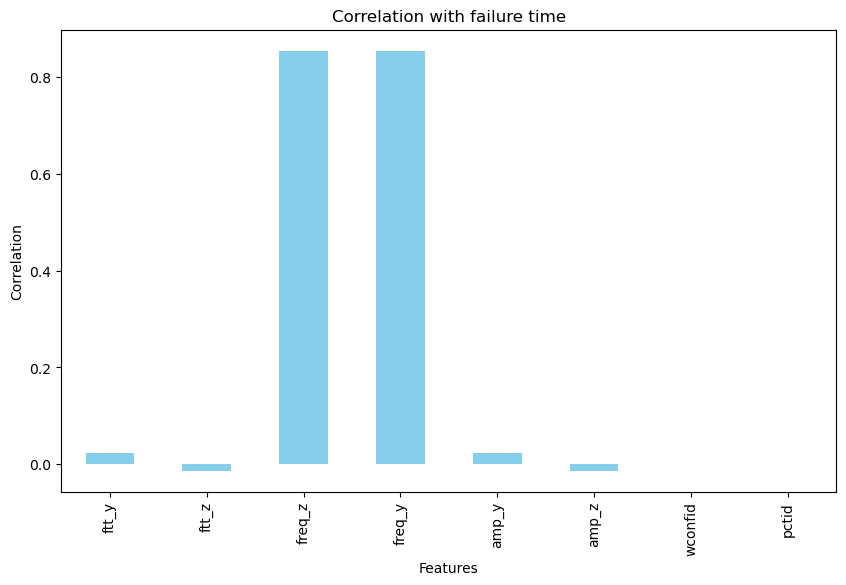

In [40]:
plt.figure(figsize=(10, 6))
df_c.corr()['failed'][:-1].plot(kind='bar', color='skyblue')
plt.title('Correlation with failure time')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.show()


In [41]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier()

rf_classifier.fit(df_c.drop(columns=["failed"],axis=1), df_c["failed"])

feature_importances = rf_classifier.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': df_c.drop(columns=["failed"],axis=1).columns,
    'Importance': feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importance_df)


Feature Importances:
   Feature  Importance
3   freq_y    0.502310
2   freq_z    0.457909
4    amp_y    0.009521
5    amp_z    0.009425
0    ftt_y    0.008449
1    ftt_z    0.007822
7    pctid    0.003156
6  wconfid    0.001407


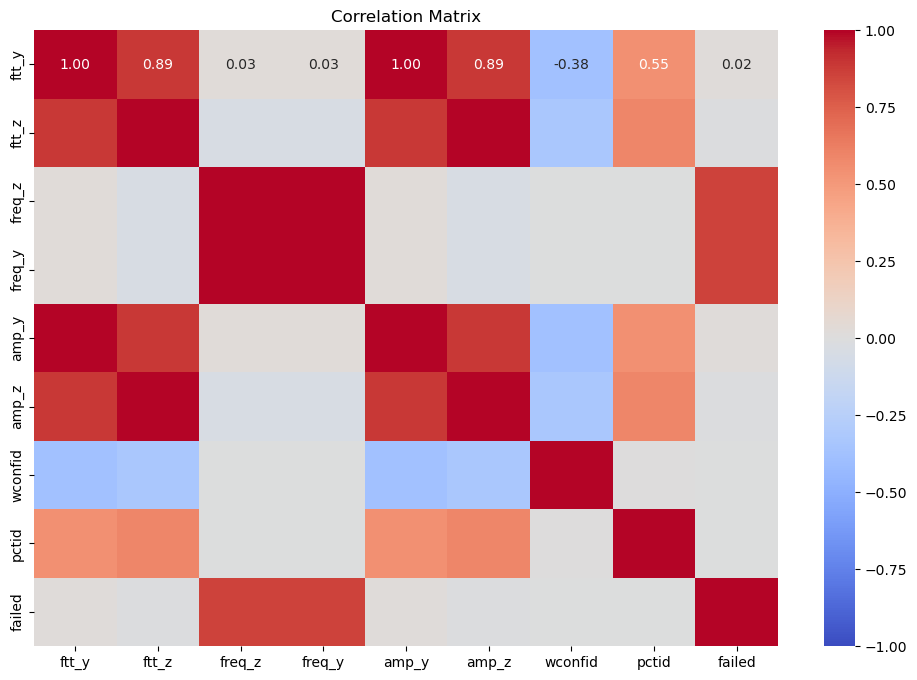

In [42]:
import seaborn as sns

correlation_matrix = df_c.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()


In [43]:
print(np.corrcoef(df_c["freq_z"], df_c["freq_y"])[0, 1])

1.0


In [44]:
def RMSE(true,pred):
    """
    where n represents the number of observations compared; 𝑥′𝑖
    the value of the i-th element of the predicted results vector; and 𝑥𝑖
    the value of the i-th element of the test dataset estimated values vector.
    """
    return np.sqrt(np.mean((true-pred)**2))

# Training

In [45]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [46]:
grouped_data = df_c.groupby('wconfid')

test_sets = []

for name, group in grouped_data:
    if name == 2:
        test_sets.append(group)

test_df = pd.concat(test_sets)

df_train = df_c.drop(test_df.index)

x_train_c = df_train.drop(columns=['failed', 'freq_y', 'pctid', 'wconfid'])
y_train_c = df_train['failed']
x_test_c = test_df.drop(columns=['failed', 'freq_y', 'pctid', 'wconfid'])
y_test_c = test_df['failed']

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_c)
x_test_scaled = scaler.transform(x_test_c)

x_train_c = pd.DataFrame(x_train_scaled, columns=x_train_c.columns)
x_test_c = pd.DataFrame(x_test_scaled, columns=x_test_c.columns)


y_train_c = y_train_c.values.ravel()
y_test_c = y_test_c.values.ravel()


In [47]:

columns_to_drop = ['fte', 'ftt_y', 'ftt_z', 'ftt_x', 'wconfid', 'pctid', 'amp_x', 'freq_x', 'freq_y', 'freq_z']
x_train = final_data.drop(columns=columns_to_drop)
y_train = final_data['fte']

x_test = test_data.drop(columns=columns_to_drop)
y_test = test_data['fte']

x_scaler = StandardScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_train.columns)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=x_test.columns)

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).ravel()


### 1.Regression

#### Decision Tree Learning

In [53]:
x_test.head()

amp_y     amp_z  signal_growth_rate_y  signal_growth_rate_z
0  0.001535  0.037068              0.000061              0.001483
1  0.001968  0.000333              0.000079              0.000013
2  0.001677  0.000257              0.000067              0.000010
3  0.002545  0.000266              0.000102              0.000011
4  0.002007  0.000229              0.000080              0.000009

In [54]:
# Initialize and train the Decision Tree model
# Specify parameters for Decision Tree model
tree_params = {
    'max_depth': 30,
    'min_samples_split': 3,
    'min_samples_leaf': 3,
    'random_state': 42
}

# Initialize and train the Decision Tree model with specified parameters
tree_model = DecisionTreeRegressor(**tree_params)
tree_model.fit(x_train, y_train)


DecisionTreeRegressor(max_depth=30, min_samples_leaf=3, min_samples_split=3,
                      random_state=42)

In [55]:
# Predictions on training data
y_train_pred_DT = tree_model.predict(x_train)

# Calculate metrics for training data
train_mae = mean_absolute_error(y_train, y_train_pred_DT)
train_mse = mean_squared_error(y_train, y_train_pred_DT)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred_DT)

print(f"Training set MAE: {train_mae:.4f}")
print(f"Training set RMSE: {train_rmse:.4f}")
print(f"Training set R²: {train_r2:.4f}")


Training set MAE: 0.0044
Training set RMSE: 0.0077
Training set R²: 0.9999


In [56]:
# Predictions on testing data
y_test_pred_DT = tree_model.predict(x_test)

# Calculate metrics for testing data
test_mae = mean_absolute_error(y_test, y_test_pred_DT)
test_mse = mean_squared_error(y_test, y_test_pred_DT)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred_DT)

print(f"Testing set MAE: {test_mae:.4f}")
print(f"Testing set RMSE: {test_rmse:.4f}")
print(f"Testing set R²: {test_r2:.4f}")


Testing set MAE: 0.0225
Testing set RMSE: 0.0348
Testing set R²: 0.9987


In [57]:
# Perform 5-fold cross-validation
cv_scores_r2 = cross_val_score(tree_model, x_test, y_test, cv=5, scoring='r2')

# Calculate the mean and standard deviation of the cross-validation R² scores
cv_r2 = cv_scores_r2.mean()
cv_std_r2 = cv_scores_r2.std()

print(f"Cross-Validation R²: {cv_r2:.4f} (± {cv_std_r2:.4f})")


Cross-Validation R²: 0.9972 (± 0.0013)


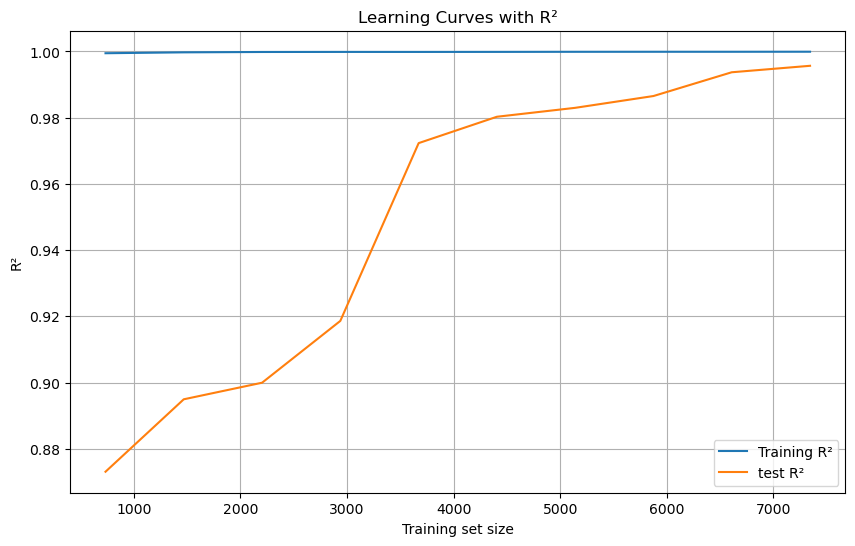

In [58]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(tree_model, x_train, y_train, cv=5, scoring='r2', train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean_r2 = train_scores.mean(axis=1)
test_scores_mean_r2 = test_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean_r2, label='Training R²')
plt.plot(train_sizes, test_scores_mean_r2, label='test R²')
plt.xlabel('Training set size')
plt.ylabel('R²')
plt.title('Learning Curves with R²')
plt.legend()
plt.grid(True)
plt.show()


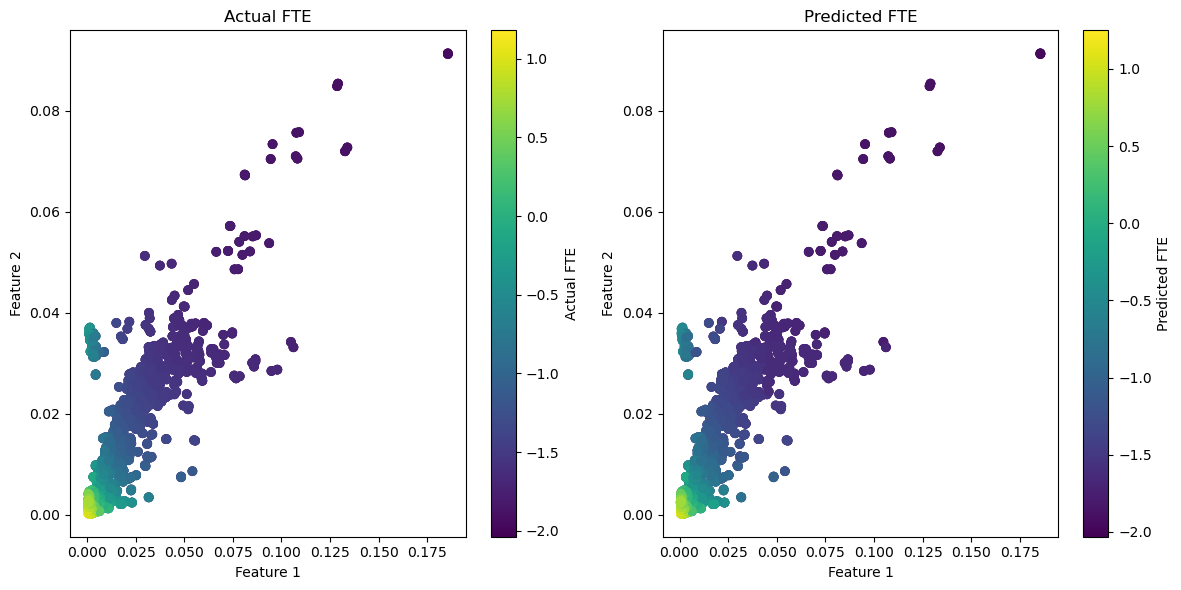

In [59]:
# Define the ploter function
def ploter(x1, x2, y_test, y_pred, cmap):
    plt.figure(figsize=(12, 6))

    # Actual values plot
    plt.subplot(1, 2, 1)
    plt.scatter(x1, x2, c=y_test, cmap=cmap)
    plt.colorbar(label='Actual FTE')
    plt.title('Actual FTE')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

    # Predicted values plot
    plt.subplot(1, 2, 2)
    plt.scatter(x1, x2, c=y_pred, cmap=cmap)
    plt.colorbar(label='Predicted FTE')
    plt.title('Predicted FTE')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

    plt.tight_layout()
    plt.show()

# Use the ploter function for the Decision Tree results
ploter(x_test.iloc[:, 0], x_test.iloc[:, 1], y_test, y_test_pred_DT, "viridis")

#### Random Forest

In [60]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train the Random Forest model
forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
forest_model.fit(x_train, y_train)


RandomForestRegressor(random_state=42)

In [61]:
# Predictions on training data for Random Forest
y_train_pred_forest = forest_model.predict(x_train)

# Calculate metrics for training data for Random Forest
train_mae_forest = mean_absolute_error(y_train, y_train_pred_forest)
train_mse_forest = mean_squared_error(y_train, y_train_pred_forest)
train_rmse_forest = np.sqrt(train_mse_forest)
train_r2_forest = r2_score(y_train, y_train_pred_forest)

print(f"Training set MAE for Random Forest: {train_mae_forest:.4f}")
print(f"Training set RMSE for Random Forest: {train_rmse_forest:.4f}")
print(f"Training set R² for Random Forest: {train_r2_forest:.4f}")


Training set MAE for Random Forest: 0.0015
Training set RMSE for Random Forest: 0.0028
Training set R² for Random Forest: 1.0000


In [62]:
# Predictions on testing data for Random Forest
y_test_pred_forest = forest_model.predict(x_test)

# Calculate metrics for testing data for Random Forest
test_mae_forest = mean_absolute_error(y_test, y_test_pred_forest)
test_mse_forest = mean_squared_error(y_test, y_test_pred_forest)
test_rmse_forest = np.sqrt(test_mse_forest)
test_r2_forest = r2_score(y_test, y_test_pred_forest)

print(f"\nTesting set MAE for Random Forest: {test_mae_forest:.4f}")
print(f"Testing set RMSE for Random Forest: {test_rmse_forest:.4f}")
print(f"Testing set R² for Random Forest: {test_r2_forest:.4f}")



Testing set MAE for Random Forest: 0.0108
Testing set RMSE for Random Forest: 0.0175
Testing set R² for Random Forest: 0.9997


In [63]:
# Perform 5-fold cross-validation
cv_scores_r2 = cross_val_score(forest_model, x_test, y_test, cv=5, scoring='r2')

# Calculate the mean and standard deviation of the cross-validation R² scores
cv_r2 = cv_scores_r2.mean()
cv_std_r2 = cv_scores_r2.std()

print(f"Cross-Validation R²: {cv_r2:.4f} (± {cv_std_r2:.4f})")

Cross-Validation R²: 0.9987 (± 0.0007)


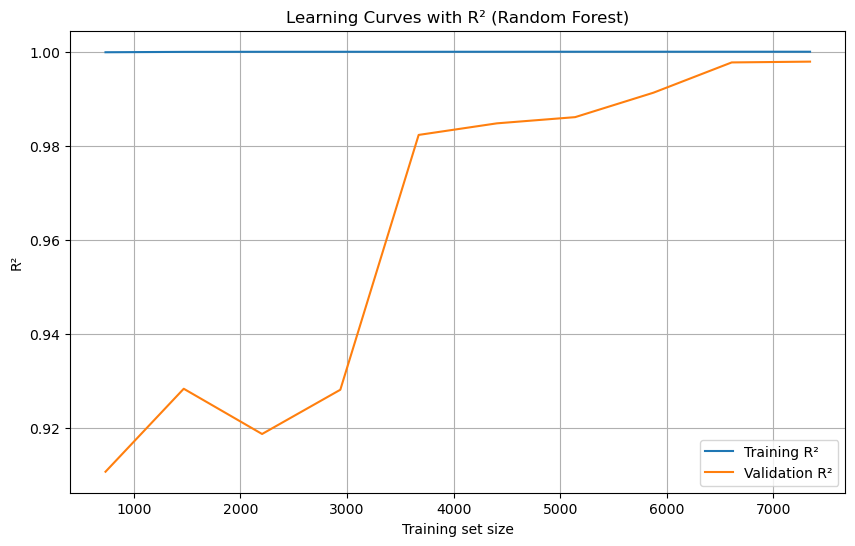

In [65]:
train_sizes_forest, train_scores_forest, test_scores_forest = learning_curve(forest_model, x_train, y_train, cv=5, scoring='r2', train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean_r2_forest = train_scores_forest.mean(axis=1)
test_scores_mean_r2_forest = test_scores_forest.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes_forest, train_scores_mean_r2_forest, label='Training R²')
plt.plot(train_sizes_forest, test_scores_mean_r2_forest, label='Validation R²')
plt.xlabel('Training set size')
plt.ylabel('R²')
plt.title('Learning Curves with R² (Random Forest)')
plt.legend()
plt.grid(True)
plt.show()


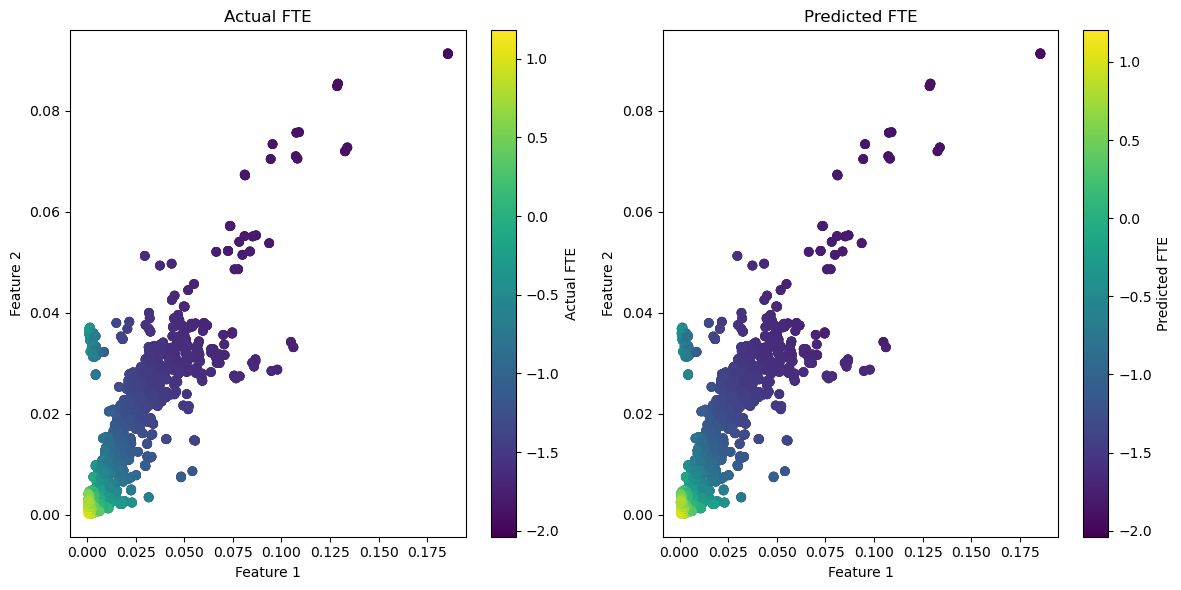

In [66]:
ploter(x_test.iloc[:, 0], x_test.iloc[:, 1], y_test, y_test_pred_forest, "viridis")

#### KNN

The actual vs. predicted plot for the KNN model reveals a systematic bias, with the model consistently underpredicting or overpredicting in certain ranges. This bias stems from the model's inability to capture non-linear relationships, as shown by the curvature and spread of the predicted values. Errors are more significant for medium values, decreasing at higher and lower ranges, indicating better performance at the extremes but struggles with medium values. The overpredicted and underpredicted data points are equally distributed due to the way test and training data are generated :  duplication of amp_y and amp_z across all growth rates, which diminishes their impact on distance calculations. The test data, simulated with growth rates of 0.015, 0.03, and 0.04, are close to training growth rates of 0.01, 0.02, and 0.05. Consequently, scenarios generated with 0.015 are underpredicted with 0.01, and those with 0.04 are overpredicted with 0.05. This highlights the limitations of KNN, as it relies on the values of neighbors, which do not align with our data. Different growth rates represent different failure scenarios, necessitating a pattern-based approach rather than value-based, to avoid over or underestimation. Additionally, more neighbors lead to higher error due to the distance metric's inadequacy in indicating scenario similarity, introducing less similar failure scenarios and increasing variation in failure times, causing larger deviations from the real values.

Best k: 4
Training Error (Best k) - RMSE: 0.14940687793279467
Training Error (Best k) - MAE: 0.10799788840748277
Training Error (Best k) - R^2: 0.977677584826375
Test Error (Best k) - RMSE: 0.15625781297756802
Test Error (Best k) - MAE: 0.12057513453734811
Test Error (Best k) - R^2: 0.9746333617622427


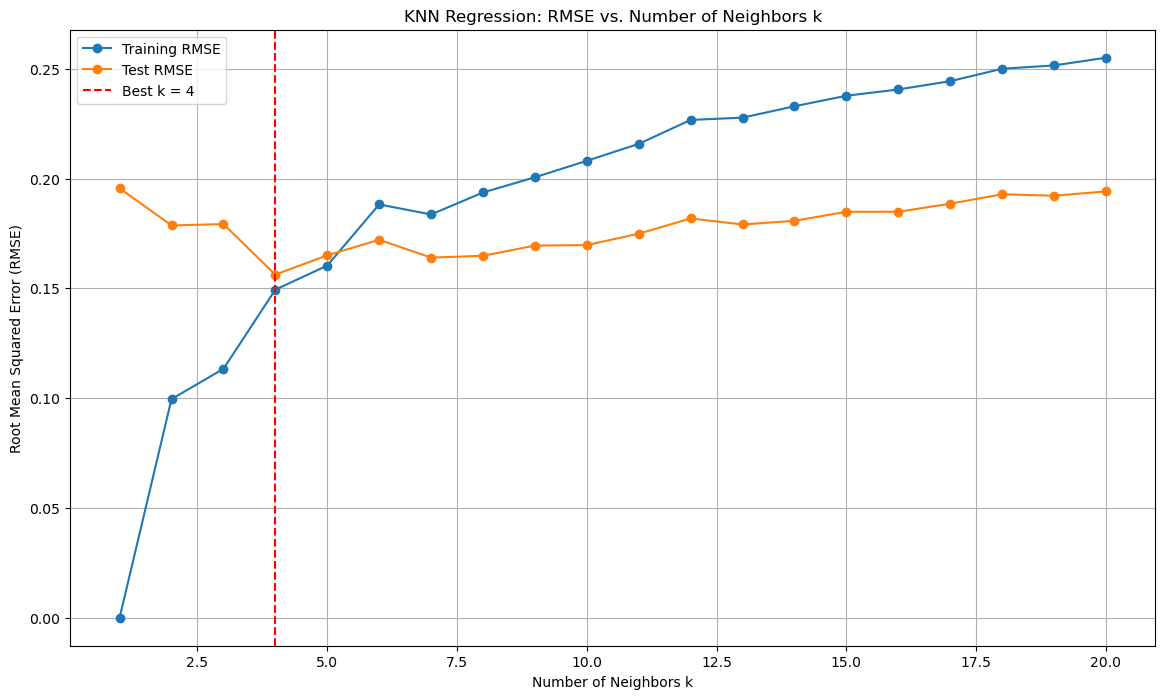

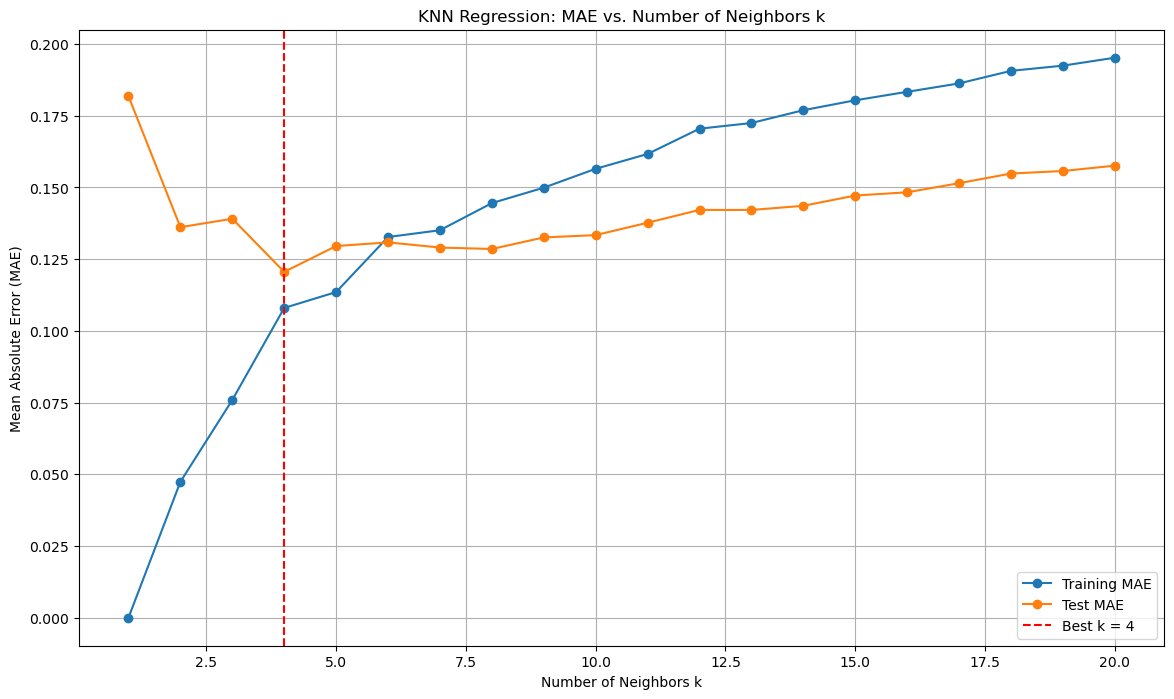

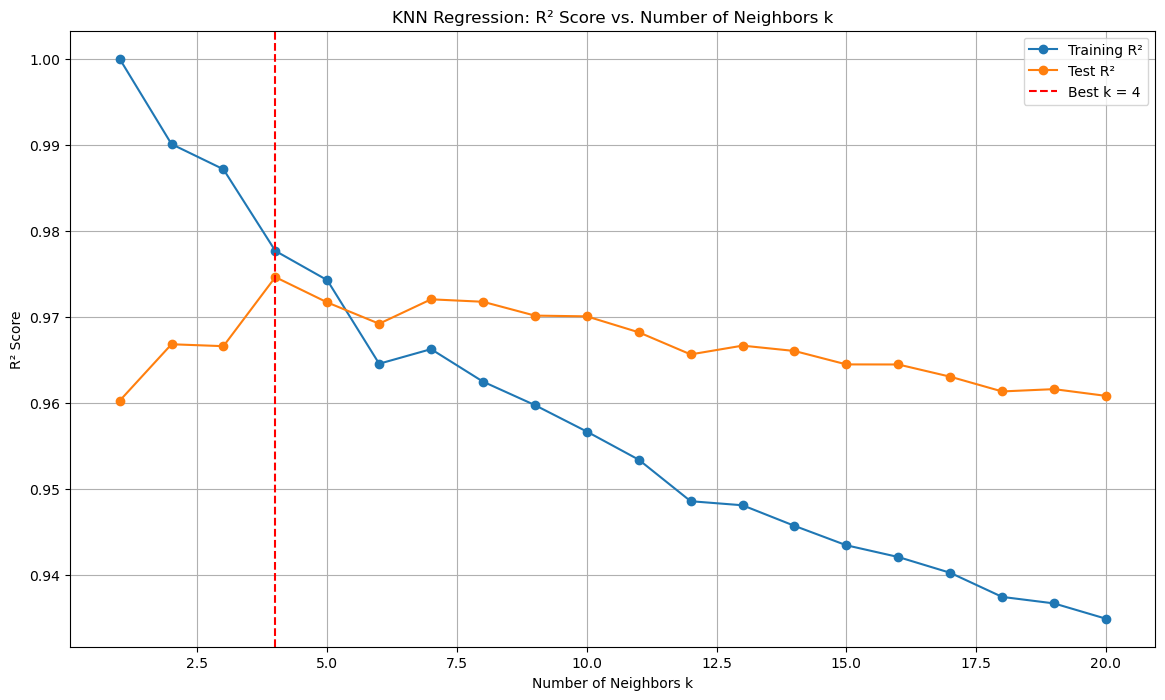

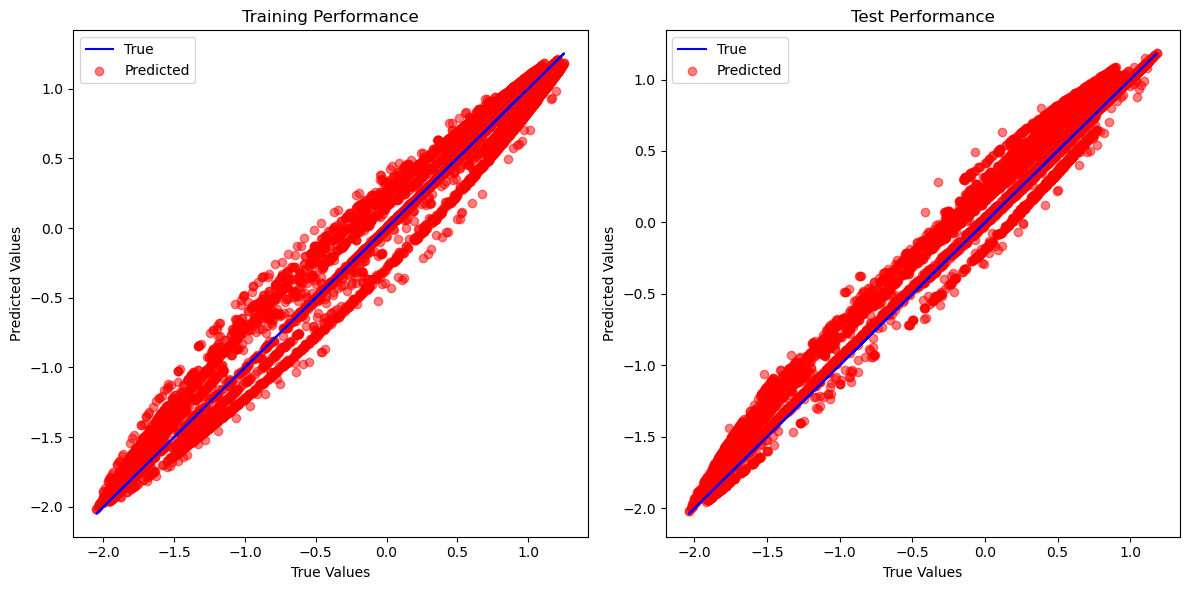

In [67]:
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

def tune_knn_and_plot_errors(x_train, x_test, y_train, y_test, max_k=20):
    train_errors_rmse = []
    test_errors_rmse = []
    train_errors_mae = []
    test_errors_mae = []
    train_r2_scores = []
    test_r2_scores = []

    k_values = range(1, max_k + 1)

    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors=k)

        knn.fit(x_train, y_train)

        y_train_pred = knn.predict(x_train)

        y_test_pred = knn.predict(x_test)

        mse_train = mean_squared_error(y_train, y_train_pred)
        rmse_train = np.sqrt(mse_train)
        mae_train = mean_absolute_error(y_train, y_train_pred)
        r2_train = r2_score(y_train, y_train_pred)

        mse_test = mean_squared_error(y_test, y_test_pred)
        rmse_test = np.sqrt(mse_test)
        mae_test = mean_absolute_error(y_test, y_test_pred)
        r2_test = r2_score(y_test, y_test_pred)

        train_errors_rmse.append(rmse_train)
        test_errors_rmse.append(rmse_test)
        train_errors_mae.append(mae_train)
        test_errors_mae.append(mae_test)
        train_r2_scores.append(r2_train)
        test_r2_scores.append(r2_test)

    best_k = k_values[np.argmin(test_errors_rmse)]

    print(f"Best k: {best_k}")
    print(f"Training Error (Best k) - RMSE: {train_errors_rmse[best_k - 1]}")
    print(f"Training Error (Best k) - MAE: {train_errors_mae[best_k - 1]}")
    print(f"Training Error (Best k) - R^2: {train_r2_scores[best_k - 1]}")
    print(f"Test Error (Best k) - RMSE: {test_errors_rmse[best_k - 1]}")
    print(f"Test Error (Best k) - MAE: {test_errors_mae[best_k - 1]}")
    print(f"Test Error (Best k) - R^2: {test_r2_scores[best_k - 1]}")

    plt.figure(figsize=(14, 8))
    plt.plot(k_values, train_errors_rmse, label='Training RMSE', marker='o')
    plt.plot(k_values, test_errors_rmse, label='Test RMSE', marker='o')
    plt.axvline(x=best_k, color='r', linestyle='--', label=f'Best k = {best_k}')
    plt.xlabel('Number of Neighbors k')
    plt.ylabel('Root Mean Squared Error (RMSE)')
    plt.title('KNN Regression: RMSE vs. Number of Neighbors k')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(14, 8))
    plt.plot(k_values, train_errors_mae, label='Training MAE', marker='o')
    plt.plot(k_values, test_errors_mae, label='Test MAE', marker='o')
    plt.axvline(x=best_k, color='r', linestyle='--', label=f'Best k = {best_k}')
    plt.xlabel('Number of Neighbors k')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('KNN Regression: MAE vs. Number of Neighbors k')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(14, 8))
    plt.plot(k_values, train_r2_scores, label='Training R²', marker='o')
    plt.plot(k_values, test_r2_scores, label='Test R²', marker='o')
    plt.axvline(x=best_k, color='r', linestyle='--', label=f'Best k = {best_k}')
    plt.xlabel('Number of Neighbors k')
    plt.ylabel('R² Score')
    plt.title('KNN Regression: R² Score vs. Number of Neighbors k')
    plt.legend()
    plt.grid(True)
    plt.show()

    best_knn = KNeighborsRegressor(n_neighbors=best_k)
    best_knn.fit(x_train, y_train)
    y_test_pred_best = best_knn.predict(x_test)
    y_train_pred_best = best_knn.predict(x_train)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(y_train, y_train, label='True', color='blue')
    plt.scatter(y_train, y_train_pred_best, label='Predicted', color='red', alpha=0.5)
    plt.title('Training Performance')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(y_test, y_test, label='True', color='blue')
    plt.scatter(y_test, y_test_pred_best, label='Predicted', color='red', alpha=0.5)
    plt.title('Test Performance')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return best_knn

best_knn_model = tune_knn_and_plot_errors(x_train, x_test, y_train, y_test)
y_pred_KNN = best_knn_model.predict(x_test)


### **linear regression**

**Comment on Linear Regression Results**:

The actual vs. predicted plot for the linear regression model reveals a significant pattern in the residuals, indicating that the model is not capturing the underlying relationship in the data effectively. The curved and spread-out pattern suggests that the linear model is oversimplifying the relationship, which likely involves non-linearities that the linear regression cannot account for. The spread and trend in residuals highlight the linear regression model's inadequacy in capturing the true complexity of the data. This indicates that more sophisticated models, possibly incorporating non-linear transformations or different modeling techniques, might be necessary to better fit and predict the data.

Linear Regression Training Error - RMSE: 0.5734885700550233
Linear Regression Training Error - MAE: 0.45686109253311274
Linear Regression Training Error - R^2 Score: 0.6711108600162446
Linear Regression Test Error - RMSE: 0.5458238830458823
Linear Regression Test Error - MAE: 0.4151938842002571
Linear Regression Test Error - R^2 Score: 0.6904830039955087


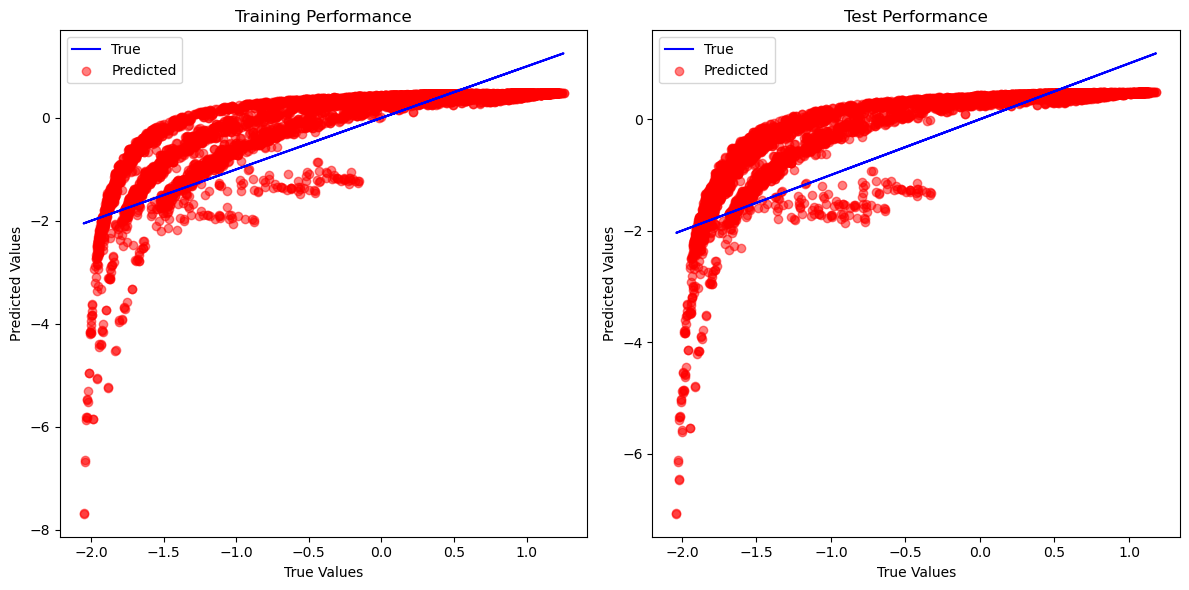

In [73]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

def evaluate_linear_regression(x_train, x_test, y_train, y_test):
    lr = LinearRegression()
    lr.fit(x_train, y_train)
    y_train_pred = lr.predict(x_train)

    y_test_pred = lr.predict(x_test)

    #  training errors
    mse_train = mean_squared_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mse_train)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)

    #  test errors
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mse_test)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)

    print("Linear Regression Training Error - RMSE:", rmse_train)
    print("Linear Regression Training Error - MAE:", mae_train)
    print("Linear Regression Training Error - R^2 Score:", r2_train)
    print("Linear Regression Test Error - RMSE:", rmse_test)
    print("Linear Regression Test Error - MAE:", mae_test)
    print("Linear Regression Test Error - R^2 Score:", r2_test)

    #  performance curves
    plt.figure(figsize=(12, 6))

    #  training performance
    plt.subplot(1, 2, 1)
    plt.plot(y_train, y_train, label='True', color='blue')
    plt.scatter(y_train, y_train_pred, label='Predicted', color='red', alpha=0.5)
    plt.title('Training Performance')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.legend()

    #  test performance
    plt.subplot(1, 2, 2)
    plt.plot(y_test, y_test, label='True', color='blue')
    plt.scatter(y_test, y_test_pred, label='Predicted', color='red', alpha=0.5)
    plt.title('Test Performance')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return lr

best_lr_model = evaluate_linear_regression(x_train, x_test, y_train, y_test)
y_pred_LR = best_lr_model.predict(x_test)


In [151]:
y_pred_LR = best_lr_model.predict(x_test)

### logarithmic **fit**

**Comment on Logarithmic Fit Results**:

The actual vs. predicted plot for the logarithmic fit model demonstrates an improved alignment compared to the linear regression model. The logarithmic fit captures the non-linear relationship in the data more effectively, reducing the curvature and spread observed in the residuals. However, there is still a noticeable deviation, especially at the lower range of the values, indicating that while the logarithmic fit performs better, it still doesn't fully capture the complexity of the data. This suggests that even more sophisticated non-linear models or additional feature transformations might be necessary to achieve a better fit and more accurate predictions.

Logarithmic Fit Model Training Error - RMSE: 0.1080124502079168
Logarithmic Fit Model Training Error - MAE: 0.07781976493302314
Logarithmic Fit Model Training Error - R^2: 0.9883333106000823
Logarithmic Fit Model Test Error - RMSE: 0.09708310215952405
Logarithmic Fit Model Test Error - MAE: 0.06915170904433401
Logarithmic Fit Model Test Error - R^2: 0.9902081055679315


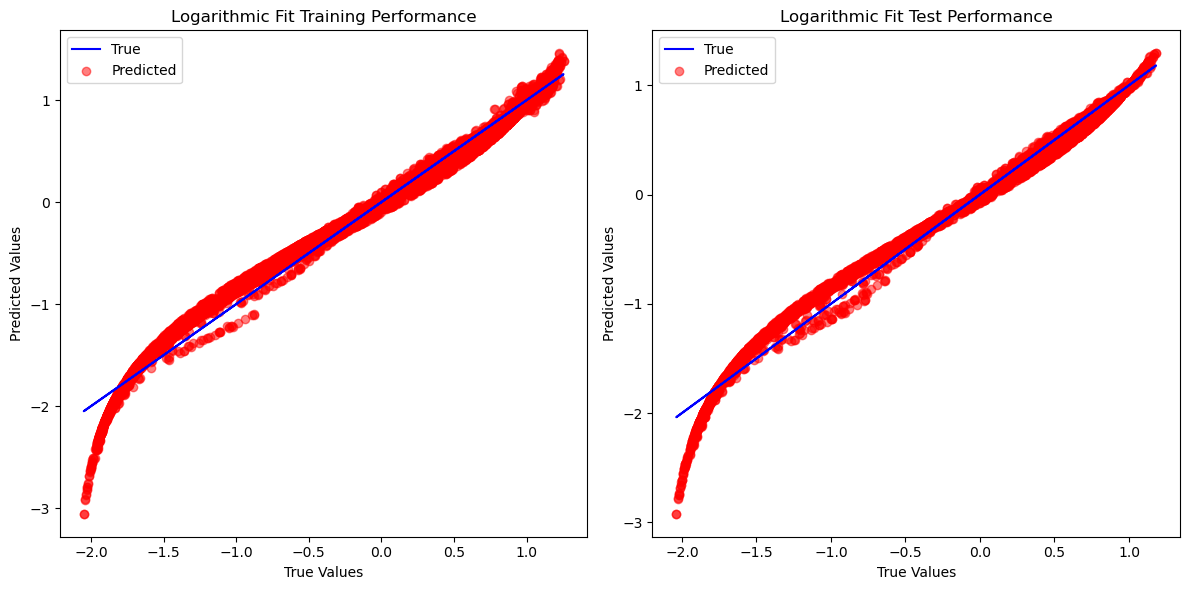

In [74]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Log transform the features
log_x_train = np.log(x_train + 1e-10)  # Adding a small constant to avoid log(0)
log_x_test = np.log(x_test + 1e-10)

# Fit the linear regression model on log-transformed features
log_model = LinearRegression()
log_model.fit(log_x_train, y_train)

# Predict on training and test data
y_train_pred_log = log_model.predict(log_x_train)
y_test_pred_log = log_model.predict(log_x_test)

# Calculate performance metrics
mse_train_log = mean_squared_error(y_train, y_train_pred_log)
rmse_train_log = np.sqrt(mse_train_log)
mae_train_log = mean_absolute_error(y_train, y_train_pred_log)
r2_train_log = r2_score(y_train, y_train_pred_log)

mse_test_log = mean_squared_error(y_test, y_test_pred_log)
rmse_test_log = np.sqrt(mse_test_log)
mae_test_log = mean_absolute_error(y_test, y_test_pred_log)
r2_test_log = r2_score(y_test, y_test_pred_log)

# Print performance metrics
print(f"Logarithmic Fit Model Training Error - RMSE: {rmse_train_log}")
print(f"Logarithmic Fit Model Training Error - MAE: {mae_train_log}")
print(f"Logarithmic Fit Model Training Error - R^2: {r2_train_log}")
print(f"Logarithmic Fit Model Test Error - RMSE: {rmse_test_log}")
print(f"Logarithmic Fit Model Test Error - MAE: {mae_test_log}")
print(f"Logarithmic Fit Model Test Error - R^2: {r2_test_log}")

#  predictions vs actual values for training and test data
plt.figure(figsize=(12, 6))

#  training performance
plt.subplot(1, 2, 1)
plt.plot(y_train, y_train, label='True', color='blue')
plt.scatter(y_train, y_train_pred_log, label='Predicted', color='red', alpha=0.5)
plt.title('Logarithmic Fit Training Performance')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()

#  test performance
plt.subplot(1, 2, 2)
plt.plot(y_test, y_test, label='True', color='blue')
plt.scatter(y_test, y_test_pred_log, label='Predicted', color='red', alpha=0.5)
plt.title('Logarithmic Fit Test Performance')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()

plt.tight_layout()
plt.show()


In [152]:
y_pred_LRF = y_test_pred_log

### plynomial **regression**

**Comment on Polynomial Regression Results**:

The actual vs. predicted plot for the polynomial regression model shows a significant improvement over the linear regression model. The polynomial model captures more of the non-linear relationships in the data, evidenced by the closer alignment of the predicted values to the true values. The spread of residuals is reduced, particularly for the higher values, indicating that the model is better at capturing the complexity of the data. Additionally, the curvature is less pronounced and more randomly distributed around the line compared to the linear regression and logarithmic fit models.This indicates it is the best model so far . but more sophisticated models or additional feature transformations might be necessary to achieve an even better fit and more accurate predictions.

Best degree: 7
Training Error (Best degree) - RMSE: 0.09499902834988315
Training Error (Best degree) - MAE: 0.07036556074976023
Training Error (Best degree) - R^2: 0.990975184612578
Test Error (Best degree) - RMSE: 0.09894861500834175
Test Error (Best degree) - MAE: 0.06508779127236251
Test Error (Best degree) - R^2: 0.9898281751887346


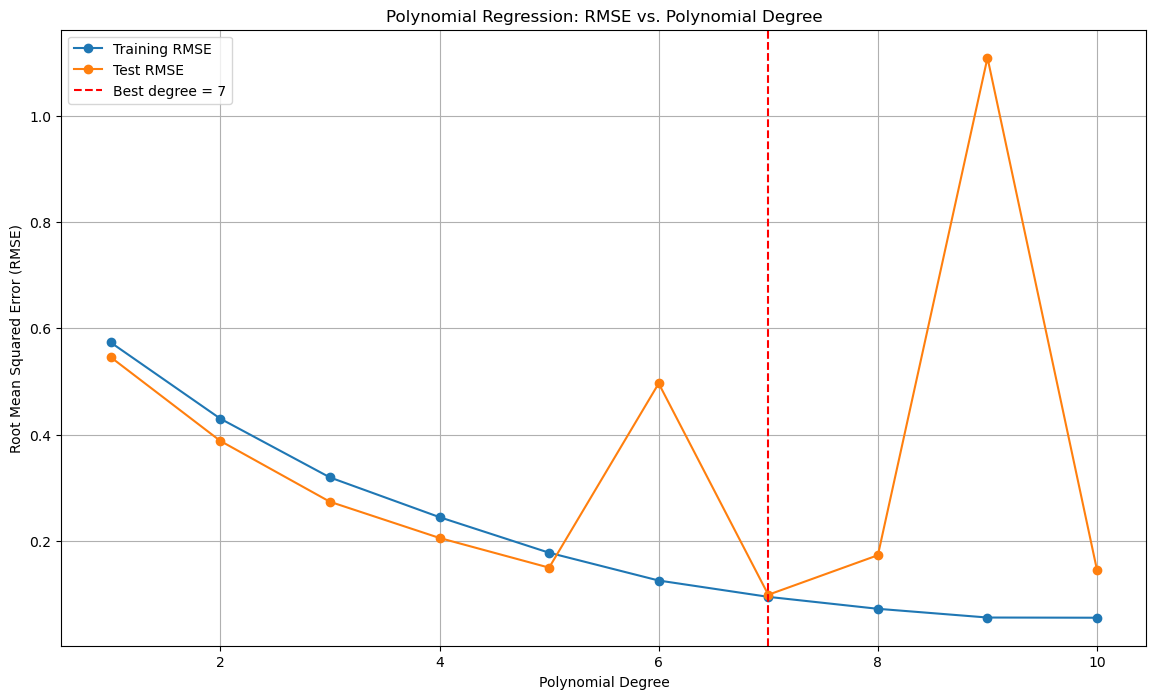

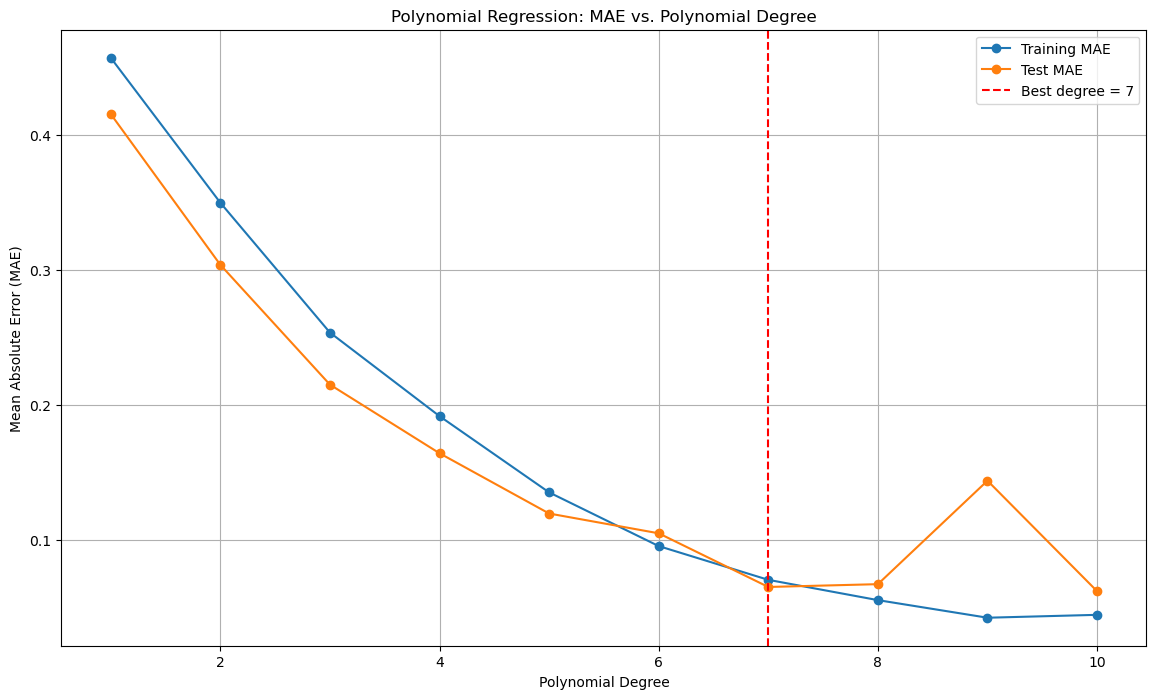

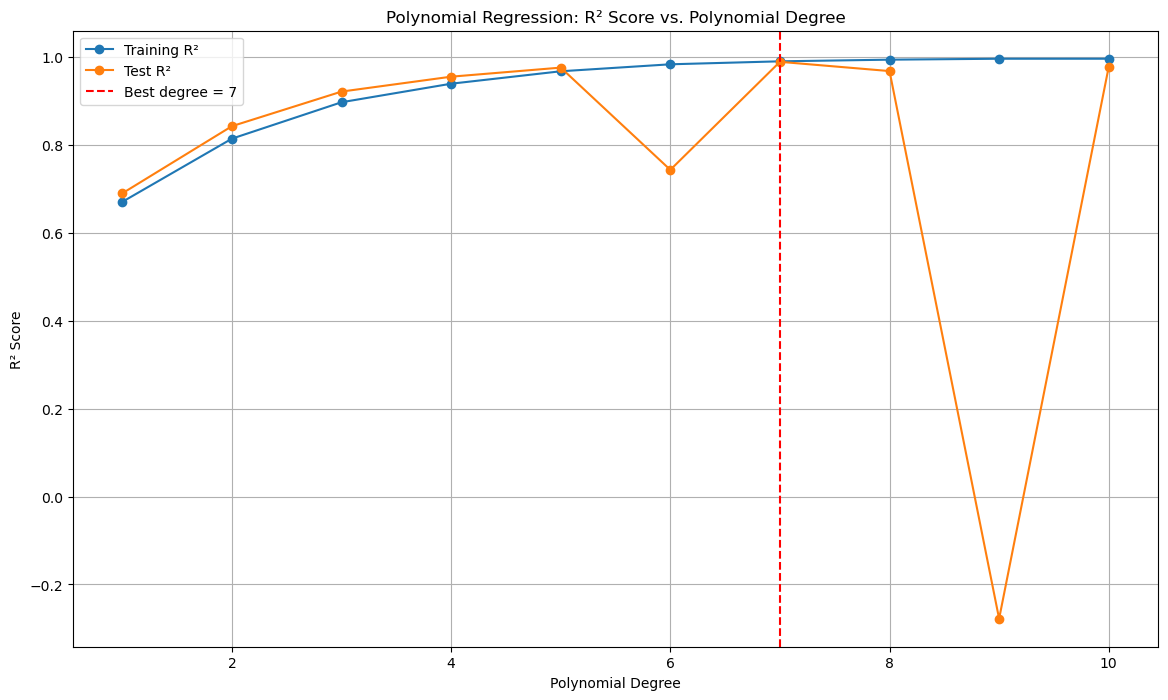

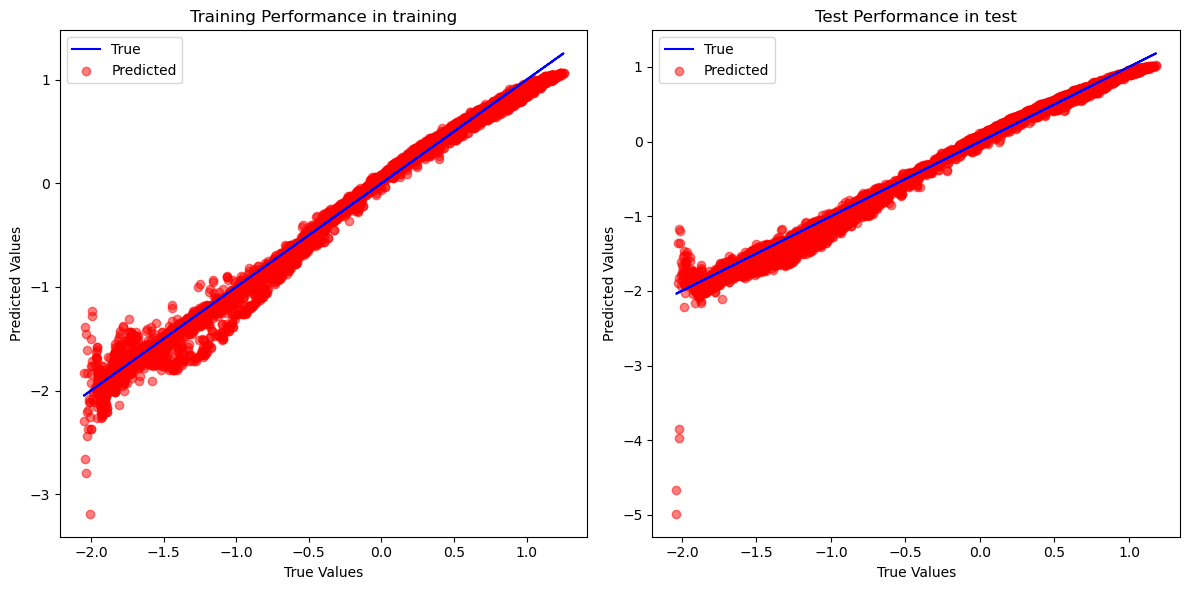

In [154]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

def tune_polynomial_regression_and_plot_errors(x_train, x_test, y_train, y_test, max_degree=10):
    train_errors_rmse = []
    test_errors_rmse = []
    train_errors_mae = []
    test_errors_mae = []
    train_r2_scores = []
    test_r2_scores = []

    # Range of polynomial degrees to test
    degrees = range(1, max_degree + 1)

    for degree in degrees:
        # Generate polynomial features
        poly = PolynomialFeatures(degree=degree)
        x_train_poly = poly.fit_transform(x_train)
        x_test_poly = poly.transform(x_test)

        model = LinearRegression()

        model.fit(x_train_poly, y_train)

        y_train_pred = model.predict(x_train_poly)

        y_test_pred = model.predict(x_test_poly)

        #  training errors
        mse_train = mean_squared_error(y_train, y_train_pred)
        rmse_train = np.sqrt(mse_train)
        mae_train = mean_absolute_error(y_train, y_train_pred)
        r2_train = r2_score(y_train, y_train_pred)

        #  test errors
        mse_test = mean_squared_error(y_test, y_test_pred)
        rmse_test = np.sqrt(mse_test)
        mae_test = mean_absolute_error(y_test, y_test_pred)
        r2_test = r2_score(y_test, y_test_pred)

        train_errors_rmse.append(rmse_train)
        test_errors_rmse.append(rmse_test)
        train_errors_mae.append(mae_train)
        test_errors_mae.append(mae_test)
        train_r2_scores.append(r2_train)
        test_r2_scores.append(r2_test)

    # Determine the best degree based on test RMSE
    best_degree = degrees[np.argmin(test_errors_rmse)]

    print(f"Best degree: {best_degree}")
    print(f"Training Error (Best degree) - RMSE: {train_errors_rmse[best_degree - 1]}")
    print(f"Training Error (Best degree) - MAE: {train_errors_mae[best_degree - 1]}")
    print(f"Training Error (Best degree) - R^2: {train_r2_scores[best_degree - 1]}")
    print(f"Test Error (Best degree) - RMSE: {test_errors_rmse[best_degree - 1]}")
    print(f"Test Error (Best degree) - MAE: {test_errors_mae[best_degree - 1]}")
    print(f"Test Error (Best degree) - R^2: {test_r2_scores[best_degree - 1]}")

    #  RMSE for training and test sets
    plt.figure(figsize=(14, 8))
    plt.plot(degrees, train_errors_rmse, label='Training RMSE', marker='o')
    plt.plot(degrees, test_errors_rmse, label='Test RMSE', marker='o')
    plt.axvline(x=best_degree, color='r', linestyle='--', label=f'Best degree = {best_degree}')
    plt.xlabel('Polynomial Degree')
    plt.ylabel('Root Mean Squared Error (RMSE)')
    plt.title('Polynomial Regression: RMSE vs. Polynomial Degree')
    plt.legend()
    plt.grid(True)
    plt.show()

    #  MAE for training and test sets
    plt.figure(figsize=(14, 8))
    plt.plot(degrees, train_errors_mae, label='Training MAE', marker='o')
    plt.plot(degrees, test_errors_mae, label='Test MAE', marker='o')
    plt.axvline(x=best_degree, color='r', linestyle='--', label=f'Best degree = {best_degree}')
    plt.xlabel('Polynomial Degree')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('Polynomial Regression: MAE vs. Polynomial Degree')
    plt.legend()
    plt.grid(True)
    plt.show()

    #  R^2 for training and test sets
    plt.figure(figsize=(14, 8))
    plt.plot(degrees, train_r2_scores, label='Training R²', marker='o')
    plt.plot(degrees, test_r2_scores, label='Test R²', marker='o')
    plt.axvline(x=best_degree, color='r', linestyle='--', label=f'Best degree = {best_degree}')
    plt.xlabel('Polynomial Degree')
    plt.ylabel('R² Score')
    plt.title('Polynomial Regression: R² Score vs. Polynomial Degree')
    plt.legend()
    plt.grid(True)
    plt.show()

    #  the model with the best degree
    best_poly = PolynomialFeatures(degree=best_degree)
    x_train_poly_best = best_poly.fit_transform(x_train)
    x_test_poly_best = best_poly.transform(x_test)
    best_model = LinearRegression()
    best_model.fit(x_train_poly_best, y_train)
    y_test_pred_best = best_model.predict(x_test_poly_best)
    y_train_pred_best = best_model.predict(x_train_poly_best)

    #  performance curves
    plt.figure(figsize=(12, 6))

    #  training performance
    plt.subplot(1, 2, 1)
    plt.plot(y_train, y_train, label='True', color='blue')
    plt.scatter(y_train, y_train_pred_best, label='Predicted', color='red', alpha=0.5)
    plt.title('Training Performance in training')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.legend()

    #  test performance
    plt.subplot(1, 2, 2)
    plt.plot(y_test, y_test, label='True', color='blue')
    plt.scatter(y_test, y_test_pred_best, label='Predicted', color='red', alpha=0.5)
    plt.title('Test Performance in test')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return best_model,y_test_pred_best

best_polynomial_model,y_pred_POLY = tune_polynomial_regression_and_plot_errors(x_train, x_test, y_train, y_test)


#### SVR

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

In [78]:

parameters = {
    "kernel": ["rbf"],
    "C": [1,10,20,50,100],
    "gamma": [1000,2000,50000,10000]
    }

grid = GridSearchCV(SVR(), parameters, cv=2, verbose=2)
grid.fit(x_train, y_train)

svr = grid.best_estimator_

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV] END ......................C=100, gamma=1000, kernel=rbf; total time=   4.6s
[CV] END ......................C=100, gamma=1000, kernel=rbf; total time=   3.1s
[CV] END .....................C=1000, gamma=1000, kernel=rbf; total time=   7.3s
[CV] END .....................C=1000, gamma=1000, kernel=rbf; total time=   5.8s


In [79]:
#{'C': 10, 'gamma': 1, 'kernel': 'rbf'}
print("Best Parameters:", grid.best_params_)
print("Best Score:", grid.best_score_)

Best Parameters: {'C': 1000, 'gamma': 1000, 'kernel': 'rbf'}
Best Score: 0.9560296628675551


In [81]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#svr = SVR(C=10, gamma=1, kernel='rbf')
svr.fit(x_train, y_train)
y_pred_SVR = svr.predict(x_test)


print("RMSE : ",RMSE(y_test, y_pred_SVR))
print("MSE : ",mean_squared_error(y_test, y_pred_SVR))
print("MAE : ",mean_absolute_error(y_test, y_pred_SVR))
print("R^2 : ",r2_score(y_test, y_pred_SVR))

RMSE :  0.08597171259487349
MSE :  0.0073911353664955284
MAE :  0.07353007795366837
R^2 :  0.9923212489341897


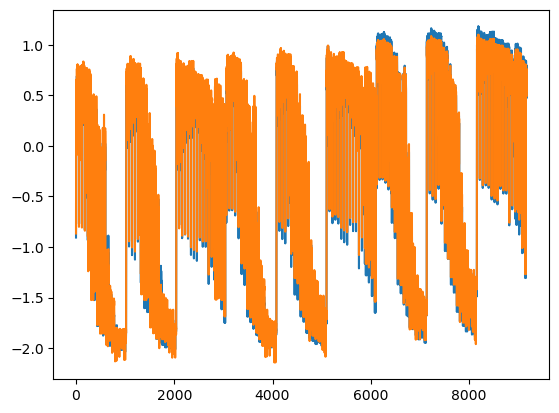

In [82]:
plt.plot(y_test)
plt.plot(y_pred_SVR)

#### Artificial Neural Networks

In [83]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam,schedules
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError, Accuracy,Accuracy, Precision, Recall, AUC,MeanAbsoluteError
from keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [90]:
def build_model(input_shape=(4,), output = 1 , act="LeakyReLU", final_act="linear", optimizer="adam", learning_rate=0.01, accuracy=[MeanAbsoluteError(),MeanSquaredError(), RootMeanSquaredError()], loss="mean_squared_error"):

    inputs = Input(shape=input_shape)

    x = Dense(64, activation=act, use_bias=True, kernel_initializer="he_normal")(inputs)
    x = Dense(32, activation=act, use_bias=True, kernel_initializer="he_normal")(x)
    x = Dense(16, activation=act, use_bias=True, kernel_initializer="he_normal")(x)
    outputs = Dense(output, activation=final_act)(x)

    model = Model(inputs=inputs, outputs=outputs)

    if optimizer == "adam":
        decay = schedules.ExponentialDecay(
                        learning_rate,
                        decay_steps=10000,
                        decay_rate=0.96,
                        staircase=True)
        optimizer = Adam(learning_rate=decay)

    model.compile(optimizer=optimizer, loss=loss, metrics=accuracy)

    model.summary()

    return model


In [91]:
model = build_model()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_8 (Dense)             (None, 64)                320       
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 2945 (11.50 KB)
Trainable params: 2945 (11.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [92]:
#early_stopping_callback = EarlyStopping(monitor='loss', patience=100, mode='min')
history = model.fit(x_train, y_train, epochs=30,verbose=2)#,callbacks=[early_stopping_callback])

Epoch 1/30


287/287 - 2s - loss: 0.2323 - mean_absolute_error: 0.3876 - mean_squared_error: 0.2323 - root_mean_squared_error: 0.4820 - 2s/epoch - 6ms/step
Epoch 2/30
287/287 - 1s - loss: 0.1620 - mean_absolute_error: 0.3341 - mean_squared_error: 0.1620 - root_mean_squared_error: 0.4025 - 619ms/epoch - 2ms/step
Epoch 3/30
287/287 - 1s - loss: 0.1398 - mean_absolute_error: 0.3103 - mean_squared_error: 0.1398 - root_mean_squared_error: 0.3740 - 736ms/epoch - 3ms/step
Epoch 4/30
287/287 - 1s - loss: 0.1327 - mean_absolute_error: 0.3004 - mean_squared_error: 0.1327 - root_mean_squared_error: 0.3643 - 550ms/epoch - 2ms/step
Epoch 5/30
287/287 - 1s - loss: 0.1221 - mean_absolute_error: 0.2866 - mean_squared_error: 0.1221 - root_mean_squared_error: 0.3494 - 558ms/epoch - 2ms/step
Epoch 6/30
287/287 - 1s - loss: 0.1180 - mean_absolute_error: 0.2818 - mean_squared_error: 0.1180 - root_mean_squared_error: 0.3435 - 581ms/epoch - 2ms/step
Epoch 7/30
287/287 - 1s - loss: 0.1112 - mean_absolute_error: 0.2705 - m

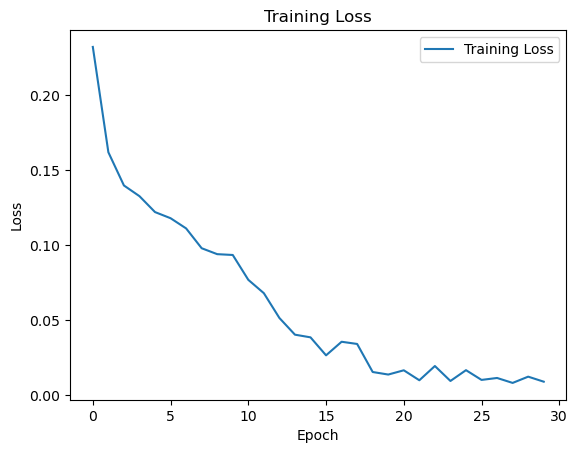

In [93]:
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [95]:
mse = model.evaluate(x_test, y_test, verbose=0)
y_pred_ANN = model.predict(x_test).ravel()

print("RMSE : ",RMSE(y_test, y_pred_ANN))
print("MSE : ",mean_squared_error(y_test, y_pred_ANN))
print("MAE : ",mean_absolute_error(y_test, y_pred_ANN))
print("R^2 : ",r2_score(y_test, y_pred_ANN))

287/287 [==============================] - 1s 2ms/step
RMSE :  0.07295715954993963
MSE :  0.005322747129595347
MAE :  0.06496558183664487
R^2 :  0.994470125607536


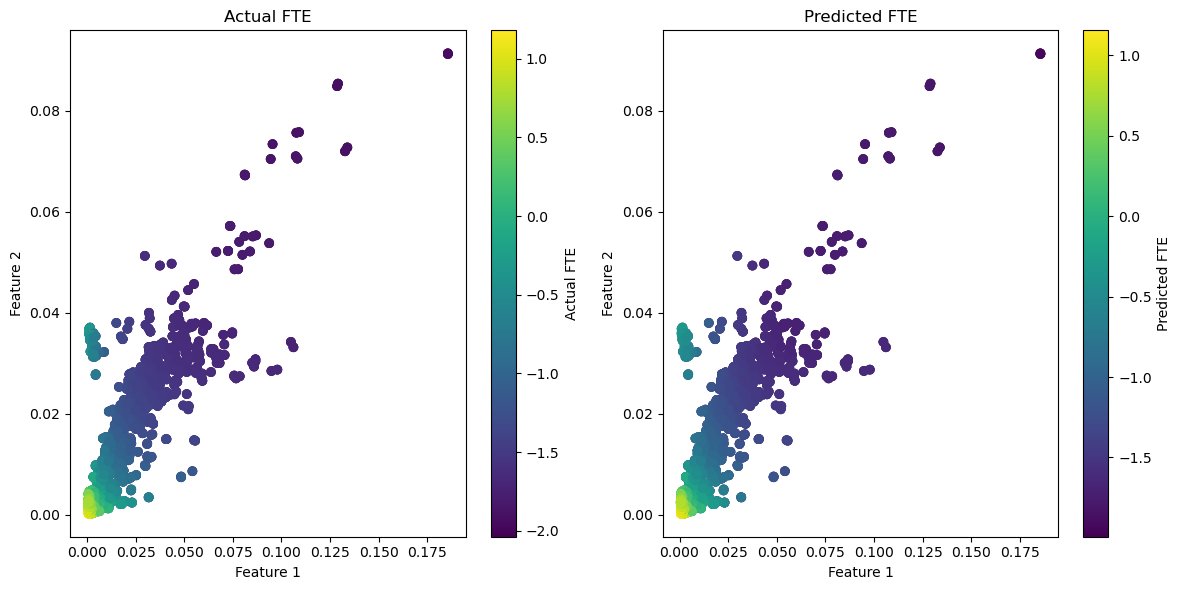

In [97]:
ploter(x_test["amp_y"],x_test["amp_z"],y_test,y_pred_ANN,"viridis")

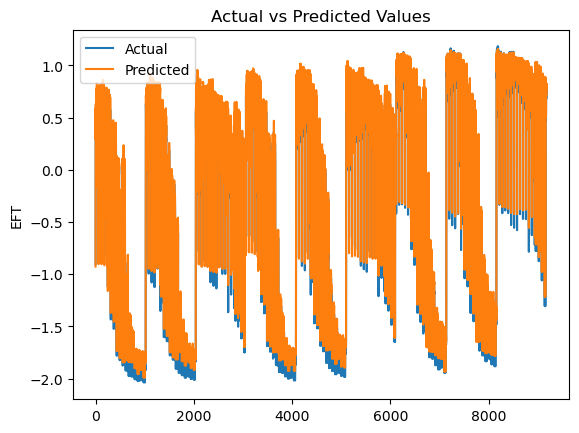

In [98]:
import matplotlib.pyplot as plt

plt.plot(y_test, label='Actual')
plt.plot(y_pred_ANN, label='Predicted')
plt.ylabel('EFT')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()


### 2.Classification (using Binning)

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def evaluate_classification_model(model, x_test, y_test):
    # Check if the model is a Keras model
    if hasattr(model, 'predict') :
        y_pred_prob = model.predict(x_test)
        # Assume binary classification for simplicity
        y_pred = np.where(y_pred_prob >= 0.5, 1, 0)
    else:
        y_pred = model.predict(x_test)    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(class_report)
    print("\nConfusion Matrix:")
    print(conf_matrix)
    
    return accuracy, precision, recall, f1, conf_matrix




def evaluate_classification_model_2(model, x_test, y_test):
    y_test_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred, average='macro')
    recall = recall_score(y_test, y_test_pred, average='macro')
    f1 = f1_score(y_test, y_test_pred, average='macro')
    conf_matrix = confusion_matrix(y_test, y_test_pred)

    return accuracy, precision, recall, f1, conf_matrix


**Explanation of Target Binning Approach**:

Since we are transforming a regression problem into a classification problem, we chose to bin the target variable, which is the remaining time for the machine to fail. We did this by creating bins of size 100 units of time, approximately equivalent to the minimum value in the training set. This bin size indicates the minimum resolution we need to determine how much time remains to take action. This approach ensures that we can effectively classify and predict the remaining time with a meaningful level of granularity, aligning with the practical needs of maintenance scheduling and intervention planning.

#### Artificial Neural Networks

ANN resulted a decsent accuracy level in both training and test data indicating fine performance .

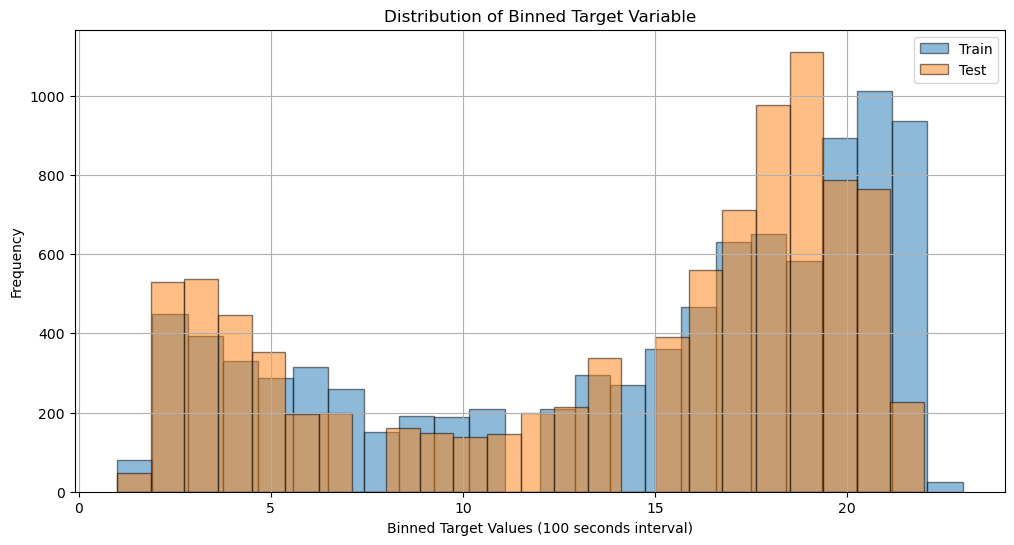

In [125]:
import numpy as np
import matplotlib.pyplot as plt

y_combined = np.concatenate([final_data['fte'], test_data['fte']])

bin_edges = np.arange(0, np.max(y_combined) + 300, 300)

bin_edges = np.arange(0, np.max(y_combined) + 300, 300)

y_train_binned = np.digitize(final_data['fte'], bins=bin_edges, right=False)
y_test_binned = np.digitize( test_data['fte'], bins=bin_edges, right=False)

plt.figure(figsize=(12, 6))
plt.hist(y_train_binned, bins=len(bin_edges), edgecolor='k', alpha=0.5, label='Train')
plt.hist(y_test_binned, bins=len(bin_edges), edgecolor='k', alpha=0.5, label='Test')
plt.xlabel('Binned Target Values (100 seconds interval)')
plt.ylabel('Frequency')
plt.title('Distribution of Binned Target Variable')
plt.legend()
plt.grid(True)
plt.show()

In [126]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
y_train_cat_sparse = encoder.fit_transform(y_train_binned.reshape(-1, 1))
y_test_cat_sparse = encoder.transform(y_test_binned.reshape(-1, 1))

y_train_cat = y_train_cat_sparse.toarray()
y_test_cat = y_test_cat_sparse.toarray()

print("Shape of y_train_cat:", y_train_cat.shape)
print("Shape of y_test_cat:", y_test_cat.shape)

Shape of y_train_cat: (9180, 23)
Shape of y_test_cat: (9180, 23)


Epoch 1/400
287/287 [==============================] - 3s 8ms/step - loss: 2.6964 - accuracy: 0.1376 - val_loss: 2.3527 - val_accuracy: 0.1667
Epoch 2/400
287/287 [==============================] - 2s 7ms/step - loss: 2.3201 - accuracy: 0.1727 - val_loss: 2.3390 - val_accuracy: 0.1207
Epoch 3/400
287/287 [==============================] - 2s 7ms/step - loss: 2.2430 - accuracy: 0.1841 - val_loss: 2.1714 - val_accuracy: 0.1758
Epoch 4/400
287/287 [==============================] - 2s 6ms/step - loss: 2.1905 - accuracy: 0.2011 - val_loss: 2.1337 - val_accuracy: 0.1623
Epoch 5/400
287/287 [==============================] - 2s 6ms/step - loss: 2.1657 - accuracy: 0.2032 - val_loss: 2.1137 - val_accuracy: 0.1985
Epoch 6/400
287/287 [==============================] - 2s 6ms/step - loss: 2.1364 - accuracy: 0.2047 - val_loss: 2.0750 - val_accuracy: 0.1947
Epoch 7/400
287/287 [==============================] - 2s 6ms/step - loss: 2.1331 - accuracy: 0.2020 - val_loss: 2.0894 - val_accuracy: 0.1925

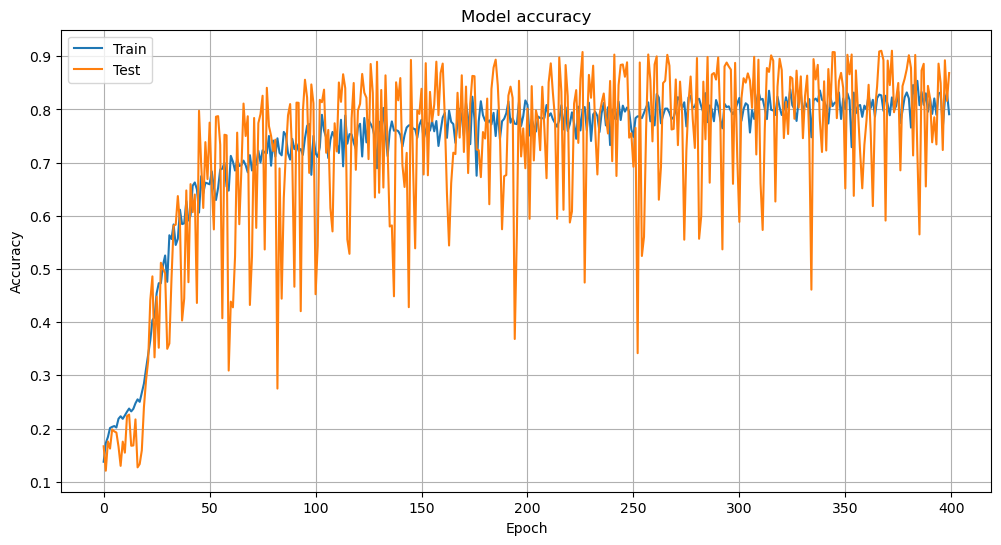

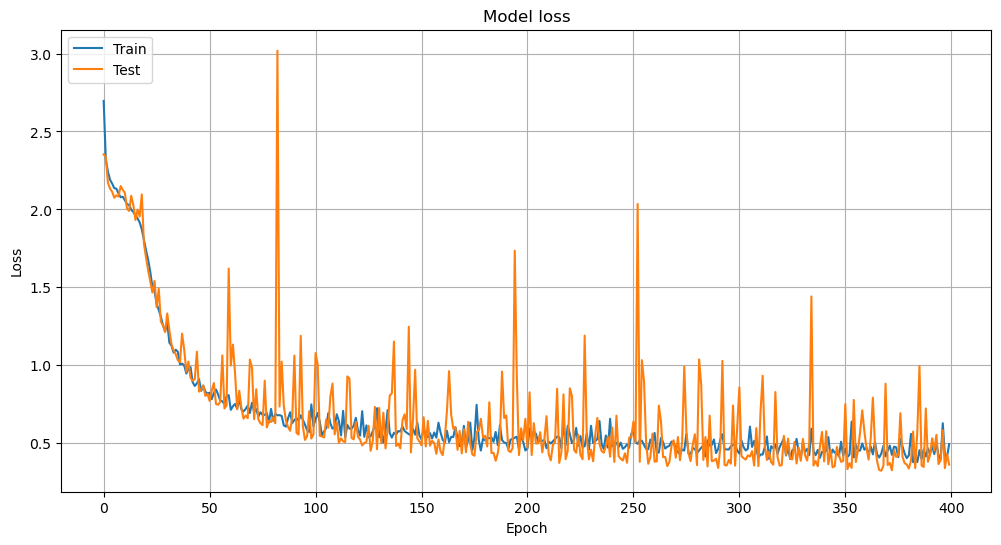

In [129]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

ann_model = Sequential([
    Dense(128, input_dim=x_train.shape[1], activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),

    Dense(y_train_cat.shape[1], activation='softmax')
])

ann_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history = ann_model.fit(x_train_2, y_train_cat, epochs=400, batch_size=32, validation_data=(x_test_2, y_test_cat))

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid(True)
plt.show()


In [161]:
test_loss, test_accuracy = ann_model.evaluate(x_test_2, y_test_cat)

 21/287 [=>............................] - ETA: 0s - loss: 0.3555 - accuracy: 0.9003 

287/287 [==============================] - 1s 2ms/step - loss: 0.3627 - accuracy: 0.8685


In [162]:
test_loss, test_accuracy = ann_model.evaluate(x_train_2, y_train_cat)

287/287 [==============================] - 1s 3ms/step - loss: 0.3591 - accuracy: 0.8578


In [172]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_classification_model_3(model, x_test, y_test):
    y_test_pred = model.predict(x_test)
    y_test_pred = np.argmax(y_test_pred, axis=1)

    accuracy =  ann_model.evaluate(x_test_2, y_test_cat)[1]
    
    if len(y_test.shape) > 1 and y_test.shape[1] > 1:
        y_test = np.argmax(y_test, axis=1)
    y_test=[np.argmax(i) for i in y_test]
    
    precision = precision_score(y_test, y_test_pred, average='macro')
    recall = recall_score(y_test, y_test_pred, average='macro')
    
    # Rename the variable to avoid conflict with function name
    f1_score_value = f1_score(y_test, y_test_pred, average='macro')

    conf_matrix = confusion_matrix(y_test, y_test_pred)

    return accuracy, precision, recall, f1_score_value, conf_matrix

metrics_ann_2 = evaluate_classification_model_3(ann_model, x_test_2, y_test_cat)


 22/287 [=>............................] - ETA: 0s 

287/287 [==============================] - 1s 2ms/step - loss: 0.3627 - accuracy: 0.8685


D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### SVM

In [69]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(final_data.drop(columns=columns_to_drop))
x_test_scaled = scaler.transform(test_data.drop(columns=columns_to_drop))

In [71]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

svm = SVC()

grid_search = GridSearchCV(svm, param_grid, refit=True, verbose=3, cv=5)

grid_search.fit(x_train_scaled, y_train_binned)

print("Best Parameters:", grid_search.best_params_)

best_svm = grid_search.best_estimator_


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[CV 1/5] END ........C=100, gamma=1, kernel=rbf;, score=0.846 total time=   1.5s
[CV 2/5] END ........C=100, gamma=1, kernel=rbf;, score=0.894 total time=   1.9s
[CV 3/5] END ........C=100, gamma=1, kernel=rbf;, score=0.867 total time=   1.5s
[CV 4/5] END ........C=100, gamma=1, kernel=rbf;, score=0.874 total time=   1.4s
[CV 5/5] END ........C=100, gamma=1, kernel=rbf;, score=0.740 total time=   1.3s
Best Parameters: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}


In [78]:
best_svm

SVC(C=100, gamma=1)

Training Accuracy: 0.9570806100217865
Test Accuracy: 0.8386710239651416
Confusion Matrix:
[[  18   30    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   2  490   38    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   0  152  255  130    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   0    0  135  221   89    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   0    0    0  114  204   34    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   0    0    0    0   59  102   32    3    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   0    0    0    0    3    3  154   38    2    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   0    0    0    0    1    4   15  123   19    0    0    0    0    0
     0    0    0    0    0    0  

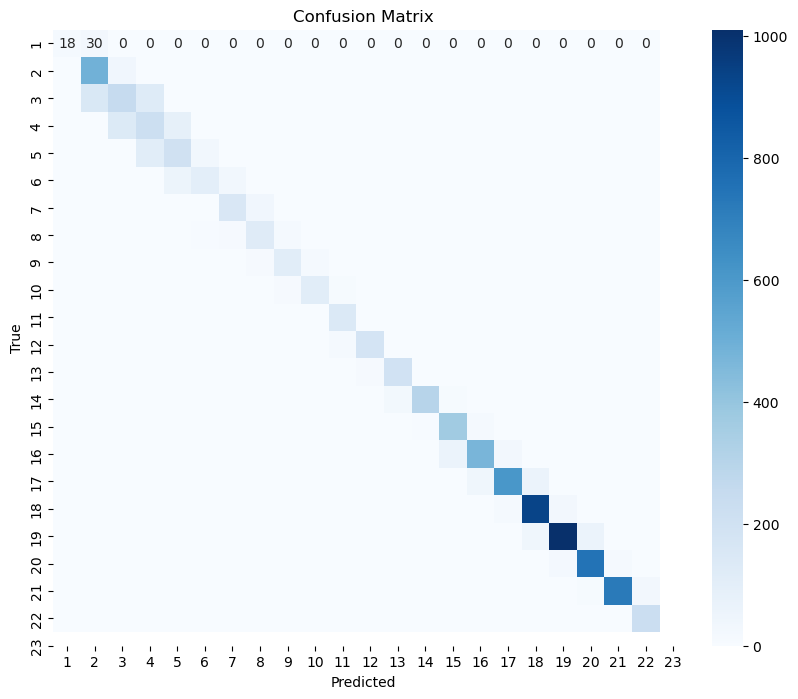

In [79]:

y_train_pred = best_svm.predict(x_train_scaled)

y_test_pred = best_svm.predict(x_test_scaled)

train_accuracy = accuracy_score(y_train_binned, y_train_pred)
print(f"Training Accuracy: {train_accuracy}")

test_accuracy = accuracy_score(y_test_binned, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")

conf_matrix = confusion_matrix(y_test_binned, y_test_pred)
class_report = classification_report(y_test_binned, y_test_pred)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

y_test_pred_c_svm = y_test_pred

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [73]:
y_test_pred_c_svm = y_test_pred

In [81]:
conf_matrix[1]

array([  2, 490,  38,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int64)

In [86]:
metrics_svm_2 = evaluate_classification_model_2(best_svm, x_test_scaled, y_test_binned)

#### Naive Bayes

##### **Gaussian Naive Bayes**

The Naive Bayes model didn't perform well because its underlying assumptions don't align with our specific problem and dataset. In Naive Bayes, all feature values can appear with different classes, combined with the values of other features. However, in our dataset, certain patterns like low amplitudes or high growth rates almost never coincide with bins representing high failure times. This discrepancy indicates that the relationship between features and the target is better captured through calculations and formulas rather than probabilities. Additionally, Naive Bayes assumes feature independence, which doesn't hold true in our case where the growth rate in the x-direction is inherently dependent on the amplitude in the x-direction.plus the way we generated data the amp_y and amp_z have can potentially have the same distro for different classes so their probabilities would not be really informative .


Training Accuracy: 0.5596949891067539
Test Accuracy: 0.485838779956427


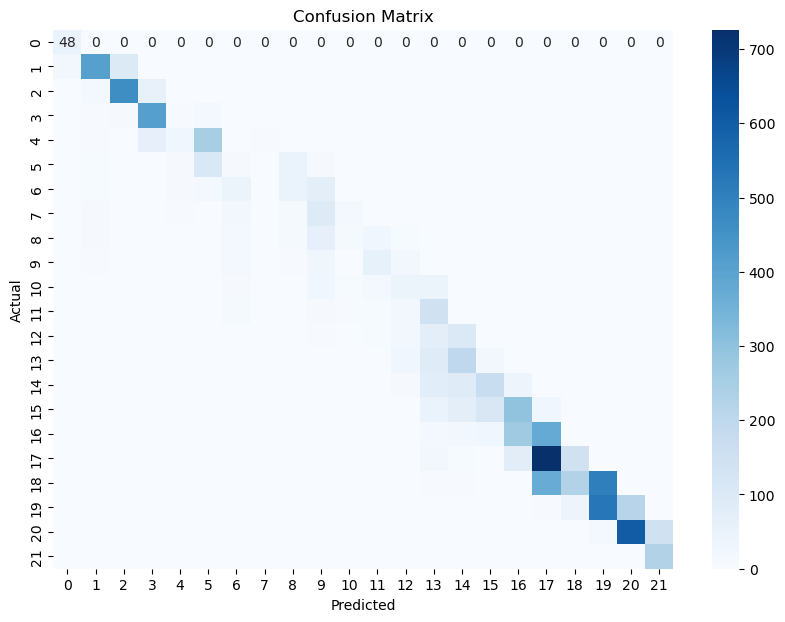

Classification Report:
               precision    recall  f1-score   support

           1       0.68      1.00      0.81        48
           2       0.86      0.77      0.81       530
           3       0.81      0.86      0.83       537
           4       0.78      0.93      0.85       445
           5       0.45      0.08      0.13       352
           6       0.27      0.55      0.37       196
           7       0.30      0.20      0.24       200
           8       0.00      0.00      0.00       162
           9       0.10      0.08      0.09       149
          10       0.10      0.22      0.14       138
          11       0.16      0.05      0.08       146
          12       0.07      0.04      0.05       200
          13       0.16      0.12      0.14       213
          14       0.17      0.26      0.21       338
          15       0.18      0.23      0.20       390
          16       0.34      0.20      0.25       560
          17       0.40      0.38      0.39       711
   

In [91]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt


nb_model = GaussianNB()

nb_model.fit(x_train, y_train_binned)

y_train_pred = nb_model.predict(x_train)

y_test_pred = nb_model.predict(x_test)

train_accuracy = accuracy_score(y_train_binned, y_train_pred)
print(f"Training Accuracy: {train_accuracy}")

test_accuracy = accuracy_score(y_test_binned, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")

conf_matrix = confusion_matrix(y_test_binned, y_test_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

class_report = classification_report(y_test_binned, y_test_pred)
print("Classification Report:\n", class_report)





In [92]:
metrics_nb_2 = evaluate_classification_model_2(nb_model, x_test, y_test_binned)

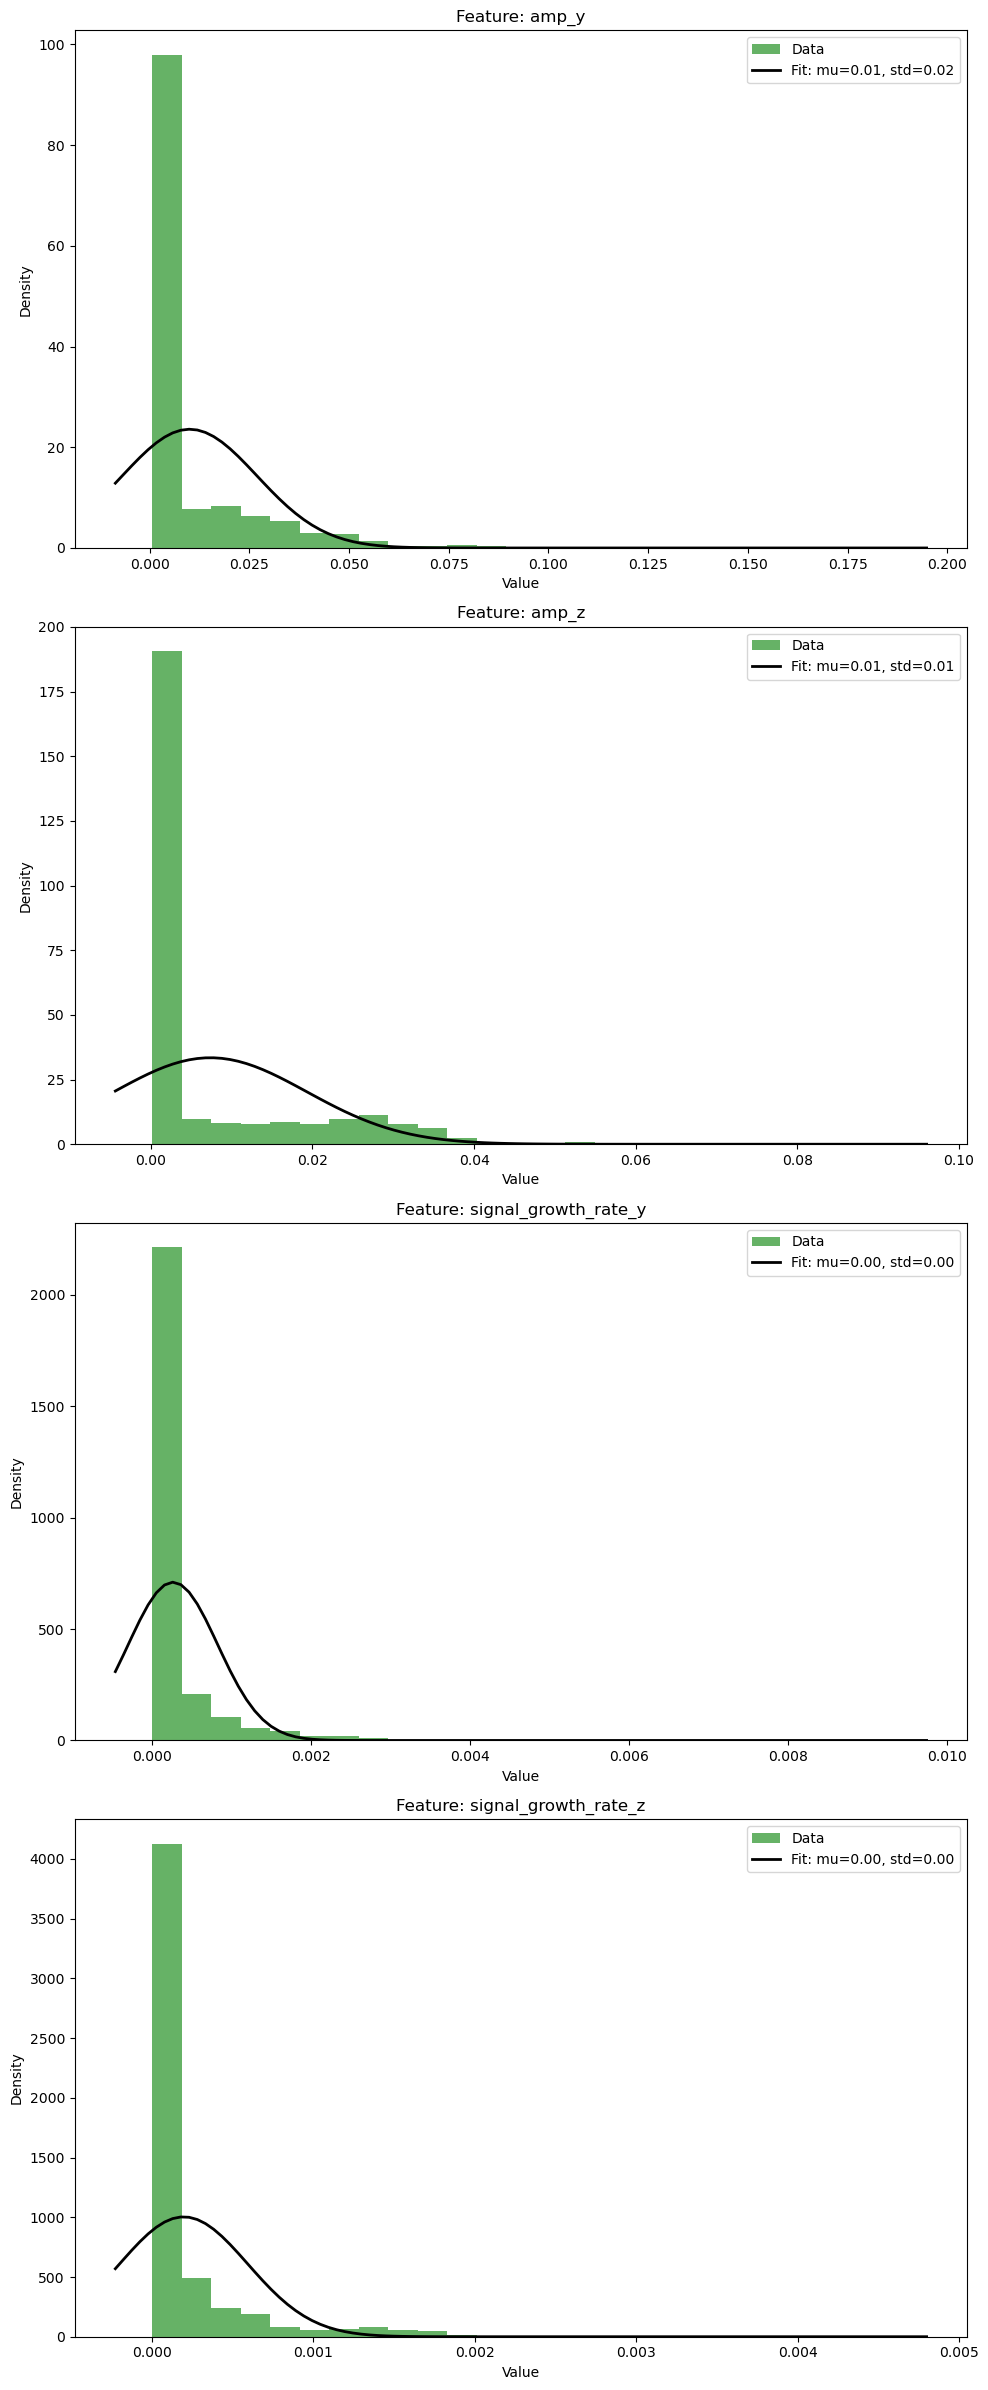

In [120]:
from scipy.stats import norm

if isinstance(x_train, np.ndarray):
    x_train = pd.DataFrame(x_train, columns=[f'Feature_{i}' for i in range(x_train.shape[1])])

def plot_feature_distribution(df):
    num_features = df.shape[1]
    fig, axes = plt.subplots(num_features, 1, figsize=(10, 6 * num_features))

    for i, col in enumerate(df.columns):
        data = df[col]
        mu, std = norm.fit(data)  

        axes[i].hist(data, bins=25, density=True, alpha=0.6, color='g', label='Data')

        xmin, xmax = axes[i].get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std)
        axes[i].plot(x, p, 'k', linewidth=2, label=f'Fit: mu={mu:.2f}, std={std:.2f}')

        axes[i].set_title(f'Feature: {col}')
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Density')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

plot_feature_distribution(x_train)


##### **exponential naive bayes**

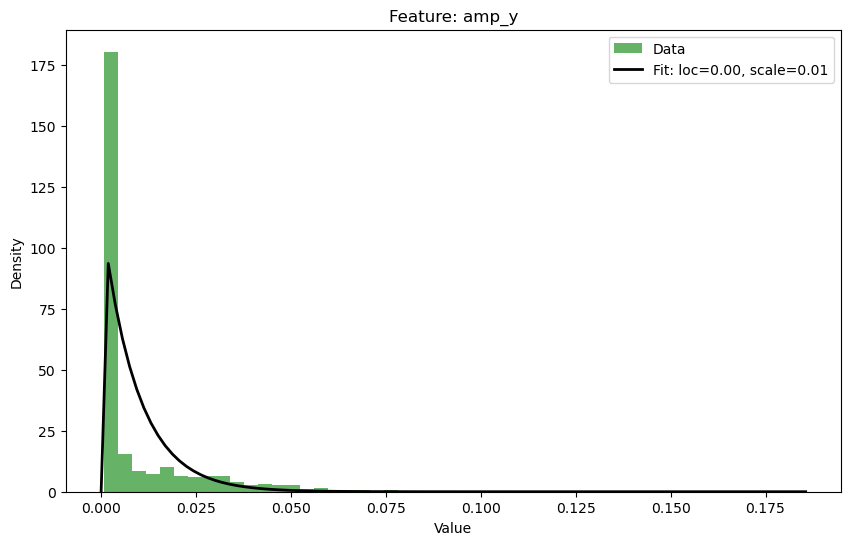

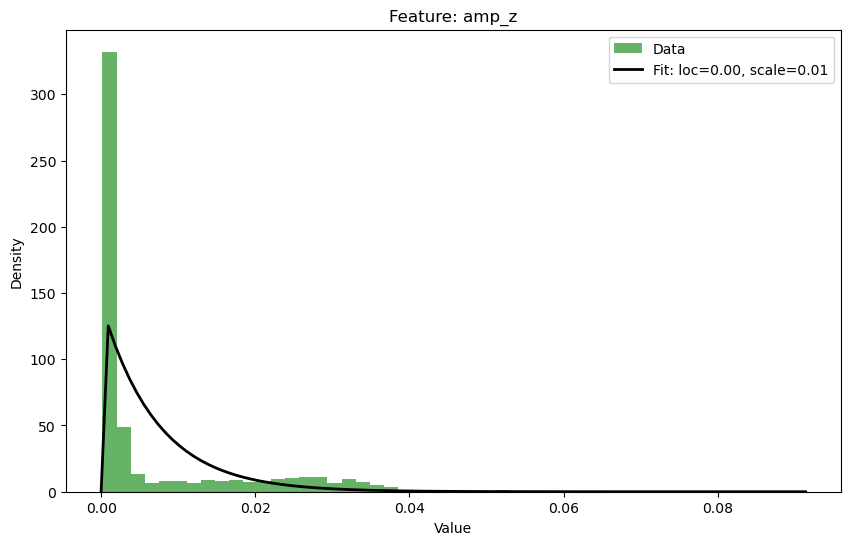

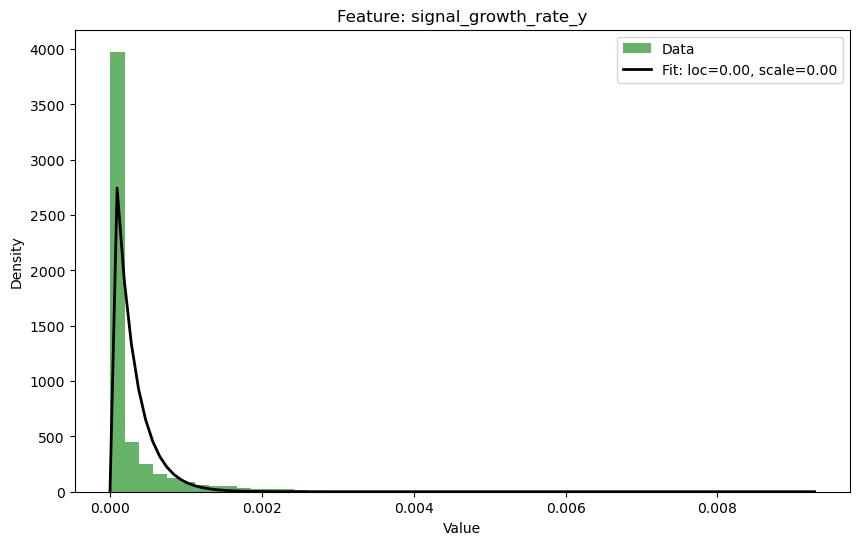

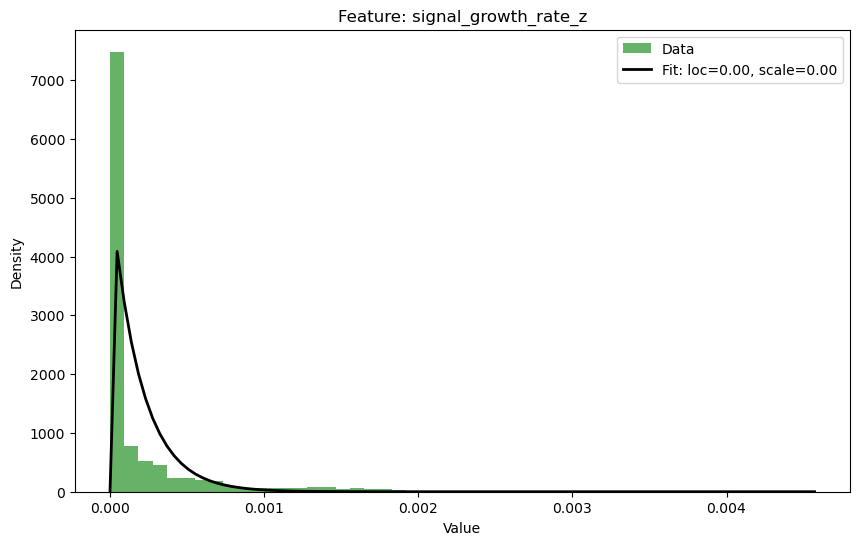

In [121]:
from scipy.stats import expon

features = x_train.columns

def plot_exponential_fit(feature_data, feature_name):
    loc, scale = expon.fit(feature_data)

    x = np.linspace(0, max(feature_data), 100)
    fitted_data = expon.pdf(x, loc, scale)

    plt.figure(figsize=(10, 6))
    plt.hist(feature_data, bins=50, density=True, alpha=0.6, color='g', label='Data')
    plt.plot(x, fitted_data, 'k', linewidth=2, label=f'Fit: loc={loc:.2f}, scale={scale:.2f}')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title(f'Feature: {feature_name}')
    plt.legend()
    plt.show()

for feature in features:
    plot_exponential_fit(x_train[feature], feature)


Training Accuracy: 0.26775599128540306
Test Accuracy: 0.3155773420479303
Classification Report (Train):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.11      0.82      0.20        79
           2       0.01      0.01      0.01       448
           3       0.03      0.02      0.02       394
           4       0.00      0.00      0.00       330
           5       0.14      0.37      0.21       287
           6       0.00      0.00      0.00       314
           7       0.00      0.00      0.00       260
           8       0.25      0.09      0.14       150
           9       0.19      0.13      0.16       190
          10       0.17      0.15      0.16       189
          11       0.00      0.00      0.00       209
          12       0.15      0.31      0.20       210
          13       0.27      0.10      0.14       294
          14       0.19      0.20      0.19       269
          15       0.17      0.

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMet

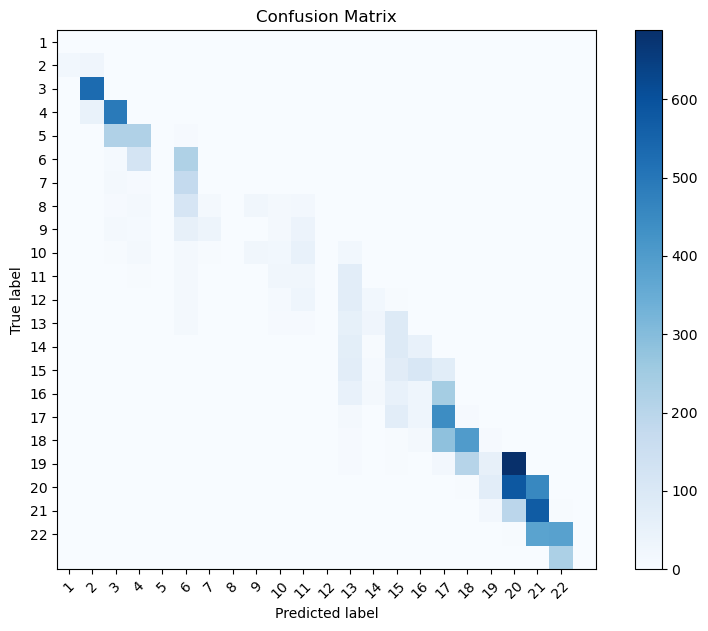

In [93]:
import numpy as np

class ExponentialNaiveBayes:
    def __init__(self):
        self.classes_prior = {}
        self.classes_lambda = {}
        self.class_mapping = {}
        self.num_classes = 0

    def fit(self, X, y):
        unique_classes = np.unique(y)
        self.num_classes = len(unique_classes)
        self.class_mapping = {c: i for i, c in enumerate(unique_classes)}
        for c in unique_classes:
            X_c = X[y == c]
            self.classes_prior[self.class_mapping[c]] = X_c.shape[0] / X.shape[0]
            self.classes_lambda[self.class_mapping[c]] = 1 / (np.mean(X_c, axis=0) + 1e-6)

    def predict(self, X):
        probability = np.zeros((X.shape[0], self.num_classes))
        for c, idx in self.class_mapping.items():
            prior = np.log(self.classes_prior[idx])
            lambda_c = self.classes_lambda[idx]
            probability_c = np.sum(-lambda_c * X + np.log(lambda_c), axis=1)
            probability[:, idx] = prior + probability_c
        return np.argmax(probability, axis=1)


nb = ExponentialNaiveBayes()
nb.fit(x_train, y_train_binned)
y_pred_train = nb.predict(x_train)
y_pred_test = nb.predict(x_test)

train_accuracy = np.mean(y_pred_train == y_train_binned)
test_accuracy = np.mean(y_pred_test == y_test_binned)


print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

print("Classification Report (Train):")
print(classification_report(y_train_binned, y_pred_train))

print("Classification Report (Test):")
print(classification_report(y_test_binned, y_pred_test))

conf_matrix = confusion_matrix(y_test_binned, y_pred_test)
plt.figure(figsize=(10, 7))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test_binned)))
plt.xticks(tick_marks, np.unique(y_test_binned), rotation=45)
plt.yticks(tick_marks, np.unique(y_test_binned))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


Training Accuracy: 0.9532679738562092
Test Accuracy: 0.9518518518518518
Classification Report (Train):
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      3604
           1       0.94      0.98      0.96      5576

    accuracy                           0.95      9180
   macro avg       0.96      0.95      0.95      9180
weighted avg       0.95      0.95      0.95      9180

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.97      0.90      0.94      3622
           1       0.94      0.98      0.96      5558

    accuracy                           0.95      9180
   macro avg       0.96      0.94      0.95      9180
weighted avg       0.95      0.95      0.95      9180



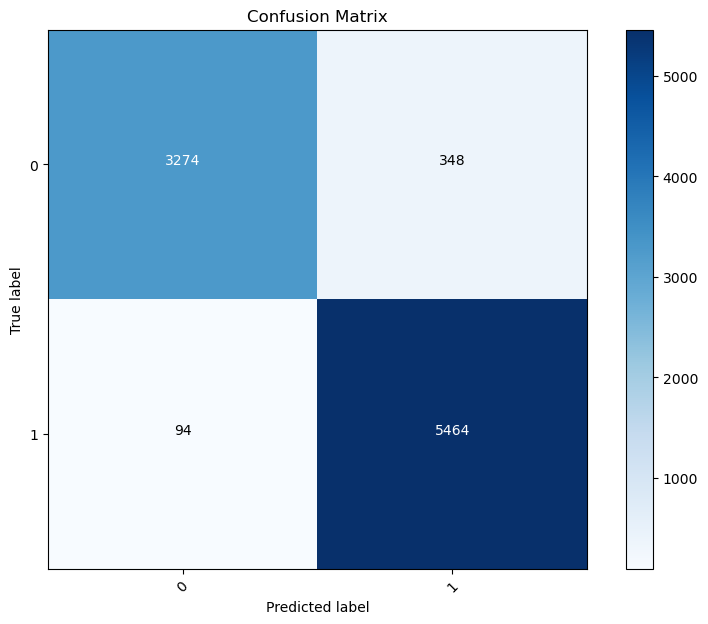

In [289]:
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

gnb = GaussianNB()

gnb.fit(x_train, y_train_binned)

y_pred_train = gnb.predict(x_train)

y_pred_test = gnb.predict(x_test)

train_accuracy = accuracy_score(y_train_binned, y_pred_train)
test_accuracy = accuracy_score(y_test_binned, y_pred_test)

print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

print("Classification Report (Train):")
print(classification_report(y_train_binned, y_pred_train))

print("Classification Report (Test):")
print(classification_report(y_test_binned, y_pred_test))

conf_matrix = confusion_matrix(y_test_binned, y_pred_test)
plt.figure(figsize=(10, 7))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add text annotations
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

tick_marks = np.arange(len(np.unique(y_test_binned)))
plt.xticks(tick_marks, np.unique(y_test_binned), rotation=45)
plt.yticks(tick_marks, np.unique(y_test_binned))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [94]:
metrics_nb_3 = evaluate_classification_model_2(nb, x_test, y_test_binned)

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 3.Classification (second approache)

#### Naïve Bayes

In [125]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


In [126]:
df_c

ftt_y      ftt_z    freq_z    freq_y     amp_y     amp_z  wconfid  \
0     2.303057  55.601713  0.473902  0.473902  0.001535  0.037068        1   
1     2.951814   0.499630  1.264746  1.264746  0.001968  0.000333        1   
2     2.515945   0.386033  2.088893  2.088893  0.001677  0.000257        1   
3     3.817060   0.398700  2.918261  2.918261  0.002545  0.000266        1   
4     3.009804   0.343958  3.749389  3.749389  0.002007  0.000229        1   
...        ...        ...       ...       ...       ...       ...      ...   
3055  0.973524   3.529775  3.766021  3.766021  0.000649  0.002353        3   
3056  0.976320   3.616841  2.934872  2.934872  0.000651  0.002411        3   
3057  1.065303   3.457747  2.105449  2.105449  0.000710  0.002305        3   
3058  0.990267   4.067342  1.281113  1.281113  0.000660  0.002712        3   
3059  1.050289   3.842046  0.488336  0.488336  0.000700  0.002561        3   

      pctid  failed  
0        20       0  
1        20       0  
2        20       0  
3        20       0  
4        20       0  
...     ...     ...  
3055    100       0  
3056    100       0  
3057    100       0  
3058    100       0  
3059    100       0  

[3060 rows x 9 columns]

In [127]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

nb_model = GaussianNB()
nb_model.fit(x_train_c.values, y_train_c)

y_train_pred_prob = nb_model.predict(x_train_c.values)
y_test_pred_prob = nb_model.predict(x_test_c.values)


In [128]:
# Calculate metrics for training data
train_accuracy = accuracy_score(y_train_c, y_train_pred_prob)
train_precision = precision_score(y_train_c, y_train_pred_prob)
train_recall = recall_score(y_train_c, y_train_pred_prob)
train_f1 = f1_score(y_train_c, y_train_pred_prob)

print(f"Training set Accuracy: {train_accuracy:.4f}")
print(f"Training set Precision: {train_precision:.4f}")
print(f"Training set Recall: {train_recall:.4f}")
print(f"Training set F1-score: {train_f1:.4f}")


Training set Accuracy: 0.9824
Training set Precision: 0.9915
Training set Recall: 0.9659
Training set F1-score: 0.9785


In [129]:
metrics_nb = evaluate_classification_model(nb_model, x_test_c, y_test_c)

Accuracy: 0.9833
Precision: 0.9836
Recall: 0.9833
F1 Score: 0.9833

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       595
           1       1.00      0.96      0.98       425

    accuracy                           0.98      1020
   macro avg       0.99      0.98      0.98      1020
weighted avg       0.98      0.98      0.98      1020


Confusion Matrix:
[[593   2]
 [ 15 410]]


D:\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


In [130]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test_c, y_test_pred_prob)
print("Confusion Matrix:")
print(conf_matrix)

# Classification report
class_report = classification_report(y_test_c, y_test_pred_prob)
print("Classification Report:")
print(class_report)

Confusion Matrix:
[[593   2]
 [ 15 410]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       595
           1       1.00      0.96      0.98       425

    accuracy                           0.98      1020
   macro avg       0.99      0.98      0.98      1020
weighted avg       0.98      0.98      0.98      1020



In [131]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score

# Plot ROC curve
def plot_roc_curve(y_test, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Plot Precision-Recall curve
def plot_precision_recall_curve(y_test, y_pred_prob):
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    average_precision = average_precision_score(y_test, y_pred_prob)

    plt.figure()
    plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (area = {average_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()




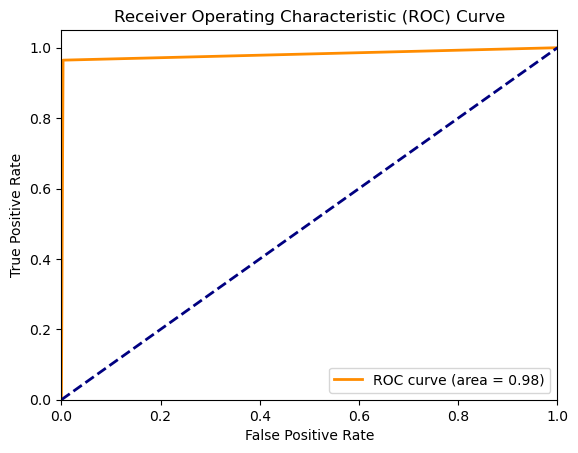

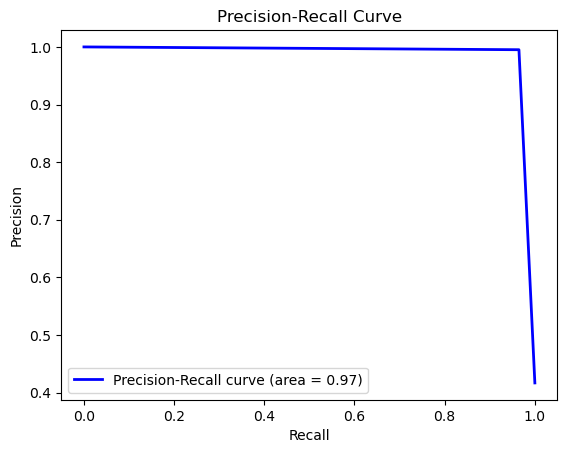

In [132]:
plot_roc_curve(y_test_c, y_test_pred_prob)
plot_precision_recall_curve(y_test_c, y_test_pred_prob)

In [133]:
from sklearn.model_selection import GroupKFold

def cross_validation(model, X, y, groups):
    scaler = StandardScaler()

    group_kfold = GroupKFold(n_splits=len(groups.unique()))

    train_scores = []
    test_scores = []
    t = copy.deepcopy(model)
    for train_index, test_index in group_kfold.split(X, y, groups):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        model = copy.deepcopy(t)
        model.fit(X_train_scaled, y_train)

        train_pred = model.predict(X_train_scaled)
        test_pred = model.predict(X_test_scaled)

        train_acc = accuracy_score(y_train, train_pred)
        test_acc = accuracy_score(y_test, test_pred)

        train_scores.append(train_acc)
        test_scores.append(test_acc)
        print(f"Fold {i+1}: Train Accuracy = {train_acc}, Test Accuracy = {test_acc}")

    avg_train_score = sum(train_scores) / len(train_scores)
    avg_test_score = sum(test_scores) / len(test_scores)

    print("Average Train Accuracy:", avg_train_score)
    print("Average Test Accuracy:", avg_test_score)

X_c_val = df_c.drop(columns=['failed', 'freq_y', 'pctid', 'wconfid'])
y_c_val = df_c['failed']
groups = df_c['wconfid']
val_gnb_model = GaussianNB()

cross_validation(val_gnb_model, X_c_val, y_c_val, groups)

Fold 3060: Train Accuracy = 0.9759803921568627, Test Accuracy = 0.9833333333333333
Fold 3060: Train Accuracy = 0.9823529411764705, Test Accuracy = 0.9833333333333333
Fold 3060: Train Accuracy = 0.9745098039215686, Test Accuracy = 0.9049019607843137
Average Train Accuracy: 0.9776143790849673
Average Test Accuracy: 0.9571895424836602


#### SVM

In [135]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10 , 1000]}

svm = SVC(kernel='rbf', probability=True)

grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train_c, y_train_c)

best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy:", best_accuracy)


Best Parameters: {'C': 100, 'gamma': 0.001}
Best Accuracy: 0.9936274509803923


In [136]:
val_svm_model = SVC(C=100,gamma=0.001,kernel='rbf', probability=False)
cross_validation(val_gnb_model, X_c_val, y_c_val, groups)

Fold 3060: Train Accuracy = 0.9759803921568627, Test Accuracy = 0.9833333333333333
Fold 3060: Train Accuracy = 0.9823529411764705, Test Accuracy = 0.9833333333333333
Fold 3060: Train Accuracy = 0.9745098039215686, Test Accuracy = 0.9049019607843137
Average Train Accuracy: 0.9776143790849673
Average Test Accuracy: 0.9571895424836602


In [137]:
svm = grid_search.best_estimator_
y_pred = [np.argmax(i) for i in svm.predict_proba(x_test_c)]

In [138]:
metrics_svm = evaluate_classification_model(svm, x_test_c, y_test_c)

Accuracy: 0.9941
Precision: 0.9942
Recall: 0.9941
F1 Score: 0.9941

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       595
           1       0.99      1.00      0.99       425

    accuracy                           0.99      1020
   macro avg       0.99      0.99      0.99      1020
weighted avg       0.99      0.99      0.99      1020


Confusion Matrix:
[[590   5]
 [  1 424]]


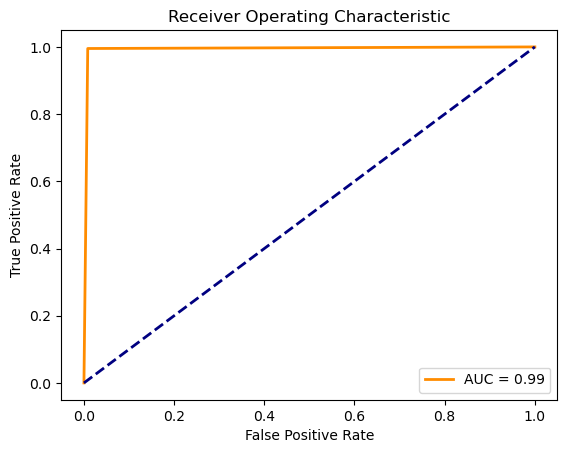

In [139]:
fpr, tpr, _ = roc_curve(y_test_c, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

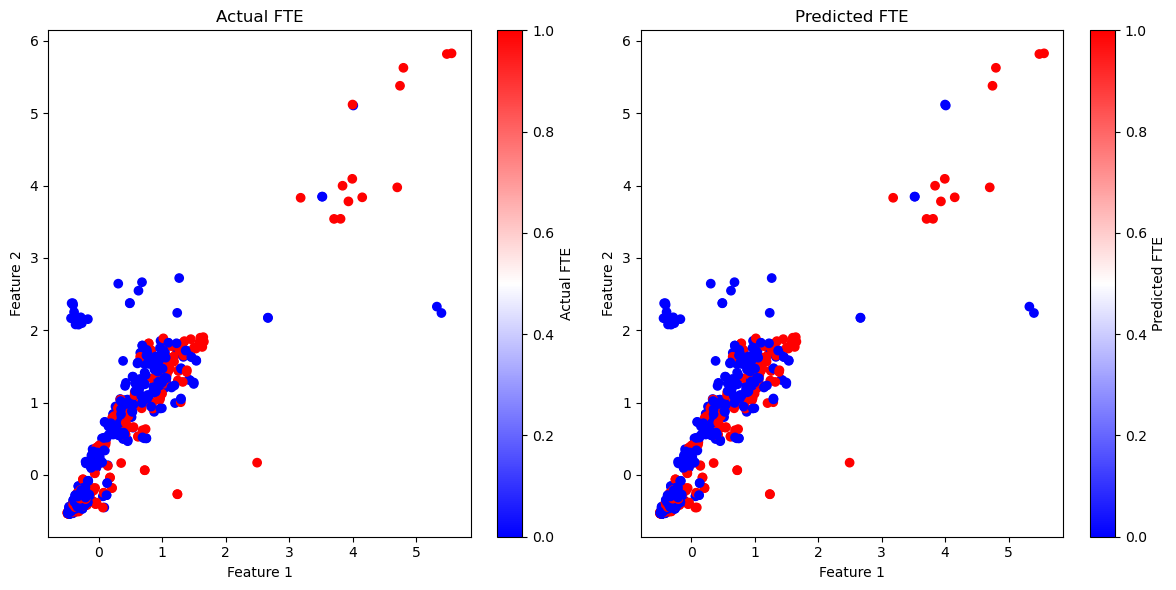

In [140]:
ploter(x_test_c["amp_y"], x_test_c["amp_z"],y_test_c,svm.predict(x_test_c),"bwr")

#### Artificial Neural Networks

In [209]:
import numpy as np

# Get the unique classes and their counts
classes, counts = np.unique(y_train_c, return_counts=True)

# Zip the classes and counts together for readability
class_counts = dict(zip(classes, counts))

print("Class Counts:")
for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count}")


Class Counts:
Class 0: 1190
Class 1: 850


In [280]:
from keras.layers import Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

def build_model_2(input_shape=(4,), act="relu", final_act="sigmoid", optimizer="adam", learning_rate=0.01, dropout_rate=0.3, batch_norm=False, num_layers=1, accuracy=[MeanAbsoluteError(),MeanSquaredError(), RootMeanSquaredError()], loss="mean_squared_error",verbos=1):
    inputs = Input(shape=input_shape)
    x = inputs
    
    for _ in range(num_layers):
        x = Dense(64, activation=act, kernel_initializer="he_normal")(x)
        if batch_norm:
            x = BatchNormalization()(x)
        x = Dropout(dropout_rate)(x)
    
    outputs = Dense(1, activation=final_act)(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    if optimizer == "adam":
        decay = schedules.ExponentialDecay(
                        learning_rate,
                        decay_steps=10000,
                        decay_rate=0.96,
                        staircase=True)
        optimizer = Adam(learning_rate=decay)

    model.compile(optimizer=optimizer, loss=loss, metrics=accuracy)
    if verbos == 1 :
        model.summary()

    return model

early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
cmodel = build_model_2(input_shape=(x_train_c.shape[1],) ,accuracy=["accuracy", Precision(), Recall(), AUC()], loss="binary_crossentropy",)

Model: "model_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_116 (Dense)           (None, 64)                384       
                                                                 
 dropout_22 (Dropout)        (None, 64)                0         
                                                                 
 dense_117 (Dense)           (None, 1)                 65        
                                                                 
Total params: 449 (1.75 KB)
Trainable params: 449 (1.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [281]:
history = cmodel.fit(x_train_c, y_train_c, epochs=30, validation_split=0.1,verbose=2)

Epoch 1/30


58/58 - 2s - loss: 0.2838 - accuracy: 0.8845 - precision_46: 0.8302 - recall_46: 0.9102 - auc_46: 0.9571 - val_loss: 0.0622 - val_accuracy: 0.9853 - val_precision_46: 0.9759 - val_recall_46: 0.9878 - val_auc_46: 0.9994 - 2s/epoch - 36ms/step
Epoch 2/30
58/58 - 0s - loss: 0.0905 - accuracy: 0.9646 - precision_46: 0.9501 - recall_46: 0.9661 - auc_46: 0.9951 - val_loss: 0.0482 - val_accuracy: 0.9804 - val_precision_46: 1.0000 - val_recall_46: 0.9512 - val_auc_46: 0.9996 - 230ms/epoch - 4ms/step
Epoch 3/30
58/58 - 0s - loss: 0.0544 - accuracy: 0.9798 - precision_46: 0.9778 - recall_46: 0.9740 - auc_46: 0.9985 - val_loss: 0.0381 - val_accuracy: 0.9853 - val_precision_46: 0.9647 - val_recall_46: 1.0000 - val_auc_46: 0.9996 - 212ms/epoch - 4ms/step
Epoch 4/30
58/58 - 0s - loss: 0.0642 - accuracy: 0.9766 - precision_46: 0.9690 - recall_46: 0.9753 - auc_46: 0.9967 - val_loss: 0.0339 - val_accuracy: 0.9853 - val_precision_46: 0.9647 - val_recall_46: 1.0000 - val_auc_46: 0.9997 - 215ms/epoch - 4m

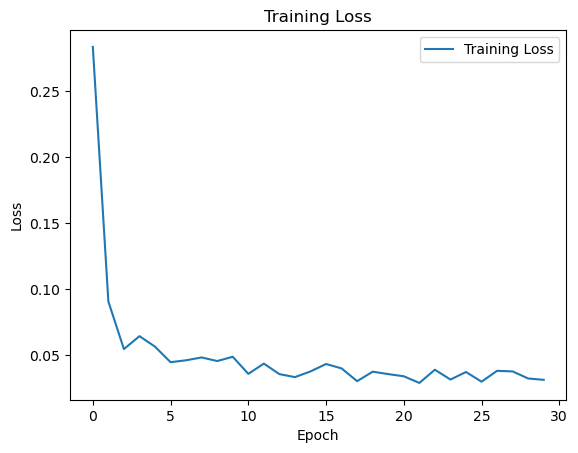

In [282]:
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

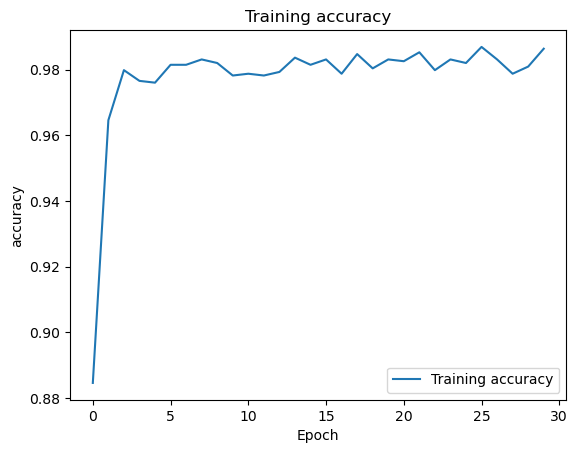

In [283]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.title('Training accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

28/64 [============>.................] - ETA: 0s

64/64 [==============================] - 0s 3ms/step


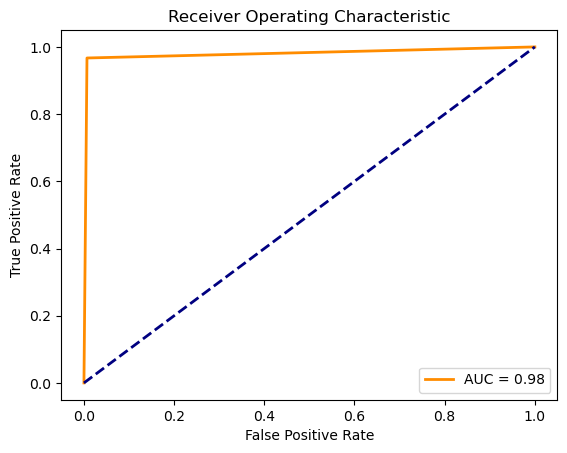

In [284]:
y_prob = np.where(cmodel.predict(x_train_c) >= .5, 1, 0)
fpr, tpr, _ = roc_curve(y_train_c, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [285]:
y_pred = np.where(cmodel.predict(x_test_c) >= .5, 1, 0)

32/32 [==============================] - 0s 2ms/step


In [286]:
metrics_ANN = evaluate_classification_model(cmodel, x_test_c, y_test_c)

32/32 [==============================] - 0s 2ms/step
Accuracy: 0.9833
Precision: 0.9834
Recall: 0.9833
F1 Score: 0.9833

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       595
           1       0.99      0.97      0.98       425

    accuracy                           0.98      1020
   macro avg       0.98      0.98      0.98      1020
weighted avg       0.98      0.98      0.98      1020


Confusion Matrix:
[[589   6]
 [ 11 414]]


In [287]:
def cross_validation(model, X, y, groups):
    group_kfold = GroupKFold(n_splits=len(groups.unique()))

    train_scores = []
    test_scores = []

    for train_index, test_index in group_kfold.split(X, y, groups):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model = build_model_2(input_shape=(x_train_c.shape[1],) ,accuracy=["accuracy", Precision(), Recall(), AUC()], loss="binary_crossentropy",verbos=0)  
        model.fit(X_train, y_train, epochs=20, verbose=0) 

        train_acc = model.evaluate(X_train, y_train, verbose=0)[-1] 
        test_acc = model.evaluate(X_test, y_test, verbose=0)[-1] 

        train_scores.append(train_acc)
        test_scores.append(test_acc)
        print(f"Fold {i+1}: Train Accuracy = {train_acc}, Test Accuracy = {test_acc}")


    avg_train_score = sum(train_scores) / len(train_scores)
    avg_test_score = sum(test_scores) / len(test_scores)

    print("Average Train Accuracy:", avg_train_score)
    print("Average Test Accuracy:", avg_test_score)

cmodelval = build_model_2(input_shape=(x_train_c.shape[1],) ,accuracy=["accuracy", Precision(), Recall(), AUC()], loss="binary_crossentropy")  
cross_validation(cmodelval, X_c_val, y_c_val, groups)

Model: "model_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_118 (Dense)           (None, 64)                384       
                                                                 
 dropout_23 (Dropout)        (None, 64)                0         
                                                                 
 dense_119 (Dense)           (None, 1)                 65        
                                                                 
Total params: 449 (1.75 KB)
Trainable params: 449 (1.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Fold 3060: Train Accuracy = 0.997751772403717, Test Accuracy = 0.9995077252388
Fold 3060: Train Accuracy = 0.9991157054901123, Test Accuracy = 0.9955313801765442
Fold 3060: Train Accuracy = 0.9981102347373962, Test Accuracy = 0.9917548894882202
Average Train Accuracy: 0.9983259042104086
Average Test Accuracy: 0.9955979983011881


# Results Comparaison

### 1.Regression models

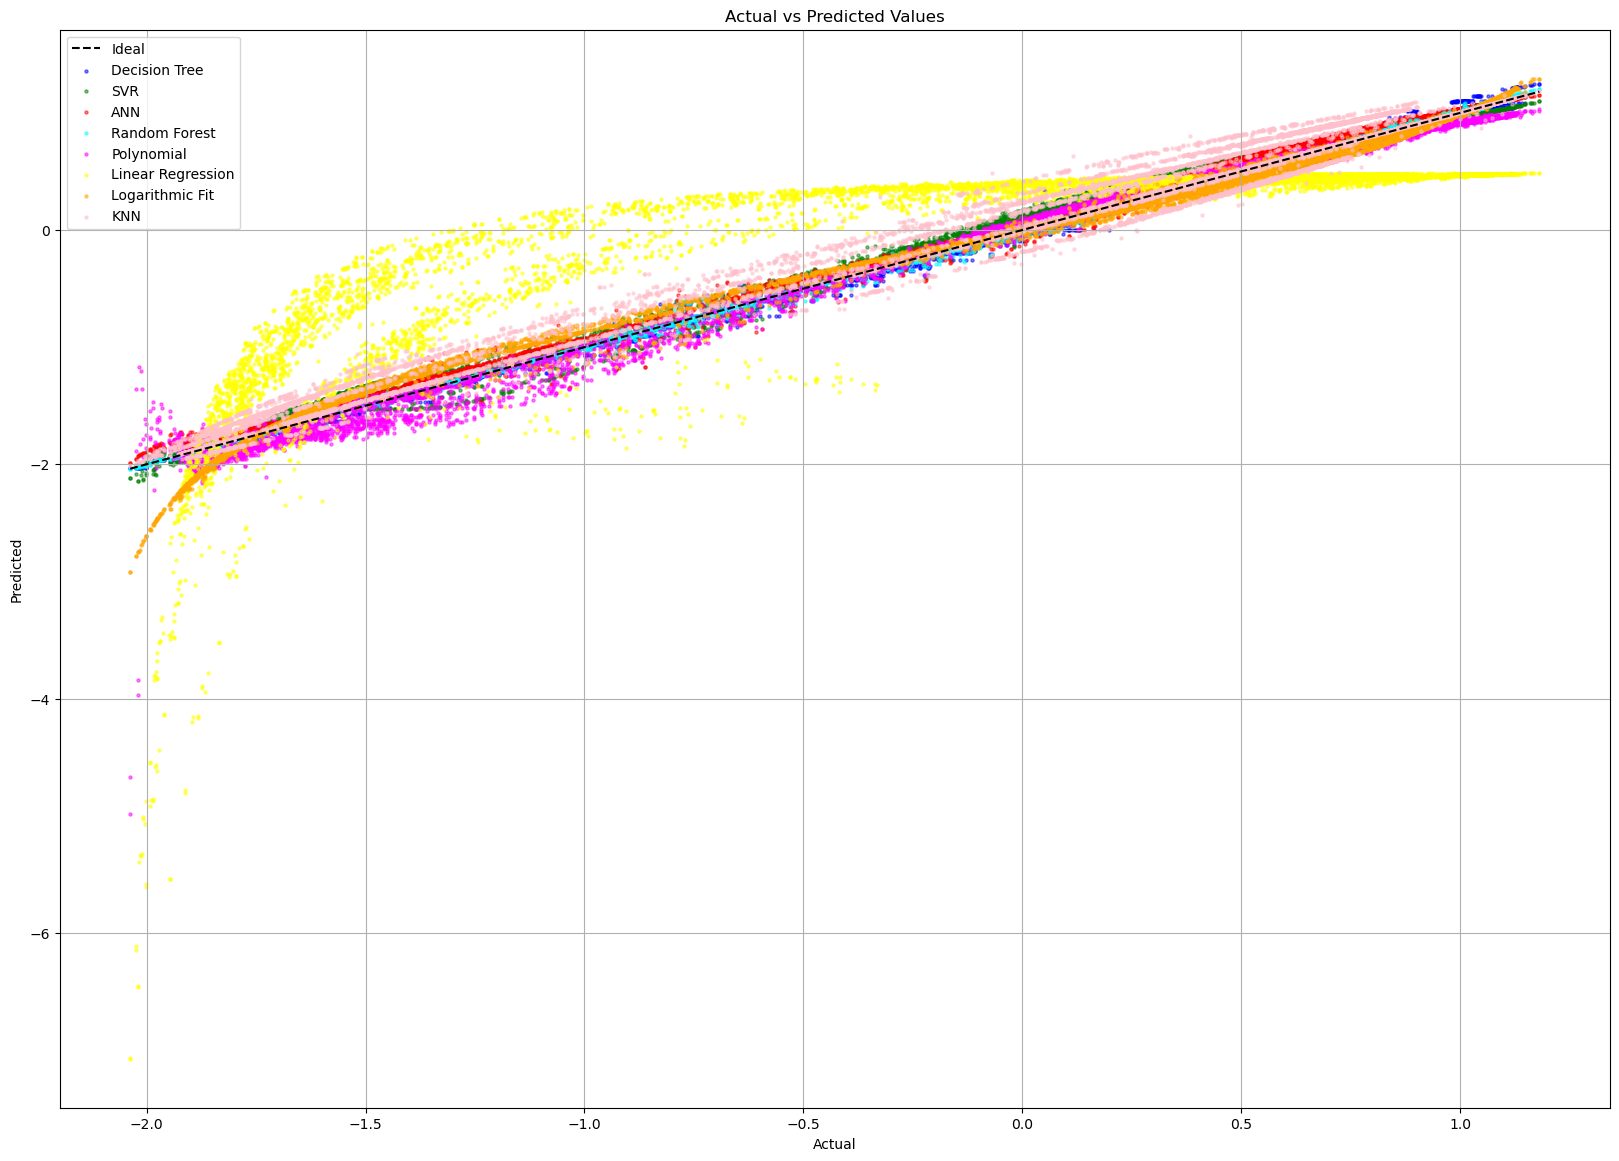

In [208]:
def plot_actual_vs_predicted(y_test, predictions, model_names):
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'orange',"pink", "brown"]
    marker_size = 5

    plt.figure(figsize=(20, 14))
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', label='Ideal')

    for idx, (y_pred, model_name) in enumerate(zip(predictions, model_names)):
        plt.scatter(y_test, y_pred, color=colors[idx % len(colors)], alpha=0.5,
                    label=model_name, s=marker_size)  

    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.show()

model_names = ['Decision Tree', 'SVR','ANN', 'Random Forest',"Polynomial",
               "Linear Regression","Logarithmic Fit","KNN"]
predictions = [y_test_pred_DT, y_pred_SVR, y_pred_ANN, y_test_pred_forest,
               y_pred_POLY, y_pred_LR, y_pred_LRF, y_pred_KNN]
plot_actual_vs_predicted(y_test, predictions, model_names)


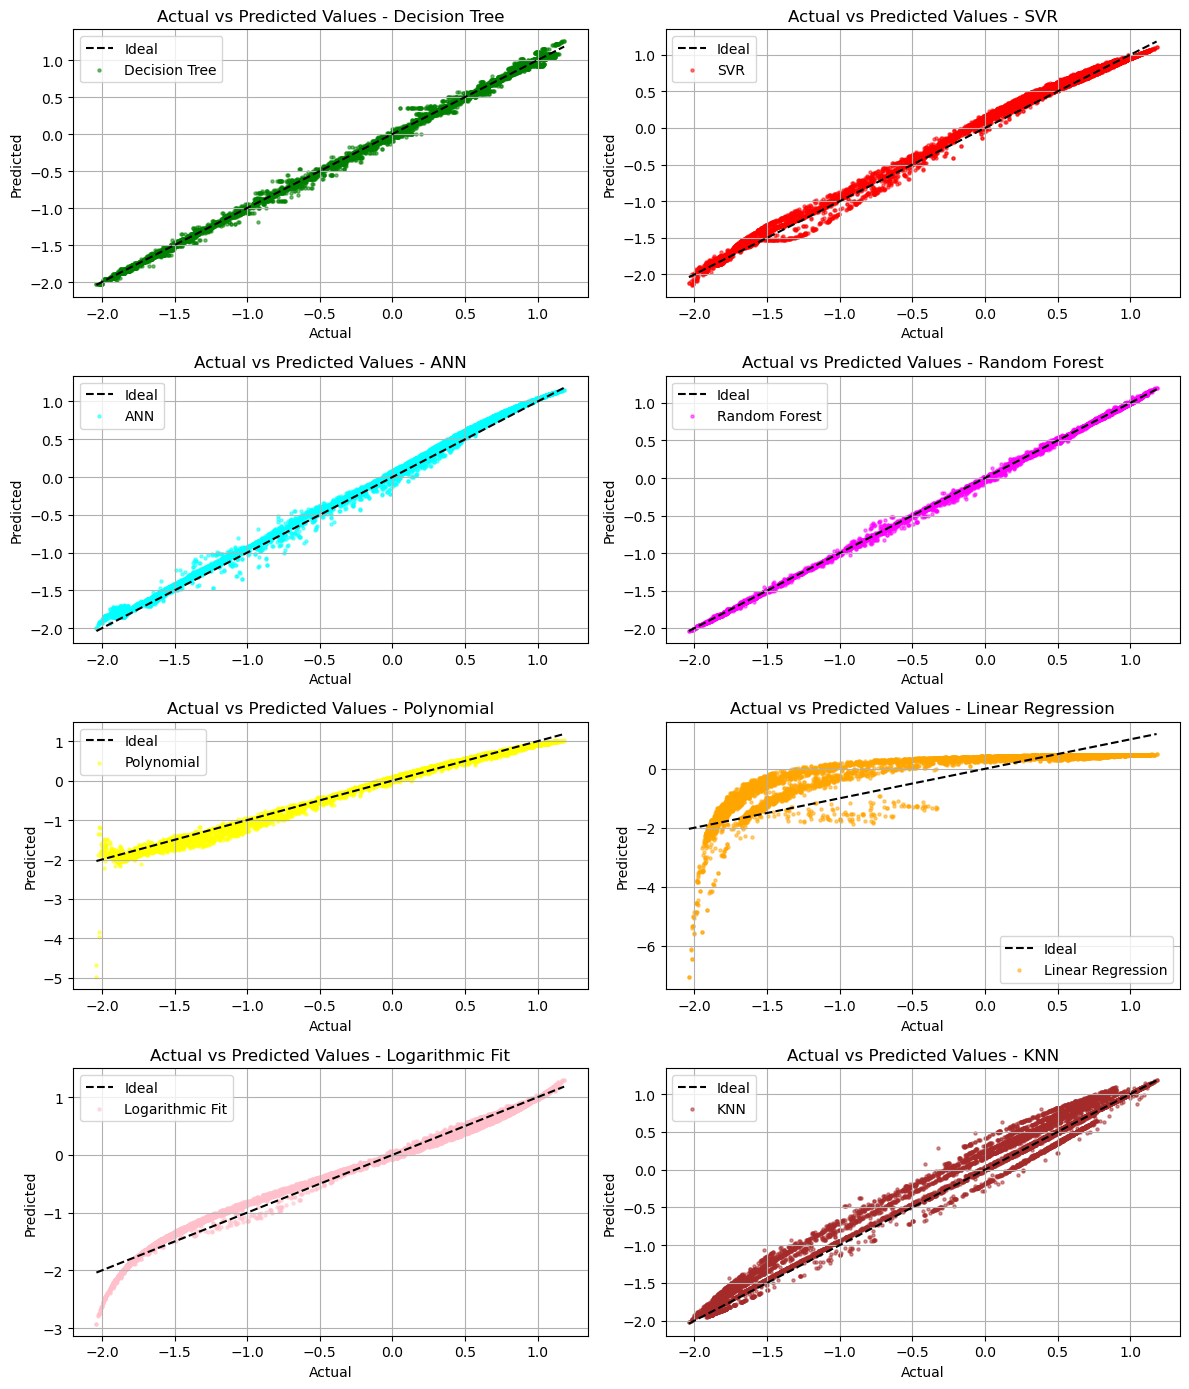

In [181]:
def plot_pred(y_test, predictions, model_names):
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'orange', "pink", "brown"]
    marker_size = 5

    num_models = len(model_names)
    num_rows = (num_models + 1) // 2 

    plt.figure(figsize=(12,14))

    for idx, (y_pred, model_name) in enumerate(zip(predictions, model_names), start=1):
        plt.subplot(num_rows, 2, idx)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', label='Ideal')
        plt.scatter(y_test, y_pred, color=colors[idx % len(colors)], alpha=0.5, label=model_name, s=marker_size)
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(f'Actual vs Predicted Values - {model_name}')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()
    
plot_pred(y_test, predictions, model_names)


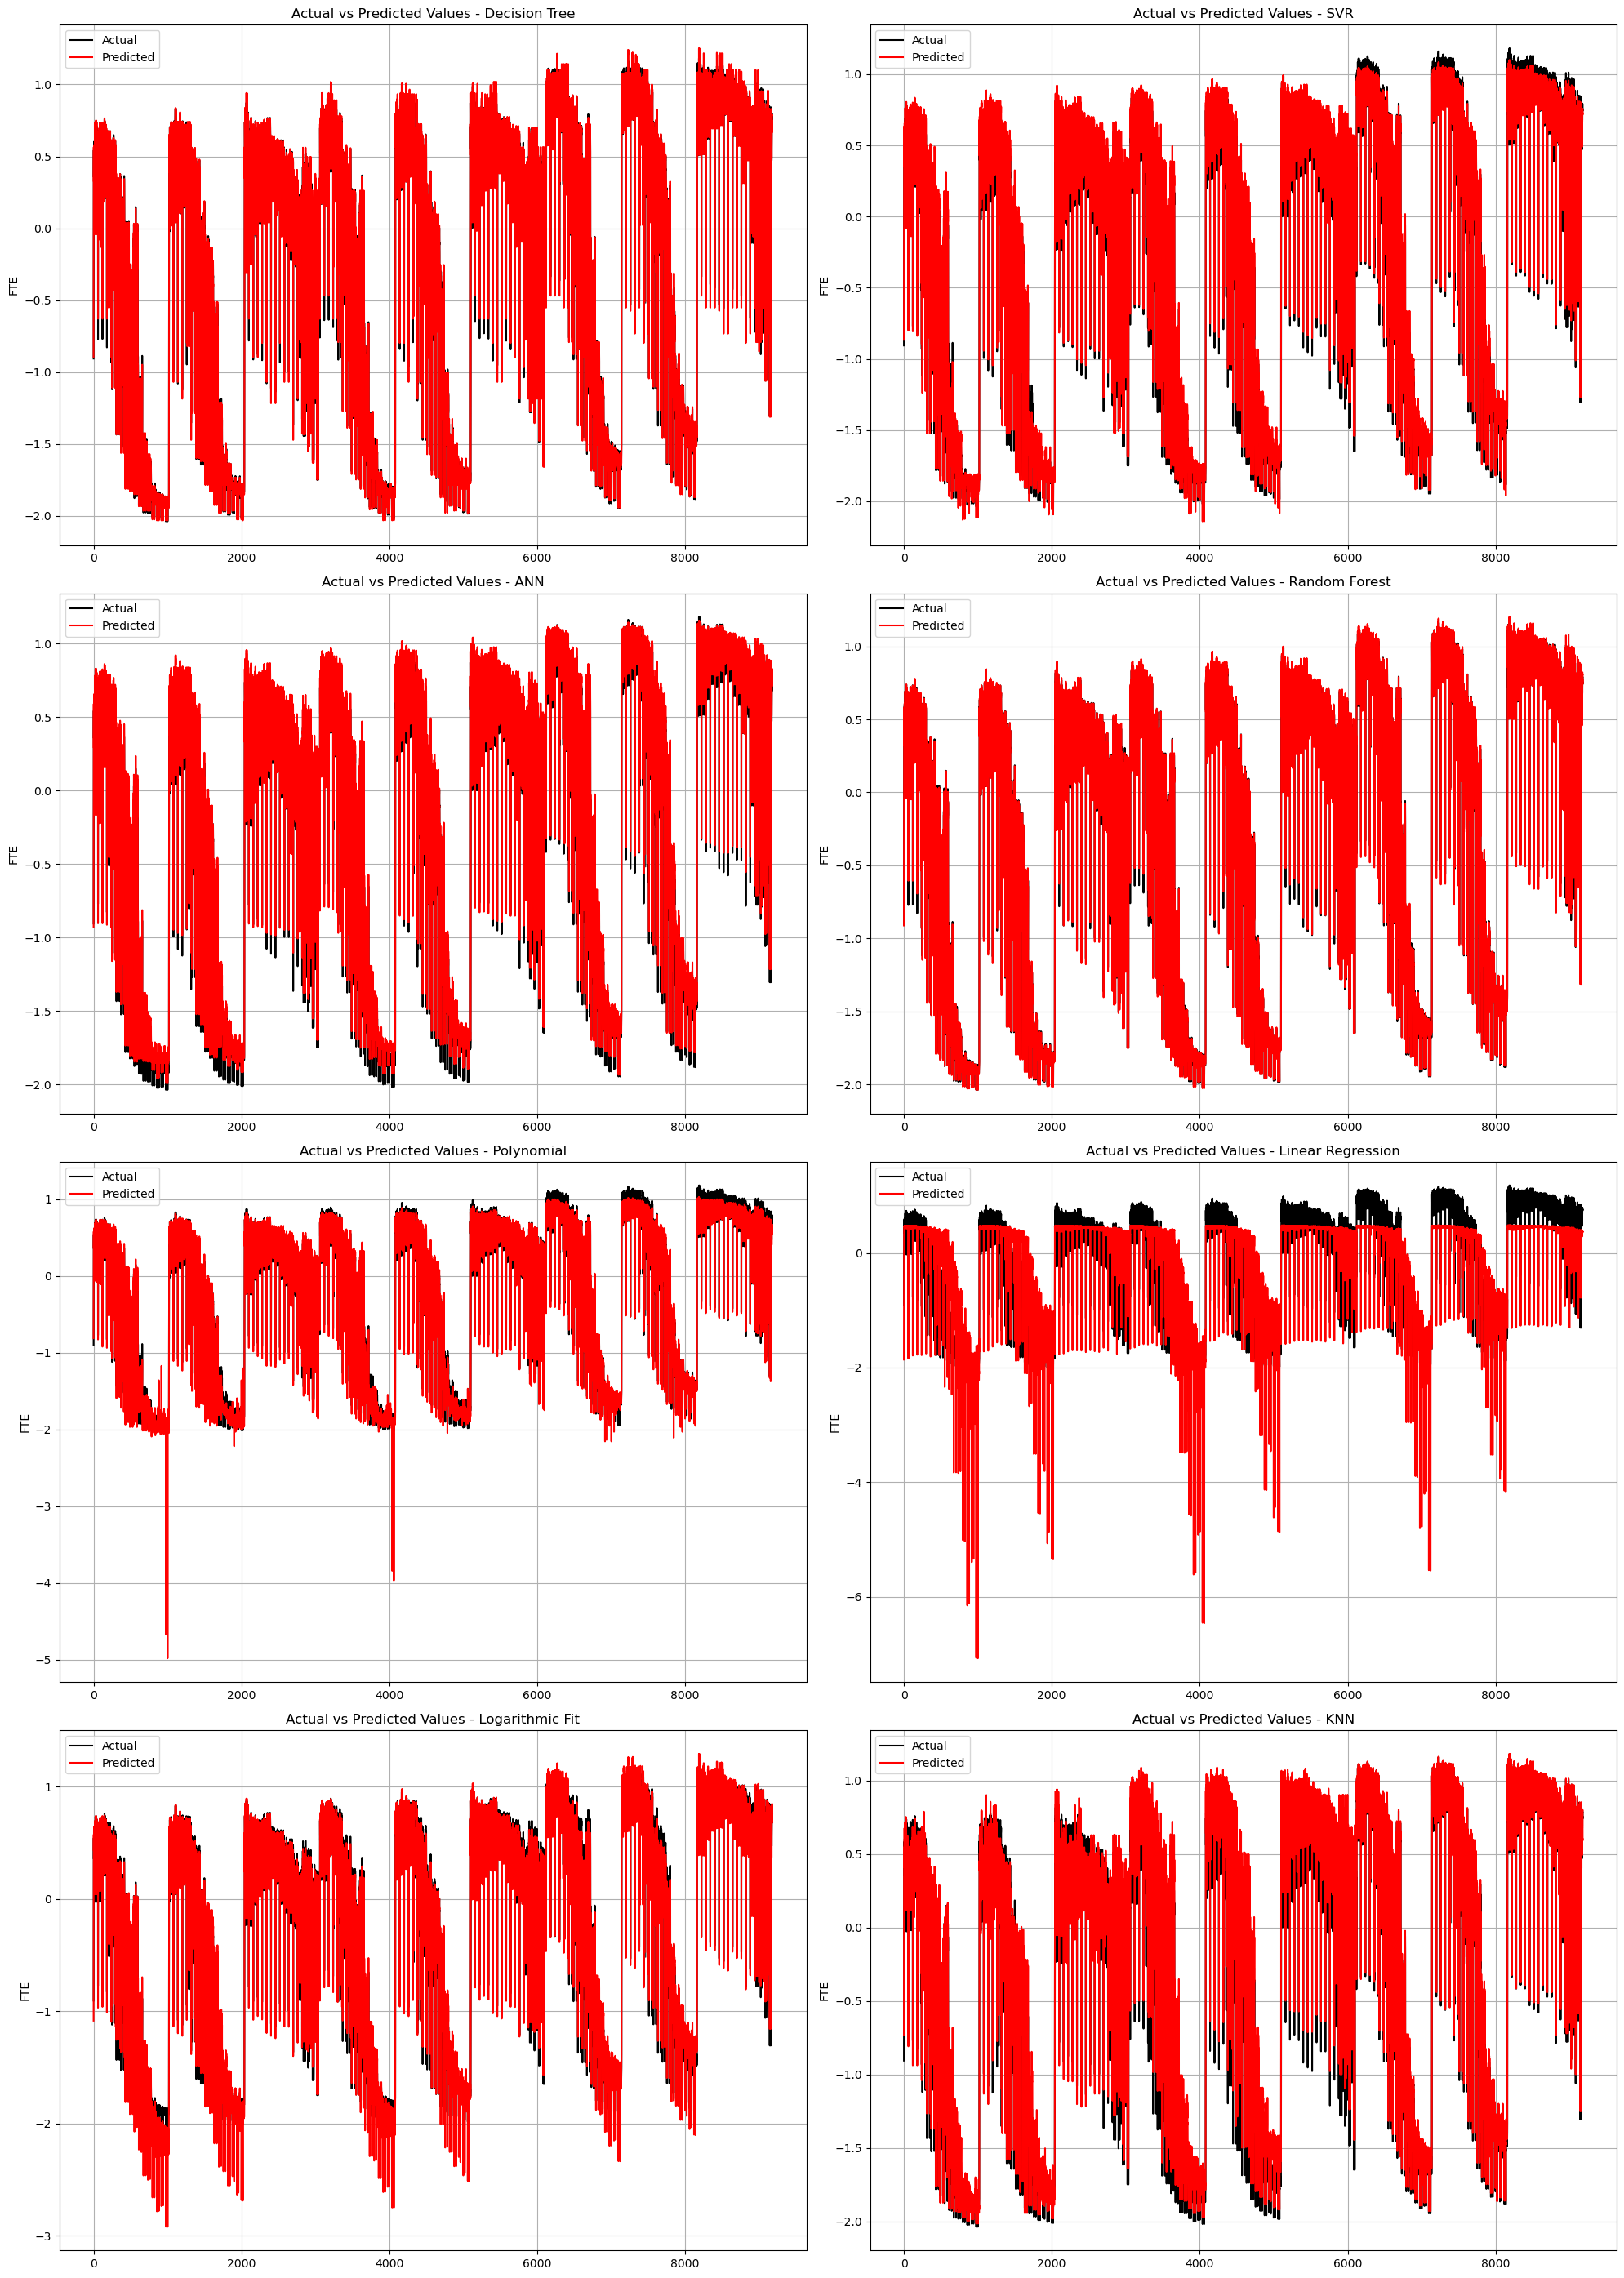

In [185]:
def plot_pred_2(y_test, predictions, model_names):
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'orange', "pink", "brown"]
    marker_size = 5

    num_models = len(model_names)
    num_rows = (num_models + 1) // 2 

    plt.figure(figsize=(20, num_rows * 7))

    for idx, (y_pred, model_name) in enumerate(zip(predictions, model_names), start=1):
        plt.subplot(num_rows, 2, idx)
        plt.plot(y_test, label='Actual', color='black')
        plt.plot(y_pred, label='Predicted', color='red')
        plt.ylabel('FTE')
        plt.title(f'Actual vs Predicted Values - {model_name}')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()
    
plot_pred_2(y_test, predictions, model_names)


### 2.Classifiaction using Binning models

In [110]:
def plot_confusion_matrices(conf_matrices, model_names):
    fig, axes = plt.subplots(1, len(conf_matrices), figsize=(15, 5))
    for ax, conf_matrix, model_name in zip(axes, conf_matrices, model_names):
        cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
        fig.colorbar(cax, ax=ax)
        ax.set_title(f'Confusion Matrix\n{model_name}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
    plt.show()

def plot_metric_comparisons(metrics, metric_names, model_names, y_min, y_max):
    x = np.arange(len(model_names))
    width = 0.2

    fig, ax = plt.subplots(figsize=(10, 6))
    for i, metric in enumerate(metrics):
        ax.bar(x + i * width, metric, width, label=metric_names[i])

    ax.set_xlabel('Models')
    ax.set_title('Comparison of Classification Metrics')
    ax.set_xticks(x + width)
    ax.set_xticklabels(model_names)
    ax.set_ylim(y_min, y_max)  # Set the y-axis limit for better precision
    ax.legend()
    plt.show()
    
    def plot_confusion_matrices_2(conf_matrices, model_names):
        num_models = len(model_names)
        fig, axes = plt.subplots(1, num_models, figsize=(15, 5))
        for i, conf_matrix in enumerate(conf_matrices):
            ax = axes[i]
            ax.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
            ax.set_title(f'Confusion Matrix - {model_names[i]}')
            ax.set_xlabel('Predicted labels')
            ax.set_ylabel('True labels')
            ax.grid(False)
            ax.xaxis.set(ticks=np.arange(len(conf_matrix)),
                        ticklabels=np.arange(len(conf_matrix)))
            ax.yaxis.set(ticks=np.arange(len(conf_matrix)),
                        ticklabels=np.arange(len(conf_matrix)))
            for j in range(len(conf_matrix)):
                for k in range(len(conf_matrix)):
                    ax.text(k, j, conf_matrix[j, k], ha='center', va='center', color='red')
        plt.tight_layout()
        plt.show()



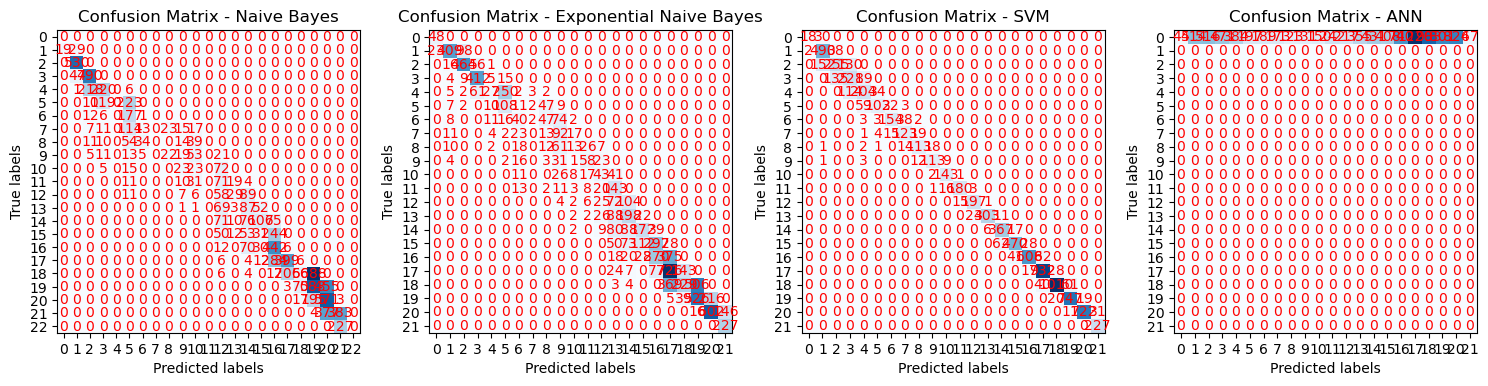

In [173]:
# Collect metrics for comparison
accuracies = [metrics_nb_3[0], metrics_nb_2[0], metrics_svm_2[0],metrics_ann_2[0]]
precisions = [metrics_nb_3[1], metrics_nb_2[1], metrics_svm_2[1],metrics_ann_2[1]]
recalls = [metrics_nb_3[2], metrics_nb_2[2], metrics_svm_2[2],metrics_ann_2[2]]
f1_scores = [metrics_nb_3[3], metrics_nb_2[3], metrics_svm_2[3],metrics_ann_2[3]]
conf_matrices = [metrics_nb_3[4], metrics_nb_2[4], metrics_svm_2[4],metrics_ann_2[4]]

model_names = ['Naive Bayes', 'Exponential Naive Bayes', 'SVM',"ANN"]
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score',"ANN"]
metrics = [accuracies, precisions, recalls, f1_scores]



plot_confusion_matrices_2(conf_matrices, model_names)


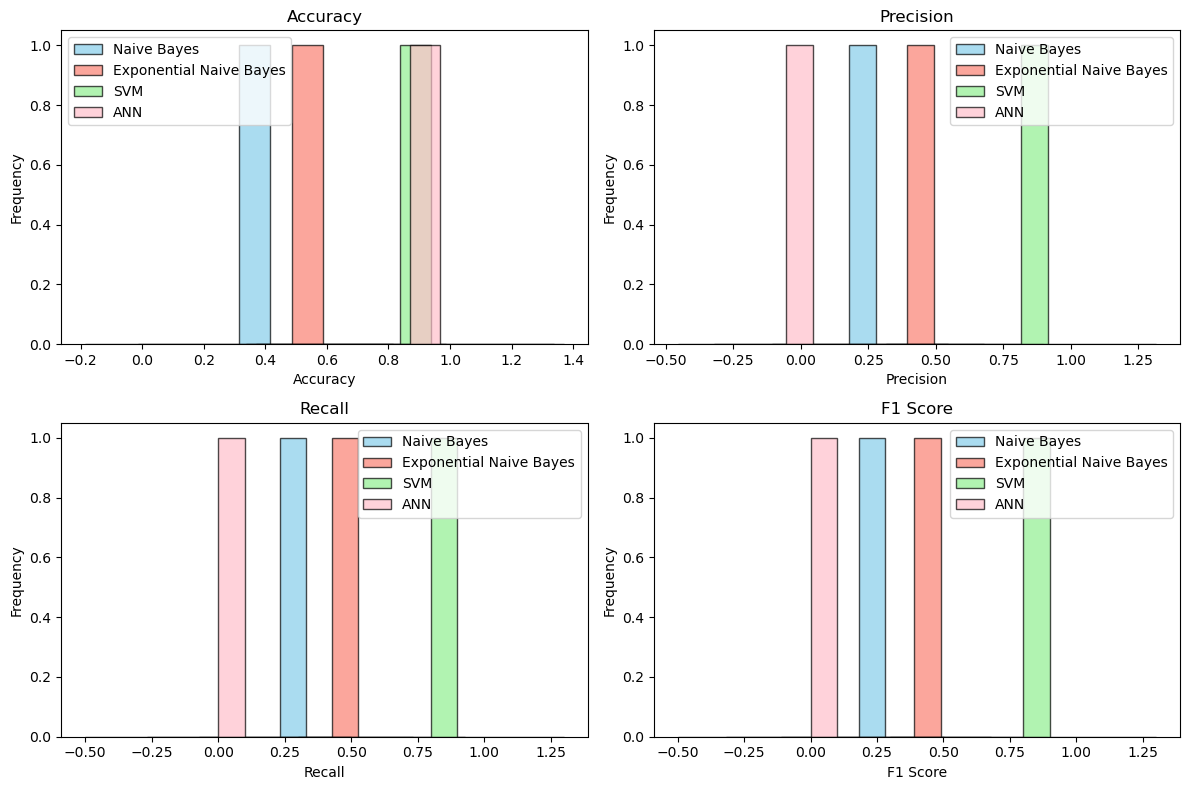

In [176]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, accuracy in enumerate(accuracies):
    axs[0, 0].hist(accuracy, bins=10, color=['skyblue', 'salmon', 'lightgreen',"pink"][i], edgecolor='black', label=model_names[i], alpha=0.7)
axs[0, 0].set_title('Accuracy')
axs[0, 0].set_xlabel('Accuracy')
axs[0, 0].set_ylabel('Frequency')
axs[0, 0].legend()

for i, precision in enumerate(precisions):
    axs[0, 1].hist(precision, bins=10, color=['skyblue', 'salmon', 'lightgreen',"pink"][i], edgecolor='black', label=model_names[i], alpha=0.7)
axs[0, 1].set_title('Precision')
axs[0, 1].set_xlabel('Precision')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].legend()

for i, recall in enumerate(recalls):
    axs[1, 0].hist(recall, bins=10, color=['skyblue', 'salmon', 'lightgreen',"pink"][i], edgecolor='black', label=model_names[i], alpha=0.7)
axs[1, 0].set_title('Recall')
axs[1, 0].set_xlabel('Recall')
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].legend()

for i, f1_score in enumerate(f1_scores):
    axs[1, 1].hist(f1_score, bins=10, color=['skyblue', 'salmon', 'lightgreen',"pink"][i], edgecolor='black', label=model_names[i], alpha=0.7)
axs[1, 1].set_title('F1 Score')
axs[1, 1].set_xlabel('F1 Score')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].legend()

plt.tight_layout()
plt.show()


### 3.Classification other approach models

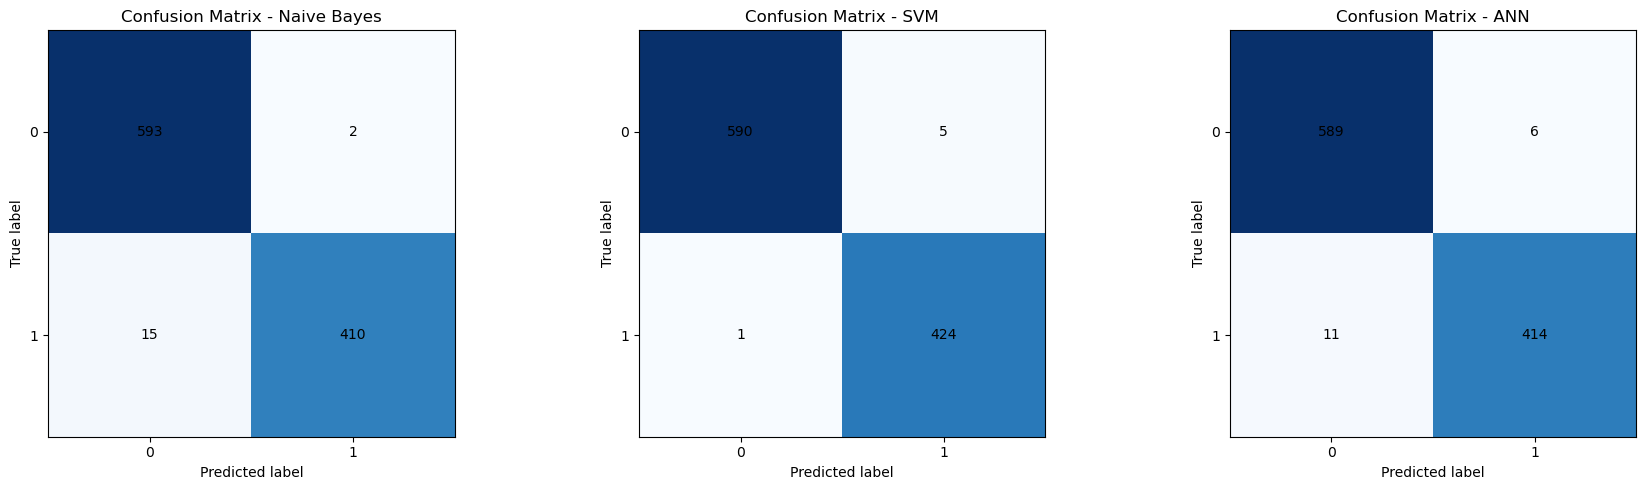

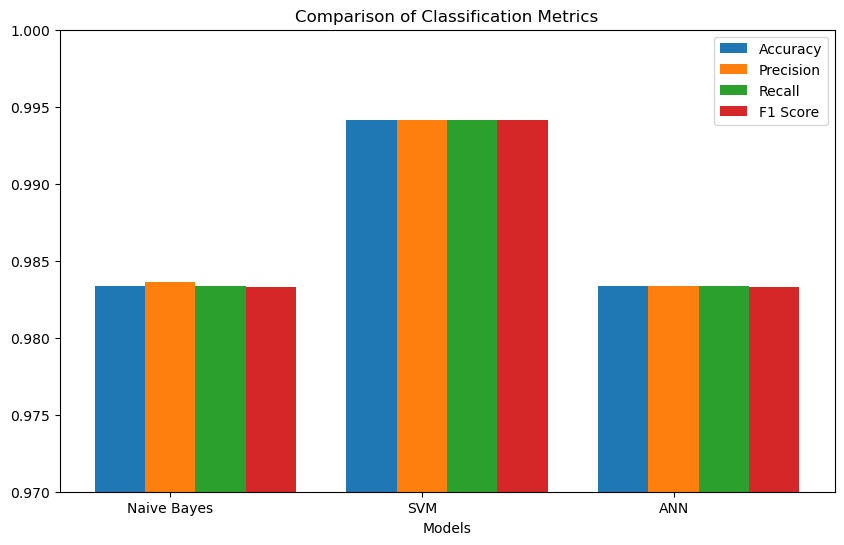

In [288]:
# Collect metrics for comparison
accuracies = [metrics_nb[0], metrics_svm[0], metrics_ANN[0]]
precisions = [metrics_nb[1], metrics_svm[1], metrics_ANN[1]]
recalls = [metrics_nb[2], metrics_svm[2], metrics_ANN[2]]
f1_scores = [metrics_nb[3], metrics_svm[3], metrics_ANN[3]]
conf_matrices = [metrics_nb[4], metrics_svm[4], metrics_ANN[4]]

model_names = ['Naive Bayes', 'SVM', 'ANN']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
metrics = [accuracies, precisions, recalls, f1_scores]

plot_confusion_matrices(conf_matrices, model_names)

plot_metric_comparisons(metrics, metric_names, model_names, y_min=0.97, y_max=1.0)


# Future Work

In [180]:

df0 = pd.DataFrame({
    'ftt_y': data["ftt_y"],
    'ftt_z': data["ftt_z"],
    'freq_z': data['freq_z'],
    'freq_y': data['freq_y'],
    'amp_y': data['amp_y'],
    'amp_z': data['amp_z'],
    'wconfid': data['wconfid'],
    'pctid': data['pctid'],
})

RPM = rmp(freq_dict,50)
df0["RPM"] = RPM
df0["SPEED"] = [df0['pctid'][i]*1900/100 for i in range(len(df0))]
threshold_percentage = 0.50  # 15%

status = []

for i in range(len(df0)):
    if df0['RPM'][i] > (1 + threshold_percentage) * df0['SPEED'][i] :
        status.append(2)  # Speed is more than 15% above the original speed
    elif df0['RPM'][i] < (1 - threshold_percentage) * df0['SPEED'][i] :
        status.append(1)  # Speed is more than 15% below the original speed
    else:
        status.append(0)  # Speed is within 15% of the original speed

df0["status"] = status

grouped_data = df0.groupby('wconfid')

test_sets2 = []

for name, group in grouped_data:
    if name == 2:
        test_sets2.append(group)

test_df = pd.concat(test_sets2)

df_train = df0.drop(test_df.index)

x_train_c2 = df_train.drop(columns=['status', 'freq_y', 'pctid', 'wconfid',"RPM","SPEED"])
y_train_c2 = df_train['status']
x_test_c2 = test_df.drop(columns=['status', 'freq_y', 'pctid', 'wconfid',"RPM","SPEED"])
y_test_c2 = test_df['status']

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_c2)
x_test_scaled = scaler.transform(x_test_c2)

x_train_c2 = pd.DataFrame(x_train_scaled, columns=x_train_c2.columns)
x_test_c2 = pd.DataFrame(x_test_scaled, columns=x_test_c2.columns)


y_train_c2 = y_train_c.ravel()
y_test_c2 = y_test_c.ravel()


In [181]:

param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10 , 1000]}

svm2 = SVC(kernel='rbf', probability=True)

grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train_c2, y_train_c2)

best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy:", best_accuracy)


Best Parameters: {'C': 100, 'gamma': 0.001}
Best Accuracy: 0.9936274509803923


In [192]:
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(x_test_c2)
test_accuracy = accuracy_score(y_test_c2, y_pred)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.9941176470588236


#### references:
- https://www.mdpi.com/1424-8220/19/19/4342
- https://dsp.stackexchange.com/questions/62908/interpreting-the-amplitude-of-signals-in-fourier-transform
- https://towardsdatascience.com/fourier-transform-the-practical-python-implementation-acdd32f1b96a